In [2]:
library(dplyr)
library(NMF)
library(vcd)
library(survival)
library(ggstatsplot)
library(ggplot2)
library(DESeq2)
library(ggfortify)
library(glmnet) # package for regularization in GLMs
library(repr)

In [3]:
dir_nam = '/home/akansha/downloads/Pan_Cancer_dataset/gene_exp/prepared_datasets/TCGA-UCEC'
files_nam = c('_expression_data.csv', '_clinical_data.csv', '_vst_data.csv')
res_dir = '/home/akansha/downloads/metabolic_characterization/met_subtypes_nmf/ucec_nmf_results_542sample_1000genes/'

In [4]:
read_exp_file <- function(file){
    exp_data <- read.csv(file)
    row.names(exp_data) <- exp_data$barcode
    exp_data$barcode <- NULL
    exp_data <- t(exp_data)
    print(dim(exp_data))
    return(exp_data)
}

read_clinical_file <- function(file){
    clinical_data <- read.csv(file)
    row.names(clinical_data) <- clinical_data$barcode
    clinical_data$barcode <- NULL
    print(dim(clinical_data))
    return(clinical_data)    
}

#### Expression data

In [5]:
ucec_exp_data <- read_exp_file(paste(dir_nam, files_nam[1], sep=''))
head(ucec_exp_data, 3)

[1] 56602   565


TCGA-2E-A9G8-01A-11R-A40A-07 TCGA-4E-A92E-01A-11R-A37O-07
ENSG00000000003 6753                         4300                        
ENSG00000000005    9                            3                        
ENSG00000000419 2899                         1162                        
                TCGA-5B-A90C-01A-11R-A37O-07 TCGA-5S-A9Q8-01A-11R-A40A-07
ENSG00000000003 11890                        709                         
ENSG00000000005     0                          1                         
ENSG00000000419  2628                        254                         
                TCGA-A5-A0G1-01A-11R-A118-07 TCGA-A5-A0G2-01A-11R-A16W-07
ENSG00000000003 1168                         1787                        
ENSG00000000005    0                            0                        
ENSG00000000419  607                          857                        
                TCGA-A5-A0G3-01A-11R-A040-07 TCGA-A5-A0G5-01A-11R-A040-07
ENSG00000000003 1083                         666                         
ENSG00000000005    9                           1                         
ENSG00000000419  243                         304                         
                TCGA-A5-A0G9-01A-11R-A040-07 TCGA-A5-A0GA-01A-11R-A040-07 ⋯
ENSG00000000003 1468                         1632                         ⋯
ENSG00000000005    5                            0                         ⋯
ENSG00000000419  284                          923                         ⋯
                TCGA-QF-A5YS-01A-11R-A31O-07 TCGA-QF-A5YT-01A-11R-A31O-07
ENSG00000000003 9455                         7633                        
ENSG00000000005    2                            2                        
ENSG00000000419 1949                         1700                        
                TCGA-QS-A5YQ-01A-11R-A31O-07 TCGA-QS-A5YR-01A-31R-A31O-07
ENSG00000000003 5453                         5224                        
ENSG00000000005    6                            1                        
ENSG00000000419 1035                         1198                        
                TCGA-QS-A744-01A-11R-A34R-07 TCGA-QS-A8F1-01A-21R-A37O-07
ENSG00000000003 9564                         1005                        
ENSG00000000005    2                            2                        
ENSG00000000419 2473                          232                        
                TCGA-SJ-A6ZI-01A-12R-A34R-07 TCGA-SJ-A6ZJ-01A-12R-A34R-07
ENSG00000000003 8131                         7202                        
ENSG00000000005    4                            5                        
ENSG00000000419 2375                         1417                        
                TCGA-SL-A6J9-01A-11R-A31O-07 TCGA-SL-A6JA-01A-11R-A31O-07
ENSG00000000003 5357                         5795                        
ENSG00000000005    4                            4                        
ENSG00000000419 4630                         1626

#### Clinical Data

In [6]:
ucec_clinical_data <- read_clinical_file(paste(dir_nam, files_nam[2], sep=''))
head(ucec_clinical_data, 1)

[1] 565  13


index        sample_type   sample          
TCGA-2E-A9G8-01A-11R-A40A-07 TCGA-2E-A9G8 Primary Tumor TCGA-2E-A9G8-01A
                             sample_type_id clinical_stage
TCGA-2E-A9G8-01A-11R-A40A-07 1              Stage_III     
                             age_at_initial_pathologic_diagnosis
TCGA-2E-A9G8-01A-11R-A40A-07 59                                 
                             histological_type                      
TCGA-2E-A9G8-01A-11R-A40A-07 Endometrioid endometrial adenocarcinoma
                             histological_grade OS death_days_to
TCGA-2E-A9G8-01A-11R-A40A-07 G2                 0  0            
                             last_contact_days_to OS.time detailed_sample_type
TCGA-2E-A9G8-01A-11R-A40A-07 1249                 1249    primary_tumor

#### Gene Mapping Data

In [7]:
genemapping_file <- '/home/akansha/downloads/Pan_Cancer_dataset/gene_exp/TCGA-UCEC_geneSymbol_ensembleID_mapping.csv'
gene_mapping <- read.csv(genemapping_file)
rownames(gene_mapping) <- gene_mapping$X
gene_mapping$X <- NULL
print(dim(gene_mapping))
head(gene_mapping, 2)

[1] 56602     3


ensembl_gene_id external_gene_name original_ensembl_gene_id
ENSG00000000003 ENSG00000000003 TSPAN6             ENSG00000000003.13      
ENSG00000000005 ENSG00000000005 TNMD               ENSG00000000005.5

In [8]:
hmr2_genes_mapping =read.csv('/home/akansha/downloads/metabolic_characterization/HMRdatabase2_00.xlsx - GENES.csv')
rownames(hmr2_genes_mapping) <- hmr2_genes_mapping$GENE.NAME
hmr2_genes_mapping$X. <- NULL
print(dim(hmr2_genes_mapping))
head(hmr2_genes_mapping, 2)

[1] 3765    6


GENE.NAME       GENE.ID.1       GENE.ID.2 SHORT.NAME
ENSG00000000419 ENSG00000000419 ENSG00000000419 8813      DPM1      
ENSG00000000938 ENSG00000000938 ENSG00000000938 2268      FGR       
                COMPARTMENT DESCRIPTION
ENSG00000000419 c                      
ENSG00000000938 c

### Subsetting Primary tumor samples

In [9]:
ucec_prim_exp_data <- ucec_exp_data[, rownames(ucec_clinical_data[ucec_clinical_data['sample_type'] == 'Primary Tumor',])]
ucec_prim_clinical_data <-ucec_clinical_data[rownames(ucec_clinical_data[ucec_clinical_data['sample_type']=='Primary Tumor',]),]
print(dim(ucec_prim_exp_data))
print(dim(ucec_prim_clinical_data))

[1] 56602   542
[1] 542  13


### VST Normalisation

In [10]:
vst_norm <- function(count_data){
    ## Pre-filtering the dataset 
    keep = rowSums(count_data >= 10) >= 5
    counts_keep <- count_data[keep,]
    print(nrow(counts_keep))

    ## Variance stabilizing transformation [Sample- level Quality Control]
    vst_prim <- vst(counts_keep, blind = FALSE)
    print(dim(vst_prim))
    return(vst_prim)
}

In [11]:
ucec_vst_data = vst_norm(ucec_prim_exp_data)
head(ucec_vst_data,2)

[1] 31583
[1] 31583   542


TCGA-2E-A9G8-01A-11R-A40A-07 TCGA-4E-A92E-01A-11R-A37O-07
ENSG00000000003 12.063086                    11.147521                   
ENSG00000000005  4.162518                     3.608741                   
                TCGA-5B-A90C-01A-11R-A37O-07 TCGA-5S-A9Q8-01A-11R-A40A-07
ENSG00000000003 12.238615                    10.568914                   
ENSG00000000005  2.967264                     3.710254                   
                TCGA-A5-A0G1-01A-11R-A118-07 TCGA-A5-A0G2-01A-11R-A16W-07
ENSG00000000003 10.467897                    10.862432                   
ENSG00000000005  2.967264                     2.967264                   
                TCGA-A5-A0G3-01A-11R-A040-07 TCGA-A5-A0G5-01A-11R-A040-07
ENSG00000000003 10.878495                    10.241049                   
ENSG00000000005  4.860502                     3.651758                   
                TCGA-A5-A0G9-01A-11R-A040-07 TCGA-A5-A0GA-01A-11R-A040-07 ⋯
ENSG00000000003 11.009437                    10.646012                    ⋯
ENSG00000000005  4.282991                     2.967264                    ⋯
                TCGA-QF-A5YS-01A-11R-A31O-07 TCGA-QF-A5YT-01A-11R-A31O-07
ENSG00000000003 11.820242                    12.207950                   
ENSG00000000005  3.415676                     3.536991                   
                TCGA-QS-A5YQ-01A-11R-A31O-07 TCGA-QS-A5YR-01A-31R-A31O-07
ENSG00000000003 11.887101                    11.673983                   
ENSG00000000005  3.996313                     3.372954                   
                TCGA-QS-A744-01A-11R-A34R-07 TCGA-QS-A8F1-01A-21R-A37O-07
ENSG00000000003 11.711731                    11.094794                   
ENSG00000000005  3.396728                     4.016415                   
                TCGA-SJ-A6ZI-01A-12R-A34R-07 TCGA-SJ-A6ZJ-01A-12R-A34R-07
ENSG00000000003 11.55312                     11.888369                   
ENSG00000000005  3.58807                      3.791231                   
                TCGA-SL-A6J9-01A-11R-A31O-07 TCGA-SL-A6JA-01A-11R-A31O-07
ENSG00000000003 11.202061                    11.484603                   
ENSG00000000005  3.643031                     3.683453

### HMR2 Genes

In [12]:
hmr2_gene_file = '/home/akansha/downloads/metabolic_characterization/HMRdatabase2_00.xlsx - GENES.csv'
hmr2_genes = read.csv(hmr2_gene_file)
hmr2_genes <- hmr2_genes$GENE.NAME
length(hmr2_genes)

[1] 3765

In [13]:
length(intersect(rownames(ucec_prim_exp_data), hmr2_genes))

[1] 3672

In [14]:
ucec_vst_data = as.data.frame(ucec_vst_data[intersect(rownames(ucec_vst_data), hmr2_genes), ])
print(dim(ucec_vst_data))

[1] 3584  542


### PCA

#### 1. Two groups

In [15]:
pca_df = merge(t(ucec_exp_data[rownames(ucec_vst_data),]) , ucec_clinical_data["sample_type"], by="row.names") 
row.names(pca_df) = pca_df$Row.names
pca_df = pca_df[, -1]
print(dim(pca_df))
#pca_df
pca_res <- prcomp( pca_df[, - 3585], center = TRUE, scale. = TRUE)

[1]  565 3585


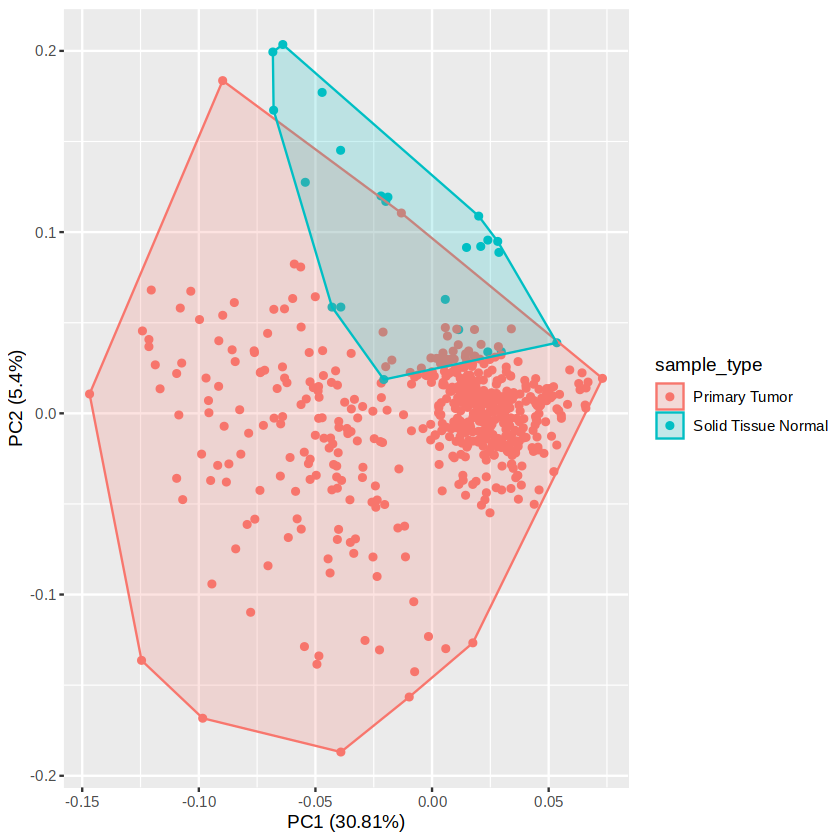

In [16]:
autoplot(pca_res, data = pca_df, colour = "sample_type", frame = TRUE)

In [22]:
pca_plot_file <- file.path(paste(res_dir, 'pca_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file, height = 5, width = 6, units = 'in', res=300)

# Print your heatmap
autoplot(pca_res, data = pca_df, colour = 'sample_type')

# Close the PNG file:
dev.off()

png 
  2

In [20]:
pca_plot_file2 <- file.path(paste(res_dir, 'pca_plot_boundary.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file2, height = 5, width = 6, units = 'in', res=300)

# Print your heatmap
autoplot(pca_res, data = pca_df, colour = 'sample_type', frame = TRUE)

# Close the PNG file:
dev.off()

png 
  2

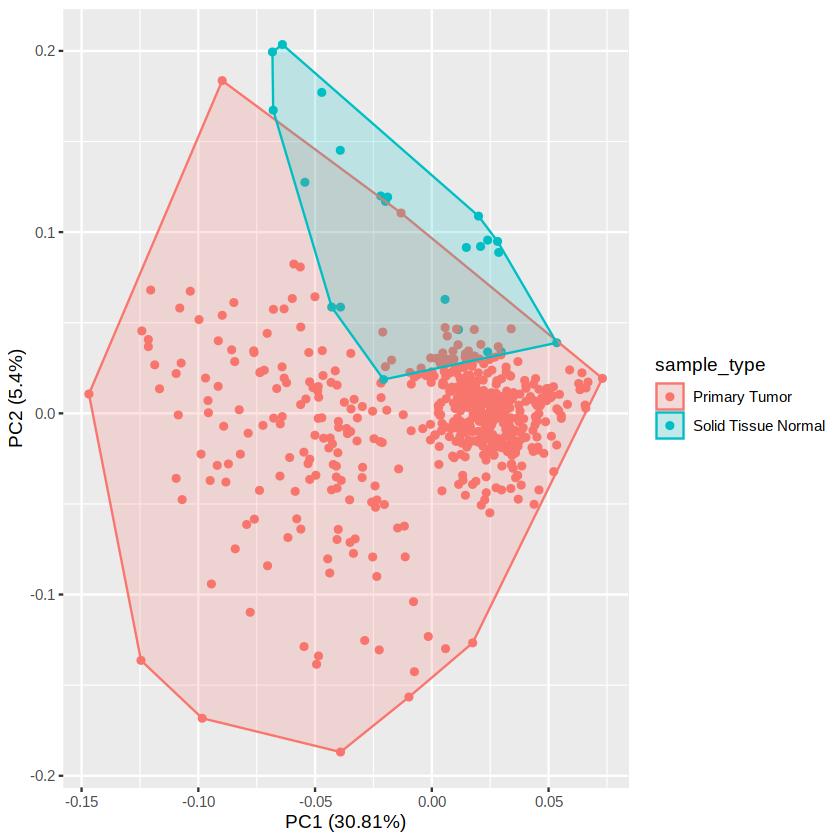

In [17]:
autoplot(pca_res, data = pca_df, colour = 'sample_type', frame = TRUE)

#### 2. Three Groups

In [18]:
pca_df2 = merge(t(ucec_exp_data[rownames(ucec_vst_data),]) , ucec_clinical_data["detailed_sample_type"], 
                by="row.names") 
row.names(pca_df2) = pca_df2$Row.names
pca_df2 = pca_df2[, -1]
print(dim(pca_df2))
#pca_df
pca_res2 <- prcomp( pca_df2[, - 3585], center = TRUE, scale. = TRUE)

[1]  565 3585


In [19]:
pca_plot_file3 <- file.path(paste(res_dir, 'pca_3grp_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file3, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res2, data = pca_df2, colour = 'detailed_sample_type')

# Close the PNG file:
dev.off()

png 
  2

In [20]:
pca_plot_file4 <- file.path(paste(res_dir, 'pca_3grp_plot_boundary.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file4, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res2, data = pca_df2, colour = 'detailed_sample_type', frame = TRUE)

# Close the PNG file:
dev.off()

png 
  2

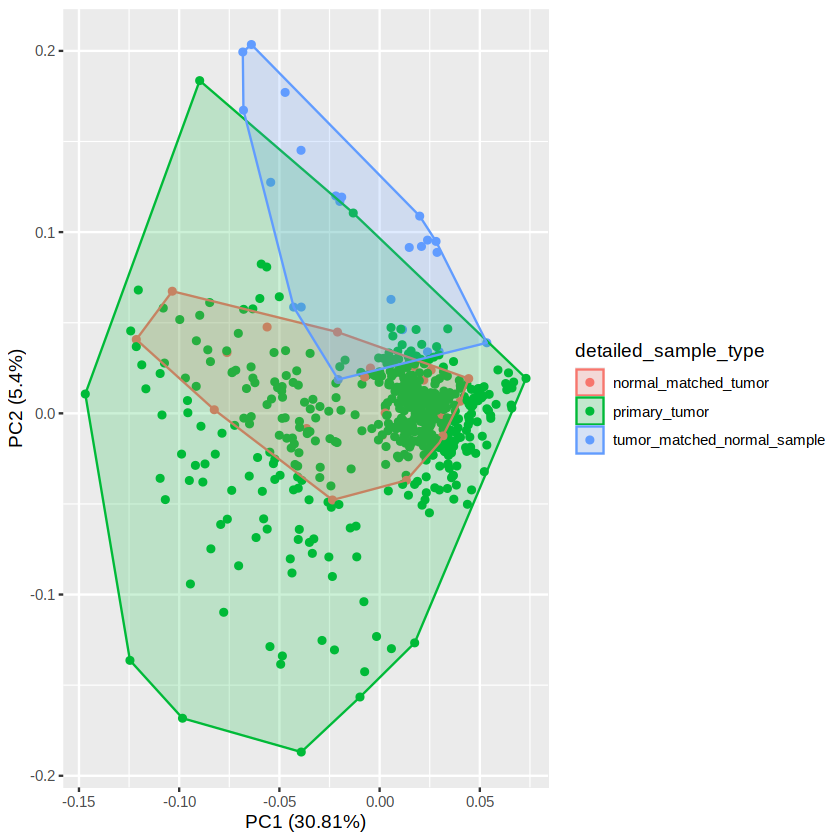

In [21]:
autoplot(pca_res2, data = pca_df2, colour = 'detailed_sample_type', frame = TRUE)

### Median Absolute Deviation

In [17]:
compute_sort_mad <- function(vst_data, top = 1500){
    mad_df = as.data.frame(sapply(as.data.frame(t(vst_data)), mad))
    colnames(mad_df) <- 'median_abs_dev'
    mad_df = arrange(mad_df, median_abs_dev)
    top_mad_genes <- rownames(tail(mad_df, top))
    return(list(top_mad_genes, mad_df))  
}

In [18]:
ucec_mad <- compute_sort_mad(ucec_vst_data, top = 1000)
mad_df <-  ucec_mad[[2]]
ucec_top_mad_genes <- ucec_mad[[1]]
print(dim(mad_df))
print(summary(mad_df))
length(ucec_top_mad_genes)
#write.csv(mad_df, file=paste(res_dir,'genefeatures_mad_data.csv', sep=''),quote=F)
# write.csv(gene_mapping[ucec_top_mad_genes, ],file=paste(res_dir,'mad_genes.csv', sep=''),
#          quote=F,row.names = FALSE)
#print_genes(gene_mapping[ucec_top_mad_genes,'external_gene_name'])

[1] 3584    1
 median_abs_dev  
 Min.   :0.0000  
 1st Qu.:0.5117  
 Median :0.6658  
 Mean   :0.7884  
 3rd Qu.:0.9518  
 Max.   :3.7972  


[1] 1000

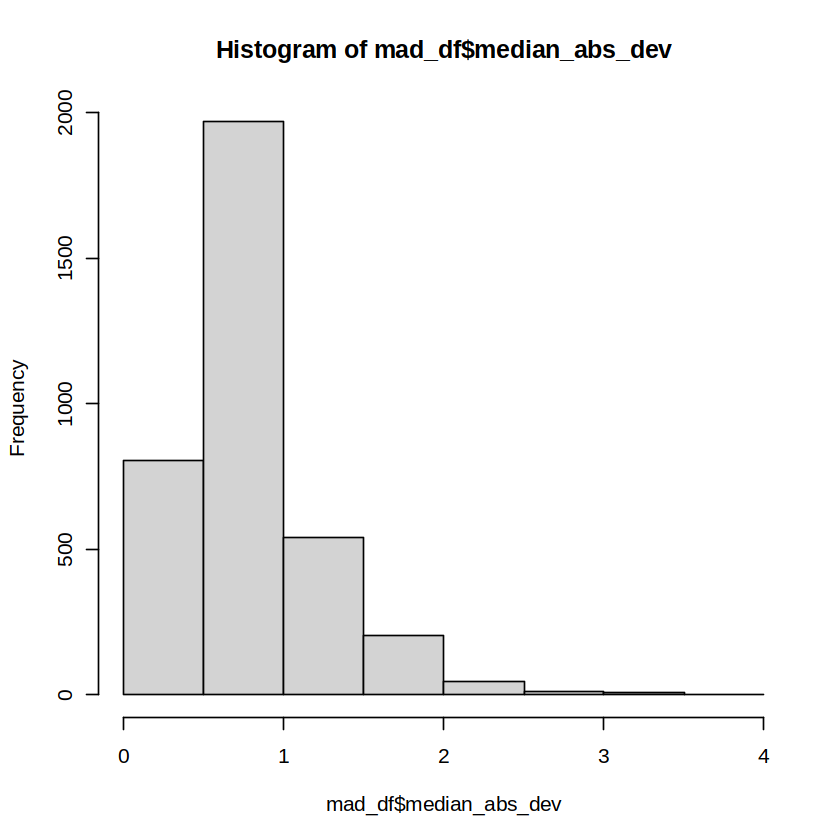

In [19]:
hist(mad_df$median_abs_dev)

# NMF
To compare the results from different algorithms, one can pass a list of methods in argument method. Also, fix the random seed to 123456.

In [20]:
# list all available algorithms
print(nmfAlgorithm()[1:6])

[1] "brunet"    "KL"        "lee"       "Frobenius" "offset"    "nsNMF"    


In [21]:
nmf_run <- function(data, rank , method = 'brunet', seed_meth = "random", n_run = 10){
    res <- nmf(data, rank , method, seed= seed_meth, nrun = n_run, .options='t')
    return(res)
}

## A. Rank Estimation

In [22]:
ucec_rank_estimation_res = nmf_run(ucec_vst_data[ucec_top_mad_genes,], 2:7, seed_meth =123456, n_run = 50)

In [23]:
ucec_rank_estimation_res_summary <- t(as.data.frame(summary(ucec_rank_estimation_res)))
write.csv(ucec_rank_estimation_res_summary,file=paste(res_dir,'rank_estimation_summary.csv', sep=''),quote=F)
ucec_rank_estimation_res_summary

2          3          4          5          6         
method               brunet     brunet     brunet     brunet     brunet    
seed                 random     random     random     random     random    
rng                  3          3          4          1          2         
metric               KL         KL         KL         KL         KL        
rank                 2          3          4          5          6         
sparseness.basis     0.05676596 0.06734920 0.08208906 0.09151451 0.10651723
sparseness.coef      0.1196027  0.1611624  0.1696566  0.1932203  0.1986693 
rss                  978113.8   912614.6   858202.0   816255.7   773428.8  
evar                 0.9727620  0.9745860  0.9761012  0.9772693  0.9784620 
silhouette.coef      1.0000000  0.6503142  0.5490305  0.3784360  0.3240601 
silhouette.basis     1.0000000  0.6068370  0.4611566  0.3723801  0.2958497 
residuals            67584.09   63069.48   59263.74   56444.74   53698.41  
niter                1430       2000       2000       2000       2000      
cpu                  28.434     49.201     58.204     66.732     77.391    
cpu.all              1487.259   2590.530   3125.186   3591.959   4095.522  
nrun                 50         50         50         50         50        
cophenetic           0.9839257  0.9051341  0.8672488  0.8665442  0.8482590 
dispersion           0.8969212  0.5879474  0.5833662  0.5891528  0.6249331 
silhouette.consensus 0.9481549  0.5601333  0.5094684  0.4195992  0.3401579 
                     7         
method               brunet    
seed                 random    
rng                  2         
metric               KL        
rank                 7         
sparseness.basis     0.11343151
sparseness.coef      0.2186774 
rss                  739270.3  
evar                 0.9794132 
silhouette.coef      0.2914916 
silhouette.basis     0.2396114 
residuals            51391.85  
niter                2000      
cpu                  86.050    
cpu.all              4500.842  
nrun                 50        
cophenetic           0.8601920 
dispersion           0.6701042 
silhouette.consensus 0.3464931

In [30]:
library(ggthemes)

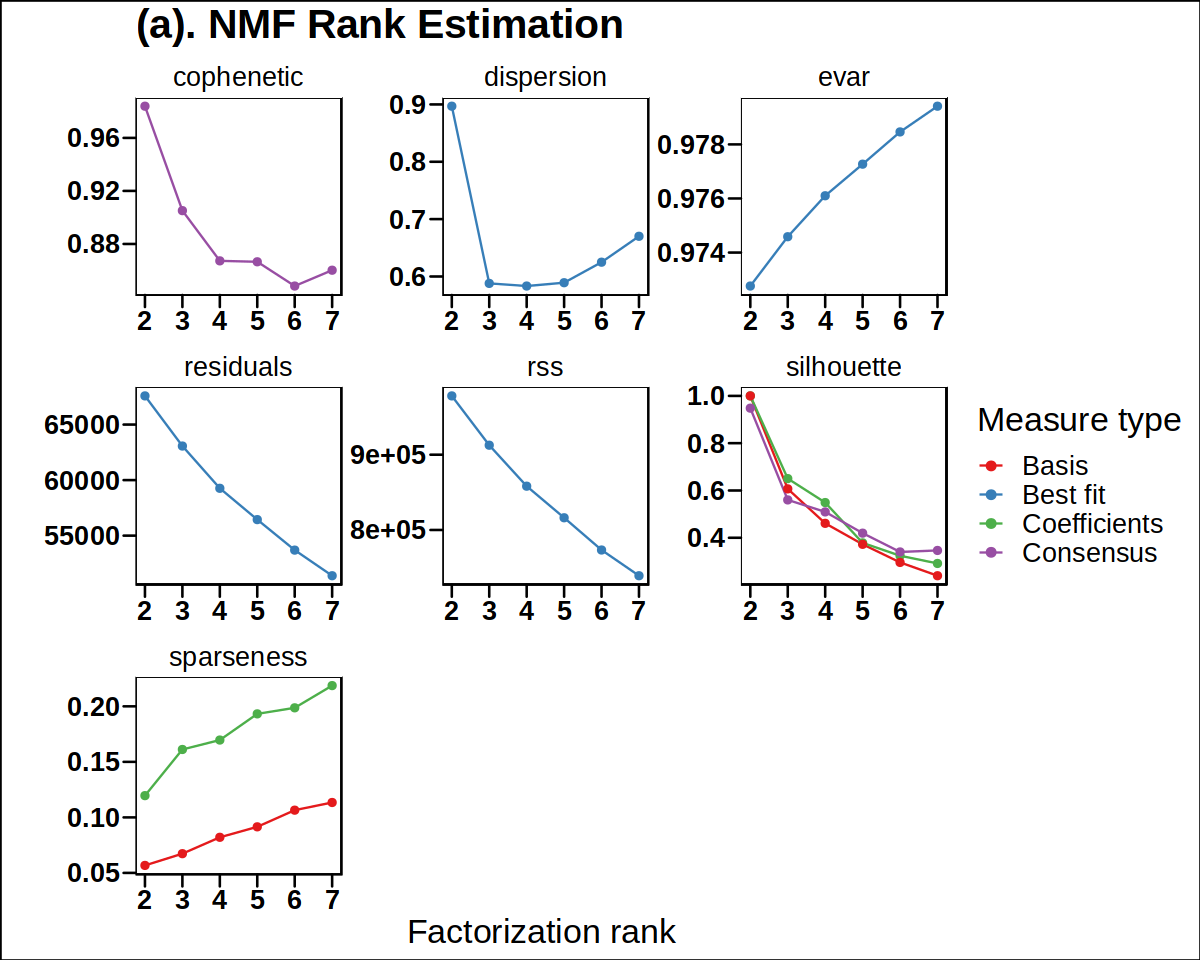

In [269]:
options(repr.plot.width = 10, repr.plot.height = 8)
ucec_rank_summ_plot <-  plot(ucec_rank_estimation_res) + theme_base(base_size = 20) +
                             #theme_classic(base_size = 20) + 
                             theme(axis.text = element_text(face="bold"), plot.title = element_text(face="bold"),
                                  plot.caption = element_text(face = "bold")) + 
                                  labs(title = "(a). NMF Rank Estimation")
                    
ucec_rank_summ_plot

In [23]:
ucec_rank_summ_plot_file <- file.path(paste(res_dir, 'rank_summ_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_rank_summ_plot_file, height = 5, width = 5, units = 'in', res=300)

# Print your heatmap
ucec_rank_summ_plot

# Close the PNG file:
dev.off()

png 
  2

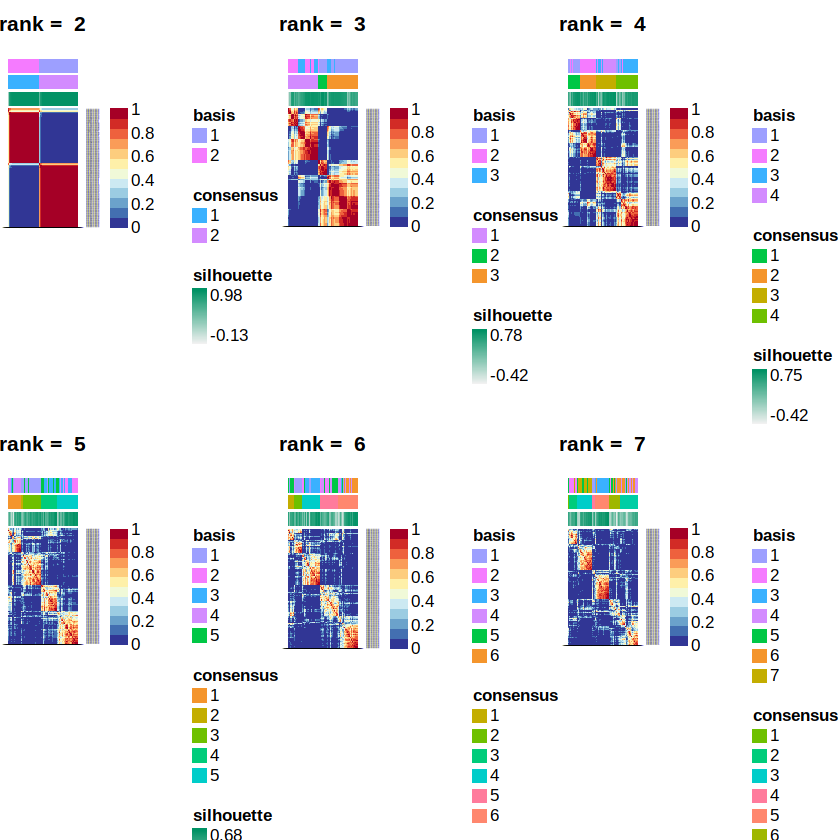

In [24]:
consensusmap(ucec_rank_estimation_res)

In [25]:
ucec_rank_consensus_plot_file <- file.path(paste(res_dir, 'rank_consensus_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_rank_consensus_plot_file, height = 10, width = 10, units = 'in', res=300)

# Print your heatmap
consensusmap(ucec_rank_estimation_res)

# Close the PNG file:
dev.off()

png 
  2

## B. Comparing the Algorithms

In [26]:
ucec_method_res = nmf_run(ucec_vst_data[ucec_top_mad_genes,], 2, method = nmfAlgorithm()[1:6], seed_meth =123456, n_run = 50)

Compute NMF method 'brunet' [1/6] ... OK
Compute NMF method 'KL' [2/6] ... OK
Compute NMF method 'lee' [3/6] ... OK
Compute NMF method 'Frobenius' [4/6] ... OK
Compute NMF method 'offset' [5/6] ... OK
Compute NMF method 'nsNMF' [6/6] ... OK


In [27]:
t(compare(ucec_method_res))
write.csv(t(compare(ucec_method_res)),file=paste(res_dir, 'algo_compare_summary.csv', sep=''),quote=F)

brunet     KL         lee        Frobenius  offset    
method               brunet     KL         lee        Frobenius  offset    
seed                 random     random     random     random     random    
rng                  1          2          3          3          1         
metric               KL         KL         euclidean  euclidean  euclidean 
rank                 2          2          2          2          2         
sparseness.basis     0.05676596 0.05546217 0.05322440 0.05318731 0.23250482
sparseness.coef      0.1196027  0.1281043  0.1426376  0.1429336  0.4330597 
silhouette.coef      1          1          1          1          1         
silhouette.basis     1          1          1          1          1         
residuals             67584.09   67582.78  488420.89  488420.86  472190.30 
niter                1430       2000       1070       2000       2000      
cpu                   28.873    103.460     13.168     70.299    196.213   
cpu.all              1487.947   5499.751    924.450   3837.652   7527.441  
nrun                 50         50         50         50         50        
cophenetic           0.9839257  0.9805027  0.9807760  0.9816707  0.9949887 
dispersion           0.8969212  0.8995492  0.8983300  0.9070974  0.9592890 
silhouette.consensus 0.9481549  0.9430248  0.9444510  0.9413494  0.9818687 
                     nsNMF     
method               nsNMF     
seed                 random    
rng                  2         
metric               KL        
rank                 2         
sparseness.basis     0.06446105
sparseness.coef      0.2916382 
silhouette.coef      1         
silhouette.basis     1         
residuals             67601.58 
niter                1790      
cpu                   37.897   
cpu.all              1828.740  
nrun                 50        
cophenetic           0.9952542 
dispersion           0.9515967 
silhouette.consensus 0.9803959

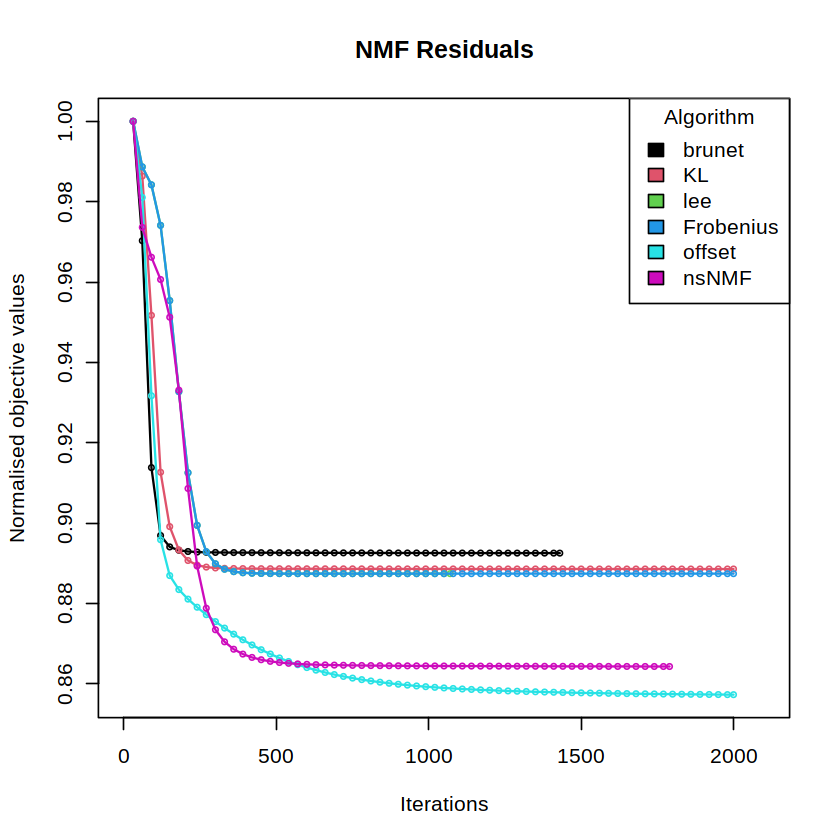

In [28]:
plot(ucec_method_res)

In [29]:
ucec_residuals_plot_file <- file.path(paste(res_dir, 'algo_compare_residual_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_residuals_plot_file, height = 5, width = 5, units = 'in', res=300)

plot(ucec_method_res)

# Close the PNG file:
dev.off()

png 
  2

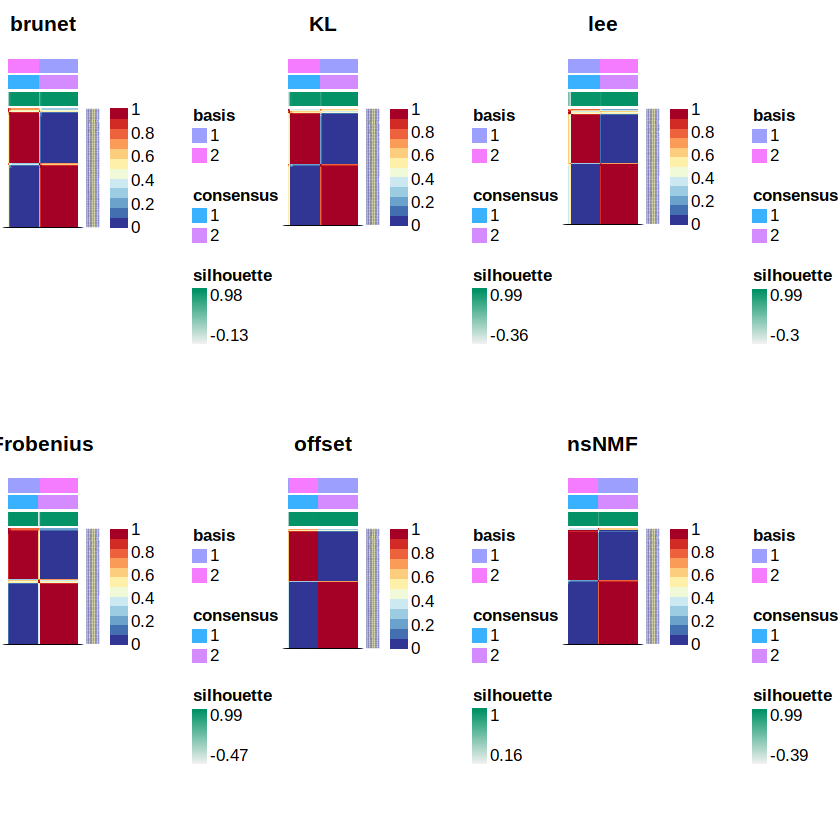

In [30]:
consensusmap(ucec_method_res)

In [467]:
ucec_consensus_plot_file <- file.path(paste(res_dir, 'algo_compare_consensus_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_consensus_plot_file, height = 9, width = 10, units = 'in', res=300)

# Print your heatmap
consensusmap(ucec_method_res)

# Close the PNG file:
dev.off()

png 
  2

## D. Analysis with best parameters

In [48]:
ucec_best_res = nmf_run(ucec_vst_data[ucec_top_mad_genes,], 2, method = 'offset', seed_meth ='random', n_run = 50)

In [49]:
ucec_best_res_summary <- t(as.data.frame(summary(ucec_best_res)))
#write.csv(t(ucec_best_res_summary),file=paste(res_dir,'best_res_summary.csv', sep=''),quote=F)
ucec_best_res_summary
#compare(ucec_best_res)

rank sparseness.basis sparseness.coef silhouette.coef
summary(ucec_best_res) 2    0.2274341        0.4215752       1              
                       silhouette.basis residuals niter cpu     cpu.all  nrun
summary(ucec_best_res) 1                472285    2000  199.945 7187.045 50  
                       cophenetic dispersion silhouette.consensus
summary(ucec_best_res) 0.9962261  0.9619898  0.984445

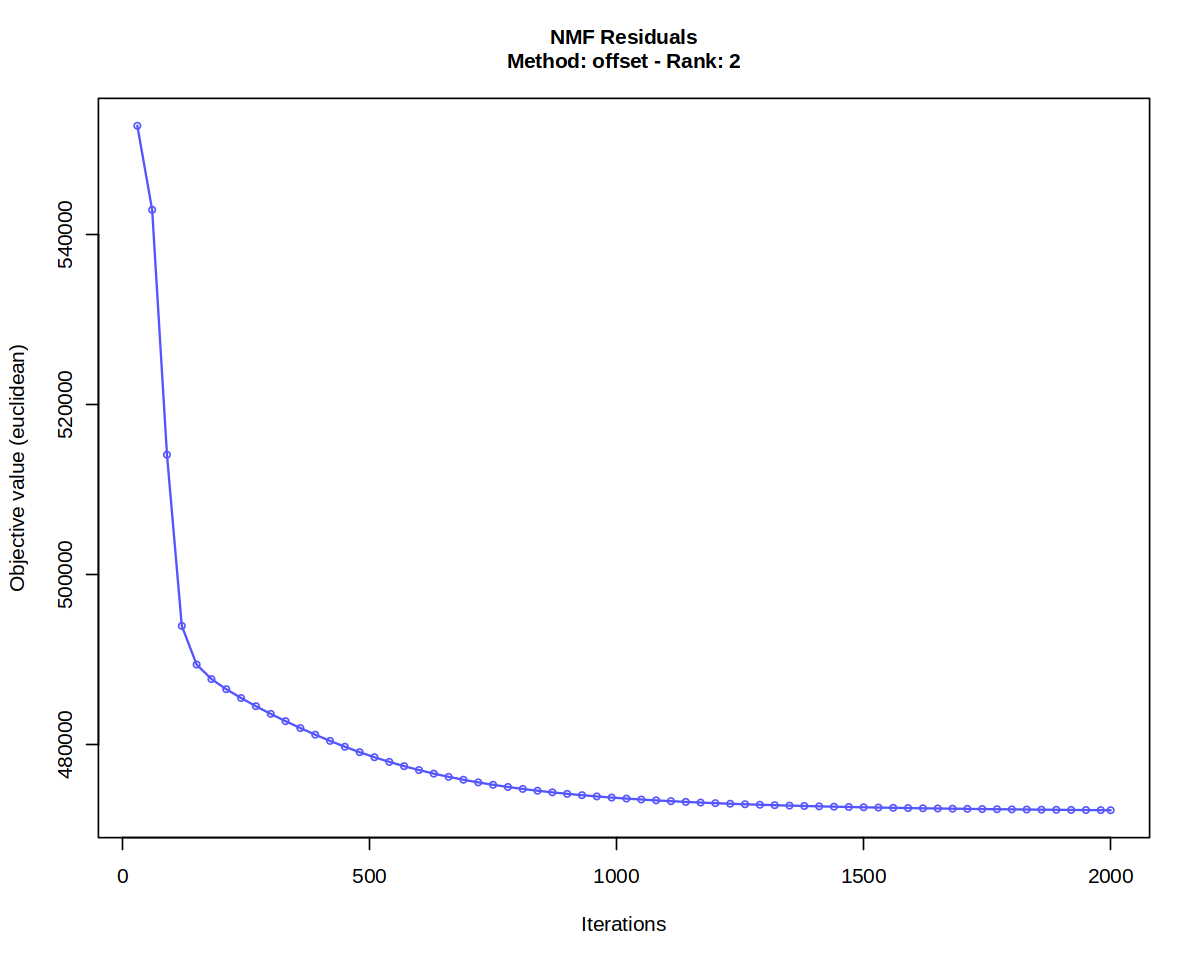

In [50]:
plot(ucec_best_res)


Cluster_1 Cluster_2 
      309       233 


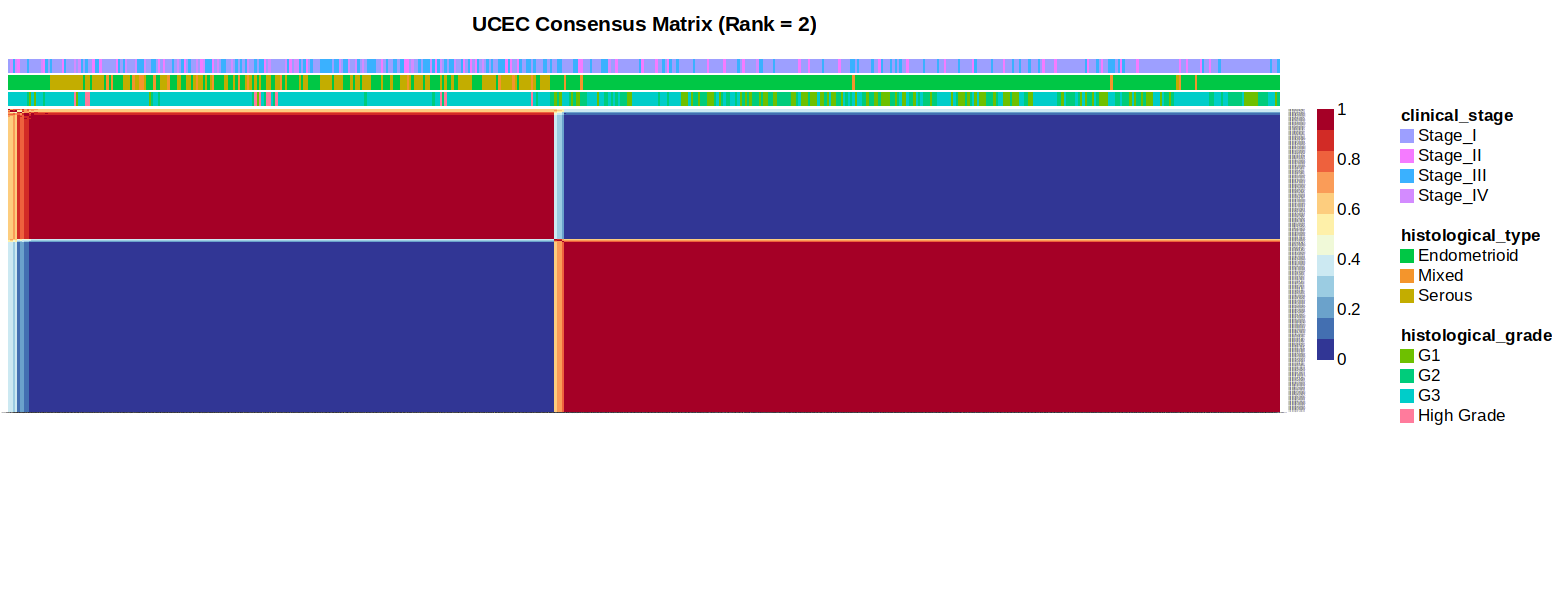

In [327]:
ucec_prim_clinical_data$nmf_cluster <- NA
ucec_prim_clinical_data$Subtypes <- NA
ucec_cp <- consensusmap(ucec_best_res, , annCol= ucec_clinical_data[colnames(ucec_prim_exp_data),
            ][c('clinical_stage', 'histological_type', 'histological_grade')], 
            main='UCEC Consensus Matrix (Rank = 2)', tracks =c(), Rowv = FALSE)

ucec_prim_clinical_data[colnames(ucec_vst_data[lapply(cut(ucec_cp$Rowv,0.5)$lower,
                                    function(l)rapply(l,function(i) i))[[1]]]),'nmf_cluster']<-'Cluster_1'
ucec_prim_clinical_data[colnames(ucec_vst_data[lapply(cut(ucec_cp$Rowv,0.5)$lower,
                                    function(l)rapply(l,function(i) i))[[2]]]),'nmf_cluster'] <- 'Cluster_2'
                                                      
ucec_prim_clinical_data[colnames(ucec_vst_data[lapply(cut(ucec_cp$Rowv,0.5)$lower,
                                    function(l)rapply(l,function(i) i))[[1]]]),'Subtypes']<-'Metabolic_subtype-1'
ucec_prim_clinical_data[colnames(ucec_vst_data[lapply(cut(ucec_cp$Rowv,0.5)$lower,
                                    function(l)rapply(l,function(i) i))[[2]]]),'Subtypes'] <-'Metabolic_subtype-2'
                                                                                                    

# write.csv(ucec_prim_clinical_data,file=paste(res_dir,'prim_clinical_cluster_assign_data.csv', sep=''),quote=F)

print(table(ucec_prim_clinical_data['nmf_cluster']))                                                           

In [328]:
print(table(ucec_prim_clinical_data['Subtypes']))          


Metabolic_subtype-1 Metabolic_subtype-2 
                309                 233 


In [254]:
m = matrix(rnorm(100), nrow = 10)
ha = rowAnnotation(foo = 1:10, show_legend = FALSE)
ht = Heatmap(m) + ha
lgd = color_mapping_legend(ha@anno_list[[1]]@color_mapping)
# you can also construct a Legend object by
lgd = Legend(title = "foo", 
    col_fun = circlize::colorRamp2(c(0, 10), c("white", "red")),
    at = seq(0, 10, by = 2))
draw(ht, annotation_legend_list = lgd, annotation_legend_side = "left")

ERROR: Error in rowAnnotation(foo = 1:10, show_legend = FALSE): could not find function "rowAnnotation"


In [260]:
old_hist_type = c("Endometrioid endometrial adenocarcinoma", "Serous endometrial adenocarcinoma", 
                  "Mixed serous and endometrioid" )
new_hist_type = c("Endometrioid", "Serous", "Mixed")
hist_map = setNames(new_hist_type, old_hist_type)
ucec_clinical_data$histological_type <- hist_map[ucec_clinical_data$histological_type]
print(dim(ucec_clinical_data))

[1] 565  13


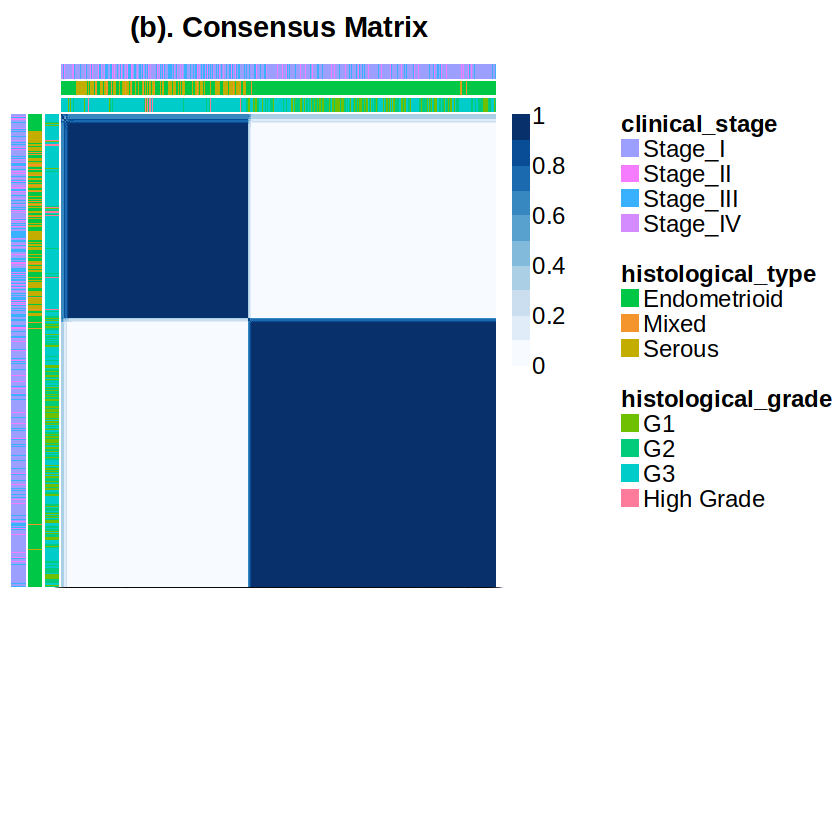

In [266]:
options(repr.plot.width = 7, repr.plot.height = 7)
consensusmap(ucec_best_res,
        annCol=ucec_clinical_data[colnames(ucec_prim_exp_data),][c('clinical_stage', 'histological_type', 'histological_grade')],
        annRow=ucec_clinical_data[colnames(ucec_prim_exp_data),][c('clinical_stage', 'histological_type', 'histological_grade')],
        main='(b). Consensus Matrix', 
        tracks=c(),
        info = FALSE,
        Rowv = FALSE,
        labRow = NA,
        color = "Blues",
        fontsize = 14
        )

In [33]:
ucec_best_consensus_plot_file <- file.path(paste(res_dir, 'best_consensus_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_best_consensus_plot_file, height = 6, width = 6, units = 'in', res= 300)

# Print your heatmap
consensusmap(ucec_best_res, annCol= ucec_clinical_data[colnames(ucec_prim_exp_data),][c('clinical_stage',
            'histological_type', 'histological_grade')], main='UCEC Consensus Plot', tracks =c(),
            Rowv = FALSE)

# Close the PNG file:
dev.off()

png 
  2

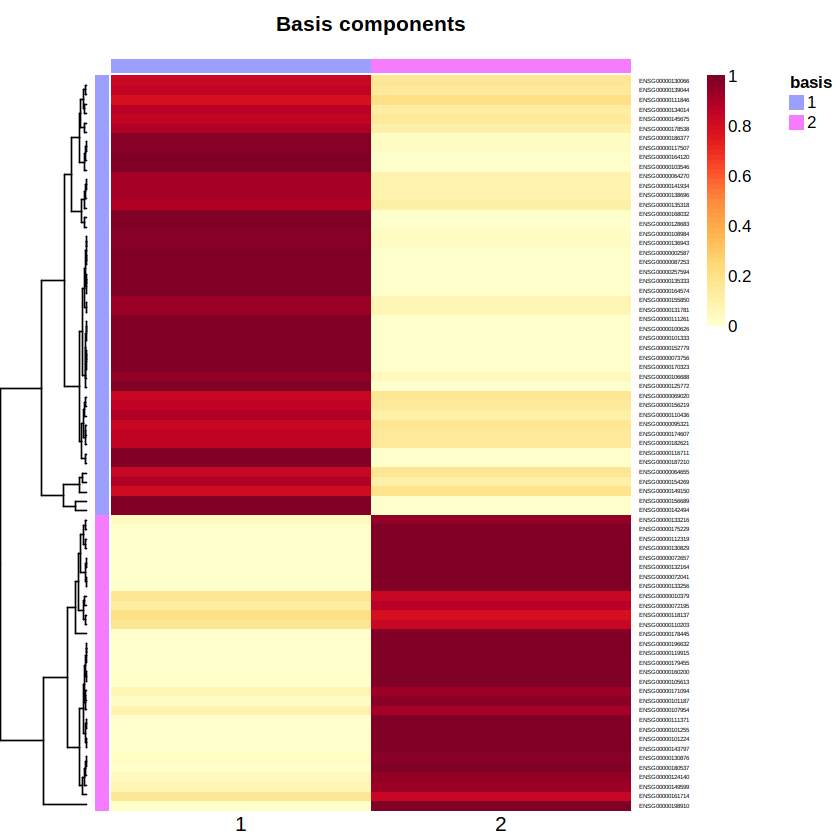

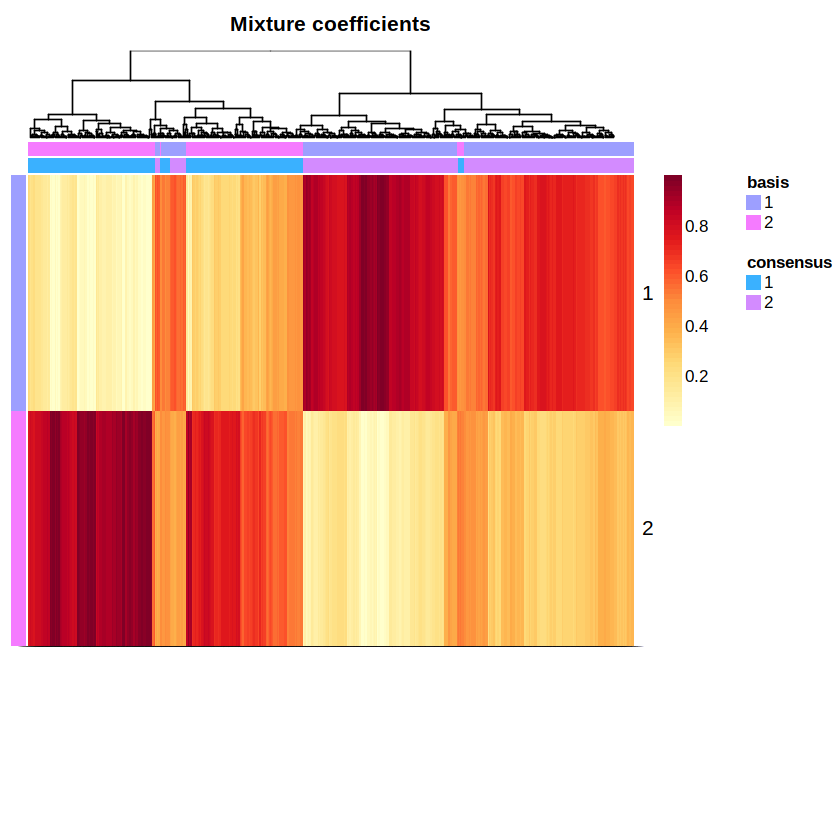

In [37]:
# basis components
basismap(ucec_best_res, subsetRow=TRUE)
# mixture coefficients
coefmap(ucec_best_res)

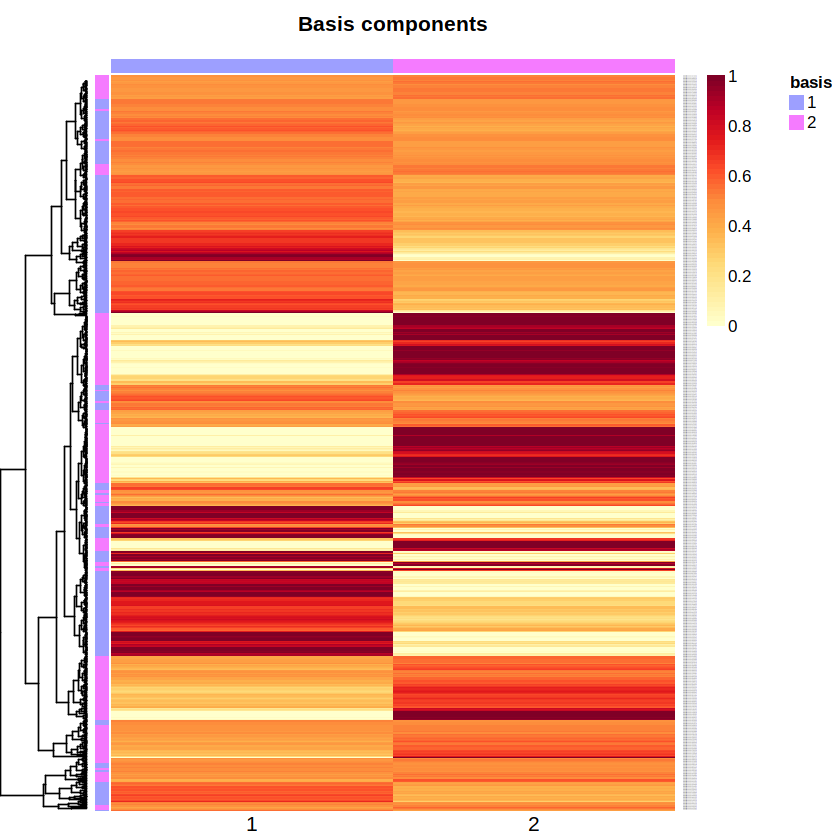

In [462]:
# basis components
basismap(ucec_best_res)

In [38]:
ucec_best_basis_plot_file <- file.path(paste(res_dir, 'best_basis_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_best_basis_plot_file, height = 6, width = 6, units = 'in', res=300)

# Print your heatmap
basismap(ucec_best_res, subsetRow=TRUE)

# Close the PNG file:
dev.off()

png 
  2

In [39]:
ucec_best_coef_plot_file <- file.path(paste(res_dir, 'best_coef_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_best_coef_plot_file, height = 6, width = 6, units = 'in', res=300)

# Print your heatmap
coefmap(ucec_best_res)

# Close the PNG file:
dev.off()

png 
  2

In [463]:
ucec_best_full_basis_plot_file <- file.path(paste(res_dir, 'best_full_basis_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_best_full_basis_plot_file, height = 6, width = 6, units = 'in', res=300)

# Print your heatmap
basismap(ucec_best_res)

# Close the PNG file:
dev.off()

png 
  2

# Survival Analysis

In [52]:
# Fitting the survival model
ucec_surv_fun = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ ucec_prim_clinical_data$nmf_cluster)
ucec_surv_fun

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    ucec_prim_clinical_data$nmf_cluster)

                                                n events median 0.95LCL 0.95UCL
ucec_prim_clinical_data$nmf_cluster=Cluster_1 309     32     NA    9.38      NA
ucec_prim_clinical_data$nmf_cluster=Cluster_2 233     59   8.91    8.53      NA

In [53]:
#summary(ucec_surv_fun)
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ ucec_prim_clinical_data$nmf_cluster)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ ucec_prim_clinical_data$nmf_cluster)

                                                N Observed Expected (O-E)^2/E
ucec_prim_clinical_data$nmf_cluster=Cluster_1 309       32     53.9      8.87
ucec_prim_clinical_data$nmf_cluster=Cluster_2 233       59     37.1     12.86
                                              (O-E)^2/V
ucec_prim_clinical_data$nmf_cluster=Cluster_1      21.9
ucec_prim_clinical_data$nmf_cluster=Cluster_2      21.9

 Chisq= 21.9  on 1 degrees of freedom, p= 3e-06 

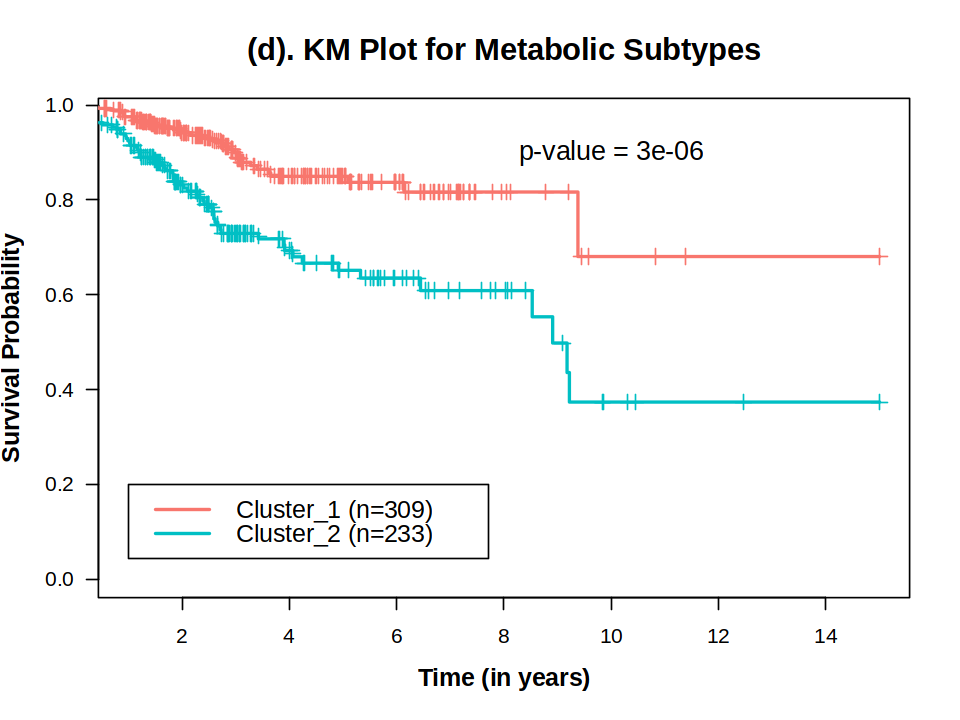

In [270]:
options(repr.plot.width = 8, repr.plot.height = 6)
par (cex.lab = "1.2", cex.main = "1.5")
plot(ucec_surv_fun, 
     main = "(d). KM Plot for Metabolic Subtypes", 
     xlim = c(1,15), 
     xlab = substitute(paste(bold('Time (in years)'))) , 
     ylab = substitute(paste(bold('Survival Probability'))), 
     col = c("#F8766D", "#00BFC4"), 
     las= 1, 
     lwd = 2,  
     mark.time = TRUE, 
     cex=1.2)
legend(1, 0.2, legend = c('Cluster_1 (n=309)', 'Cluster_2 (n=233)'),lwd = 2, col = c("#F8766D", "#00BFC4"), bty = '', cex = 1.2)
text(10, 0.9,  'p-value = 3e-06', cex=1.3) 

In [194]:
#ucec_survival_plot_file <- file.path(paste(res_dir, 'survival_plot.tiff', sep =''))
ucec_survival_plot_file <- file.path(paste(res_dir, 'revision/survival_plot.tiff', sep =''))


# Open a PNG file - width and height arguments control the size of the output
tiff(ucec_survival_plot_file, height = 6, width = 6, units = 'in', res= 300)

# Print your heatmap
plot(ucec_surv_fun, 
     main = "KM Plot for UCEC Metabolic Subtypes", 
     xlim = c(1,15), 
     xlab = substitute(paste(bold('Time (in years)'))) , 
     ylab = substitute(paste(bold('Survival Probability'))), 
     col = c("#F8766D", "#00BFC4"), 
     las= 1, 
     lwd = 2,  
     mark.time = TRUE, 
     cex=1.2)
legend(1, 0.2, legend = c('Cluster_1 (n=309)', 'Cluster_2 (n=233)'),lwd = 2, col = c("#F8766D", "#00BFC4"), bty = '', cex = 1.2)
text(10, 0.9,  'p-value = 3e-06', cex=1.3) 

# Close the PNG file:
dev.off()

png 
  2

In [44]:
#hist(ucec_prim_clinical_data$OS.time)
#table(ucec_prim_clinical_data$OS.time)
#hist(ucec_prim_clinical_data$age_at_initial_pathologic_diagnosis)


## Association with Clinical Variables (Stage, Histological type, Grade and Age)

Cramer's V varies between 0 and 1. Close to 0 it shows little association between variables. Close to 1, it indicates a 
strong association.

#### Clinical Stage

In [329]:
#stage_ct <- as.matrix(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster))
stage_ct <- as.matrix(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$Subtypes))
stage_ct[,1] <- (stage_ct[,1]*100)/sum(stage_ct[,1])
stage_ct[,2] <- (stage_ct[,2]*100)/sum(stage_ct[,2])
stage_ct

           
            Metabolic_subtype-1 Metabolic_subtype-2
  Stage_I            75.7281553          44.6351931
  Stage_II            8.7378641          10.3004292
  Stage_III          14.8867314          33.4763948
  Stage_IV            0.6472492          11.5879828

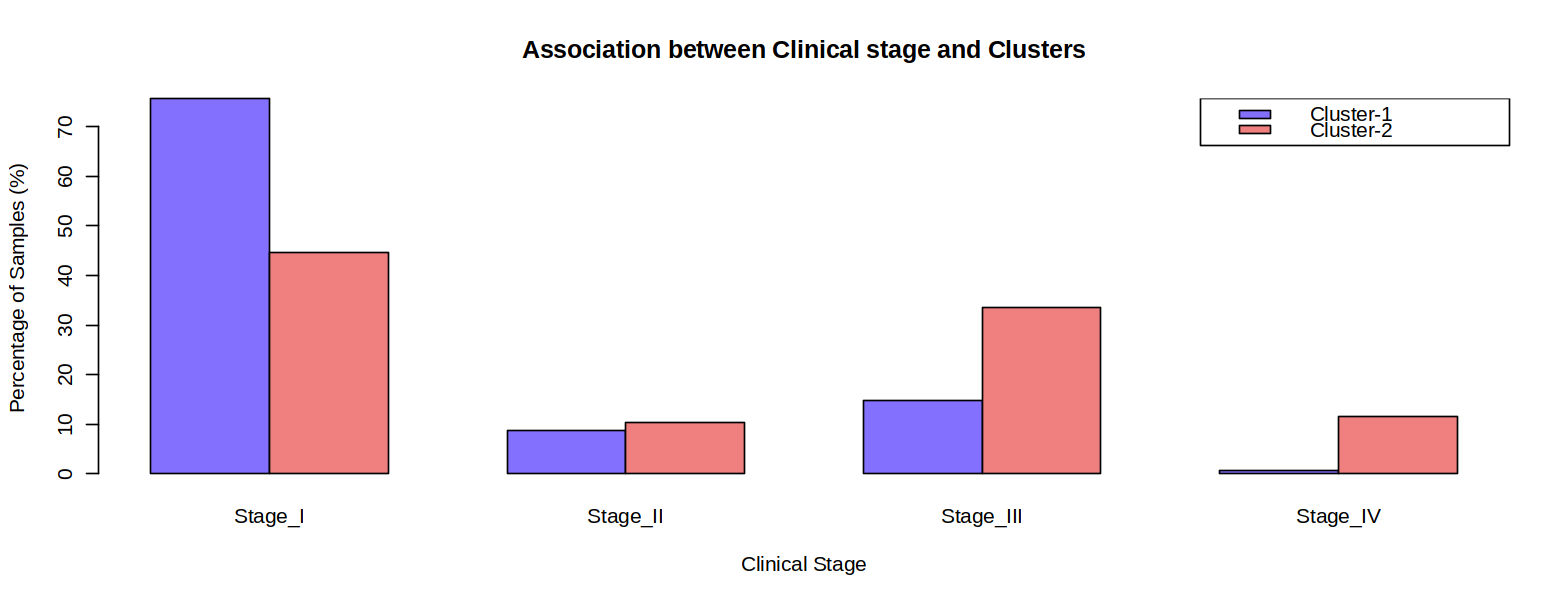

In [330]:
barplot(t(stage_ct), beside = TRUE, xlab = "Clinical Stage", ylab = "Percentage of Samples (%)", 
        main = "Association between Clinical stage and Clusters", col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

In [83]:
stage_barplot_file <- file.path(paste(res_dir, 'barplots/stage_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(stage_barplot_file, height = 6, width = 6, units = 'in', res=600)


# Print your heatmap
barplot(t(stage_ct), beside = TRUE, xlab = "Clinical Stage", ylab = "Percentage of Samples (%)", 
        main = "Association between Clinical stage and Clusters", col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

# Close the PNG file:
dev.off()

png 
  2

In [253]:
ucec_stage_f_test <-fisher.test(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster))
print(ucec_stage_f_test)

stage_cramer <- assocstats(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster))
stage_cramer


	Fisher's Exact Test for Count Data

data:  table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster)
p-value = 4.117e-16
alternative hypothesis: two.sided



                    X^2 df   P(> X^2)
Likelihood Ratio 74.796  3 4.4409e-16
Pearson          70.720  3 2.9976e-15

Phi-Coefficient   : NA 
Contingency Coeff.: 0.34 
Cramer's V        : 0.361 

In [254]:
ucec_stage_test <- chisq.test(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster))
ucec_stage_test

# plot
#ggbarstats(data = ucec_prim_clinical_data,
#           x = clinical_stage,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Clinical Stage\n',
#           cex = 2.5) + labs(caption = NULL) 

# Save the plot
#ucec_chisq_stage_plot_file <- file.path(paste(res_dir, 'chi_sq_test_stage_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
#tiff(ucec_chisq_stage_plot_file, height = 6, width = 6, units = 'in', res=300)


# Print your heatmap
#ggbarstats(data = ucec_prim_clinical_data,
#           x = clinical_stage,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Clinical Stage\n',
#           cex = 2.5, 
#          ) + labs(caption = NULL) # remove caption

# Close the PNG file:
#dev.off()


	Pearson's Chi-squared test

data:  table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster)
X-squared = 70.72, df = 3, p-value = 2.993e-15


In [255]:
# Other functions for pearson chi-square test
# 1. summary(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster))
# 2. assocstats(table(ucec_prim_clinical_data$clinical_stage, ucec_prim_clinical_data$nmf_cluster)) - gives cramer's V

# Mosaic Plot
#mosaic(~ clinical_stage + nmf_cluster,
#  direction = c("v", "h"),
#  data = ucec_prim_clinical_data,
#  shade = TRUE
#)

#### Histological Type

In [331]:
#type_ct <- as.matrix(table(ucec_prim_clinical_data$histological_type, 
#                           ucec_prim_clinical_data$nmf_cluster))
type_ct <- as.matrix(table(ucec_prim_clinical_data$histological_type, 
                           ucec_prim_clinical_data$Subtypes))
type_ct[,1] <- (type_ct[,1]*100)/sum(type_ct[,1])
type_ct[,2] <- (type_ct[,2]*100)/sum(type_ct[,2])
rownames(type_ct) <- c("Endometrioid", "Mixed", "Serous")
type_ct

              
               Metabolic_subtype-1 Metabolic_subtype-2
  Endometrioid          97.7346278          44.6351931
  Mixed                  1.9417476           6.8669528
  Serous                 0.3236246          48.4978541

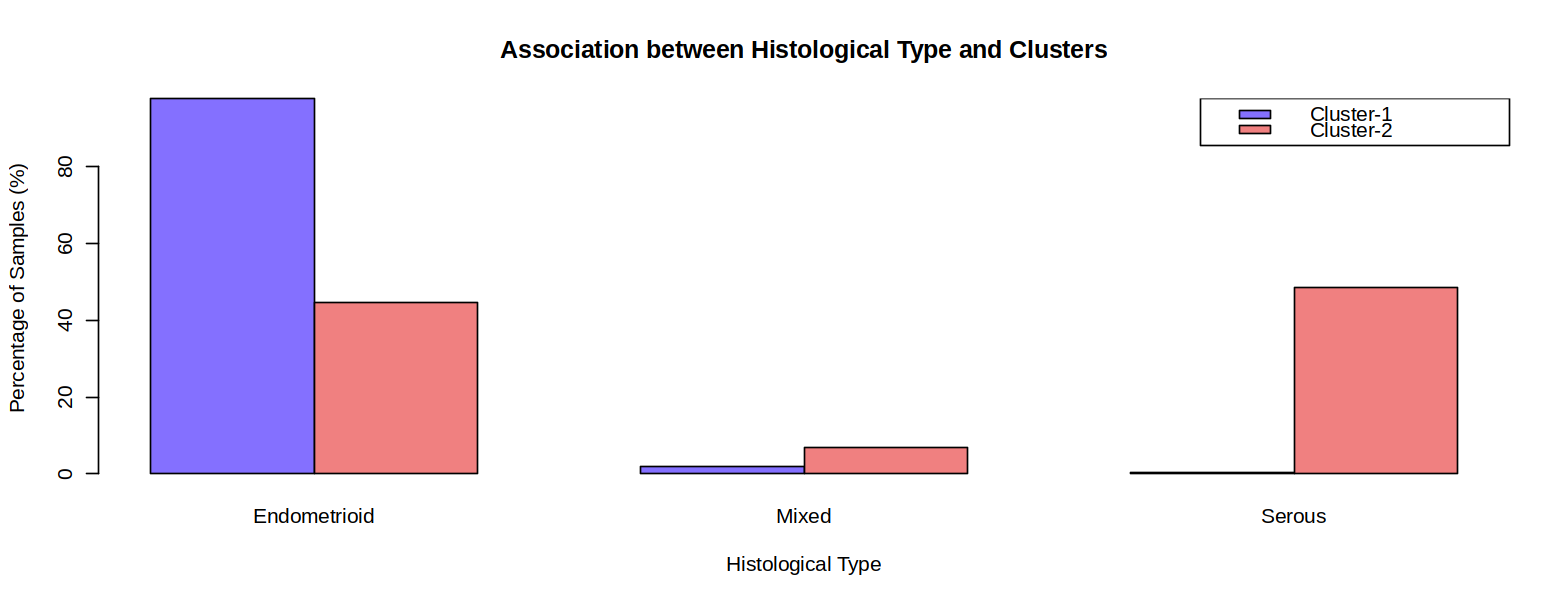

In [332]:
barplot(t(type_ct), beside = TRUE, xlab = "Histological Type", 
        ylab = "Percentage of Samples (%)", 
        main = "Association between Histological Type and Clusters", 
        col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

In [88]:
type_barplot_file <- file.path(paste(res_dir, 'barplots/type_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(type_barplot_file, height = 6, width = 6, units = 'in', res=600)

# Print your heatmap
barplot(t(type_ct), beside = TRUE, xlab = "Histological Type", ylab = "Percentage of Samples (%)", 
        main = "Association between Histological Type and Clusters", col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080"))  

# Close the PNG file:
dev.off()

png 
  2

In [258]:
ucec_hist_type_f_test <- fisher.test(table(ucec_prim_clinical_data$histological_type, 
                                           ucec_prim_clinical_data$nmf_cluster))
print(ucec_hist_type_f_test)

assocstats(table(ucec_prim_clinical_data$histological_type, ucec_prim_clinical_data$nmf_cluster))


	Fisher's Exact Test for Count Data

data:  table(ucec_prim_clinical_data$histological_type, ucec_prim_clinical_data$nmf_cluster)
p-value < 2.2e-16
alternative hypothesis: two.sided



                    X^2 df P(> X^2)
Likelihood Ratio 241.41  2        0
Pearson          204.51  2        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.523 
Cramer's V        : 0.614 

In [259]:
ucec_hist_type_test <- chisq.test(table(ucec_prim_clinical_data$histological_type, 
                                        ucec_prim_clinical_data$nmf_cluster))
ucec_hist_type_test

# plot
#ggbarstats(data = ucec_prim_clinical_data,
#           x = histological_type,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Histological Type\n',
#           cex = 2.5, 
#          ) + labs(caption = NULL) # remove caption

#ucec_chisq_hist_type_plot_file <- file.path(paste(res_dir, 'chi_sq_test_hist_type_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
#tiff(ucec_chisq_hist_type_plot_file, height = 6, width = 6, units = 'in', res=300)


# Print your heatmap
#ggbarstats(data = ucec_prim_clinical_data,
#           x = histological_type,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Histological Type\n',
#           cex = 2.5, 
#          ) + labs(caption = NULL) # remove caption

# Close the PNG file:
#dev.off()


	Pearson's Chi-squared test

data:  table(ucec_prim_clinical_data$histological_type, ucec_prim_clinical_data$nmf_cluster)
X-squared = 204.51, df = 2, p-value < 2.2e-16


#### Grade

In [333]:
#grade_ct <- as.matrix(table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster))
grade_ct <- as.matrix(table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$Subtypes))
grade_ct[,1] <- (grade_ct[,1]*100)/sum(grade_ct[,1])
grade_ct[,2] <- (grade_ct[,2]*100)/sum(grade_ct[,2])
grade_ct

            
             Metabolic_subtype-1 Metabolic_subtype-2
  G1                   30.097087            2.145923
  G2                   34.627832            5.579399
  G3                   35.275081           87.553648
  High Grade            0.000000            4.721030

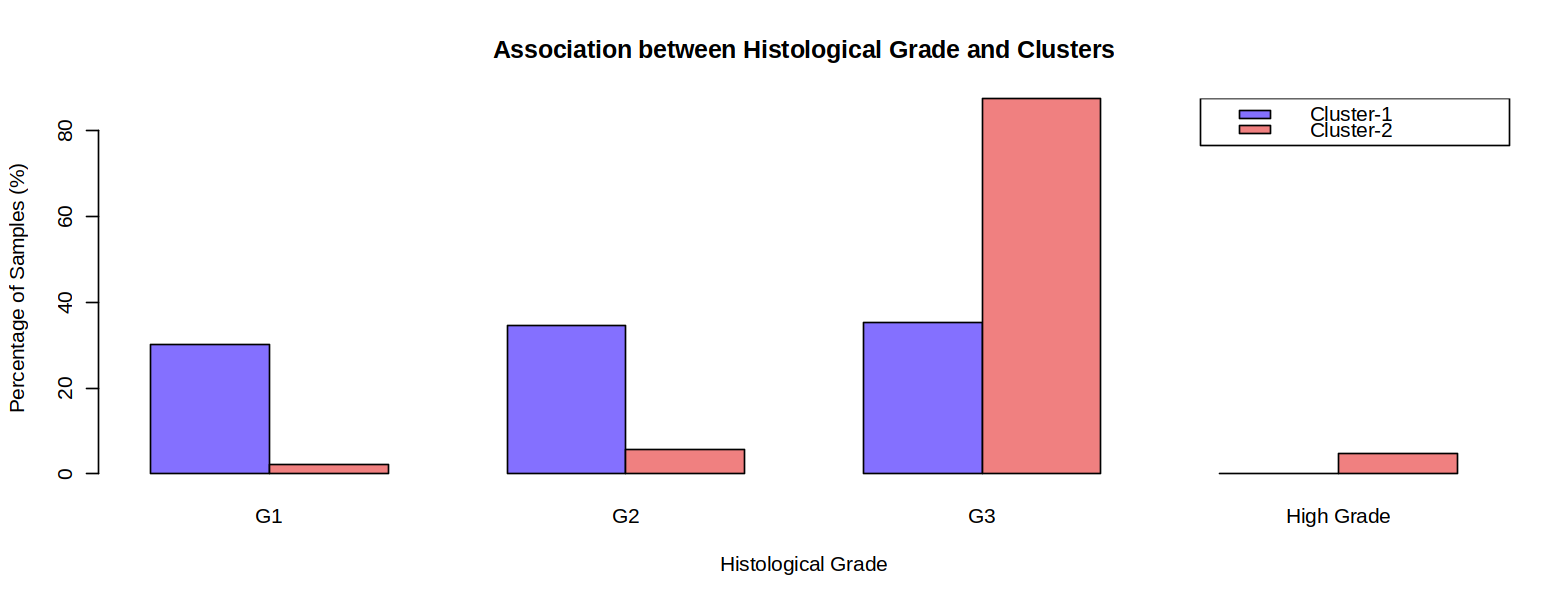

In [334]:
barplot(t(grade_ct), beside = TRUE, xlab = "Histological Grade", ylab = "Percentage of Samples (%)", 
        main = "Association between Histological Grade and Clusters", col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

In [93]:
grade_barplot_file <- file.path(paste(res_dir, 'barplots/grade_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(grade_barplot_file, height = 6, width = 6, units = 'in', res=600)

# Print your heatmap
barplot(t(grade_ct), beside = TRUE, xlab = "Histological Grade", ylab = "Percentage of Samples (%)", 
        main = "Association between Histological Grade and Clusters", col = c("#8470FF", "#F08080")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

# Close the PNG file:
dev.off()

png 
  2

In [262]:
ucec_grade_f_test <- fisher.test(table(ucec_prim_clinical_data$histological_grade, 
                                       ucec_prim_clinical_data$nmf_cluster))
print(ucec_grade_f_test)

assocstats(table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster))


	Fisher's Exact Test for Count Data

data:  table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster)
p-value < 2.2e-16
alternative hypothesis: two.sided



                    X^2 df P(> X^2)
Likelihood Ratio 214.24  3        0
Pearson          185.48  3        0

Phi-Coefficient   : NA 
Contingency Coeff.: 0.505 
Cramer's V        : 0.585 

In [263]:
ucec_grade_test <- chisq.test(table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster))
ucec_grade_test

# combine plot and statistical test with ggbarstats
#ucec_cv <- assocstats(table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster))
#ggbarstats(
#    ucec_prim_clinical_data, histological_grade, nmf_cluster,
#    results.subtitle = FALSE,
#    title = "Fisher's exact test\n",
#    subtitle = paste0("p-value = ", ucec_grade_f_test$p.value, "\n\nCramer's V = ", ucec_cv$cramer),
#    cex = 2.5)

#ucec_chisq_grade_plot_file <- file.path(paste(res_dir, 'chi_sq_test_grade_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
#png(ucec_chisq_grade_plot_file, width = 600, height = 600)
#tiff(ucec_chisq_grade_plot_file, height = 6, width = 6, units = 'in', res=300)


# Print your heatmap
#ggbarstats(
#    ucec_prim_clinical_data, histological_grade, nmf_cluster,
#    results.subtitle = FALSE,
#   title = "Fisher's exact test\n",
#    subtitle = paste0("p-value = ", ucec_grade_f_test$p.value, "\n\nCramer's V = ", ucec_cv$cramer),
#    cex = 2.5)

# Close the PNG file:
#dev.off()

Warning message in chisq.test(table(ucec_prim_clinical_data$histological_grade, :
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table(ucec_prim_clinical_data$histological_grade, ucec_prim_clinical_data$nmf_cluster)
X-squared = 185.48, df = 3, p-value < 2.2e-16


#### Age

In [335]:
ucec_prim_clinical_data$age <- ifelse(ucec_prim_clinical_data$age_at_initial_pathologic_diagnosis < 50,
  "<50", ">=50"
)
print(table(ucec_prim_clinical_data$age))
#print(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster))
#age_ct <- as.matrix(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster))
age_ct <- as.matrix(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$Subtypes))
age_ct[,1] <- (age_ct[,1]*100)/sum(age_ct[,1])
age_ct[,2] <- (age_ct[,2]*100)/sum(age_ct[,2])
age_ct


 <50 >=50 
  45  495 


      
       Metabolic_subtype-1 Metabolic_subtype-2
  <50            10.679612            5.194805
  >=50           89.320388           94.805195

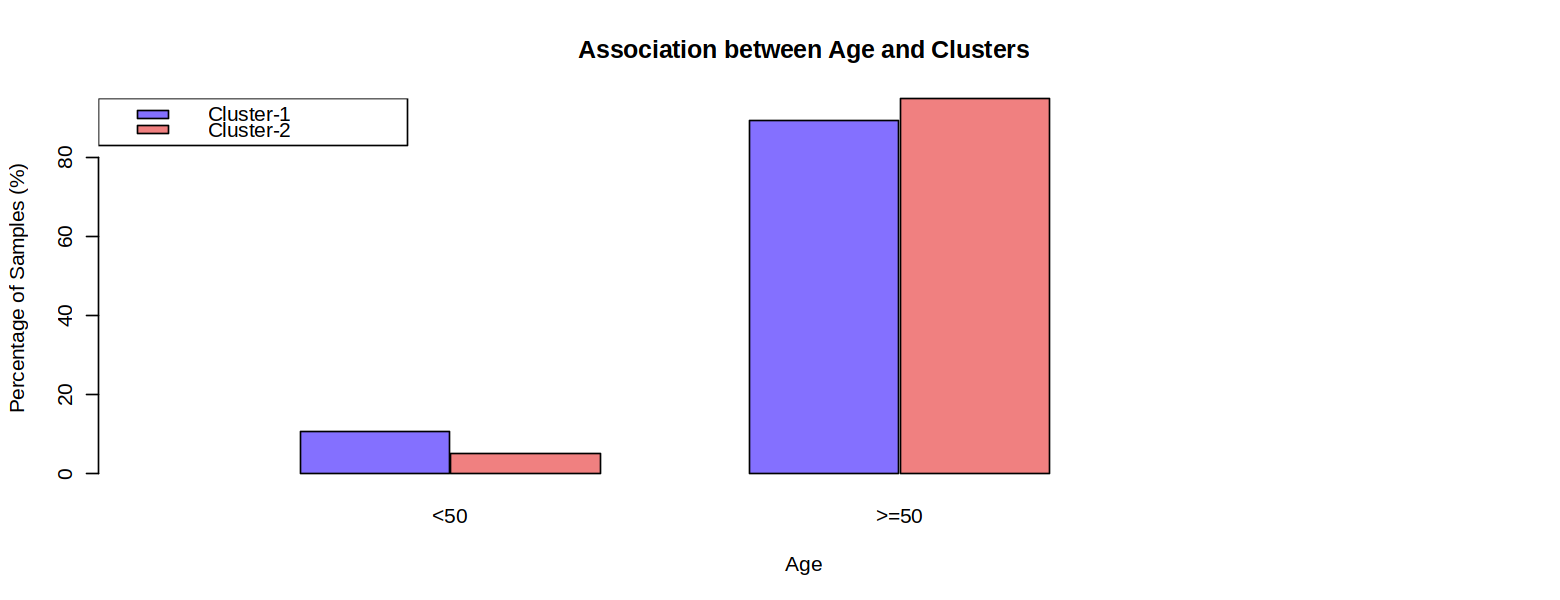

In [336]:
barplot(t(age_ct), beside = TRUE, xlab = "Age", ylab = "Percentage of Samples (%)", 
        main = "Association between Age and Clusters", col = c("#8470FF", "#F08080"),
        width = c(0.08), space = c(0.01, 1), xlim = c(0, 0.7)) 
legend("topleft", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

In [111]:
age_barplot_file <- file.path(paste(res_dir, 'barplots/age_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(age_barplot_file, height = 6, width = 6, units = 'in', res=600)

# Print your heatmap
barplot(t(age_ct), beside = TRUE, xlab = "Age", ylab = "Percentage of Samples (%)", 
        main = "Association between Age and Clusters", col = c("#8470FF", "#F08080"),
        width = c(0.08), space = c(0.01, 1), xlim = c(0, 0.7)) 
legend("topleft", c("Cluster-1", "Cluster-2"), fill = c("#8470FF", "#F08080")) 

# Close the PNG file:
dev.off()

png 
  2

In [393]:
# (bottom, left, top, and right.)
# par(mar = c(4, 4, 0.1, 0.5))  

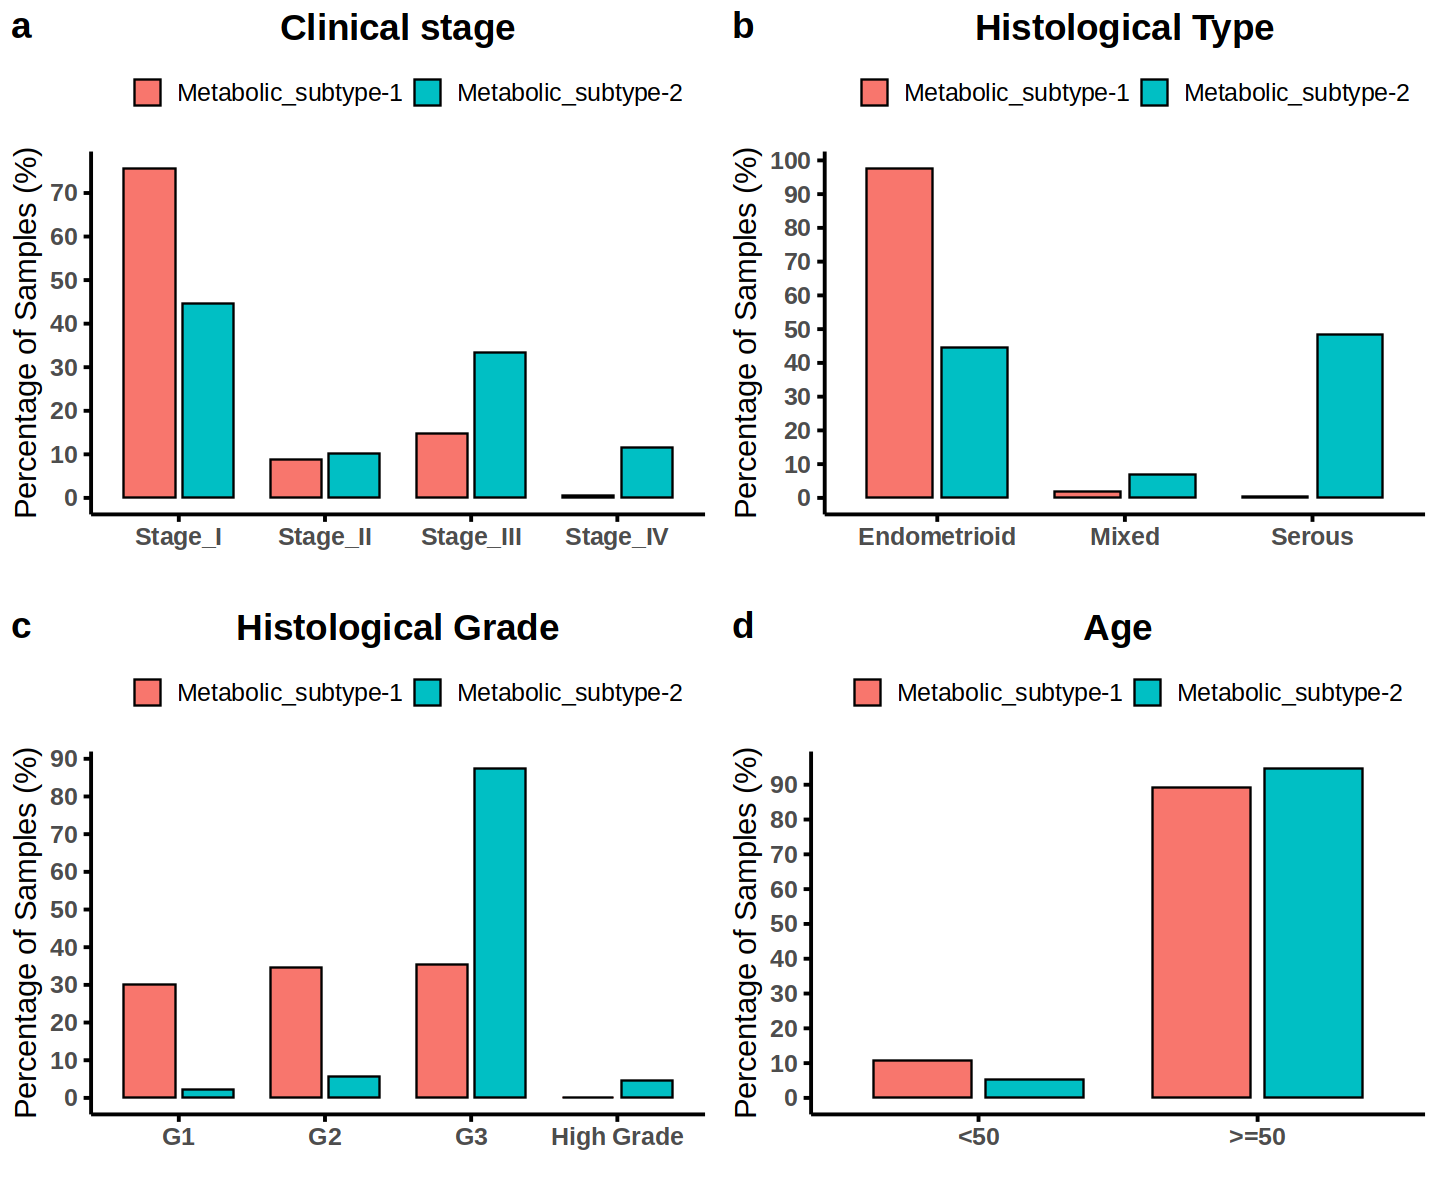

In [379]:

stage_ct_df <- as.data.frame(stage_ct)
colnames(stage_ct_df) <- c("clinical_stages", "Clusters", "Percentage")
stage_bar <- ggbarplot(stage_ct_df, x = "clinical_stages", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Clinical stage", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10)) 

type_ct_df <- as.data.frame(type_ct)
colnames(type_ct_df) <- c("histological_types", "Clusters", "Percentage")
type_bar  <-  ggbarplot(type_ct_df, x = "histological_types", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Histological Type", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

grade_ct_df <- as.data.frame(grade_ct)
colnames(grade_ct_df) <- c("histological_grades", "Clusters", "Percentage")
grade_bar  <-  ggbarplot(grade_ct_df, x = "histological_grades", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Histological Grade", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

age_ct_df <- as.data.frame(age_ct)
colnames(age_ct_df) <- c("Ages", "Clusters", "Percentage")
age_bar  <-  ggbarplot(age_ct_df, x = "Ages", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Age", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

options(repr.plot.width = 12, repr.plot.height = 10)
clinical_barplot <- ggarrange(stage_bar, type_bar,  grade_bar, age_bar,
          labels = c("a", "b", "c", "d"), font.label = list(size = 22),
          ncol = 2, nrow = 2) 
clinical_barplot

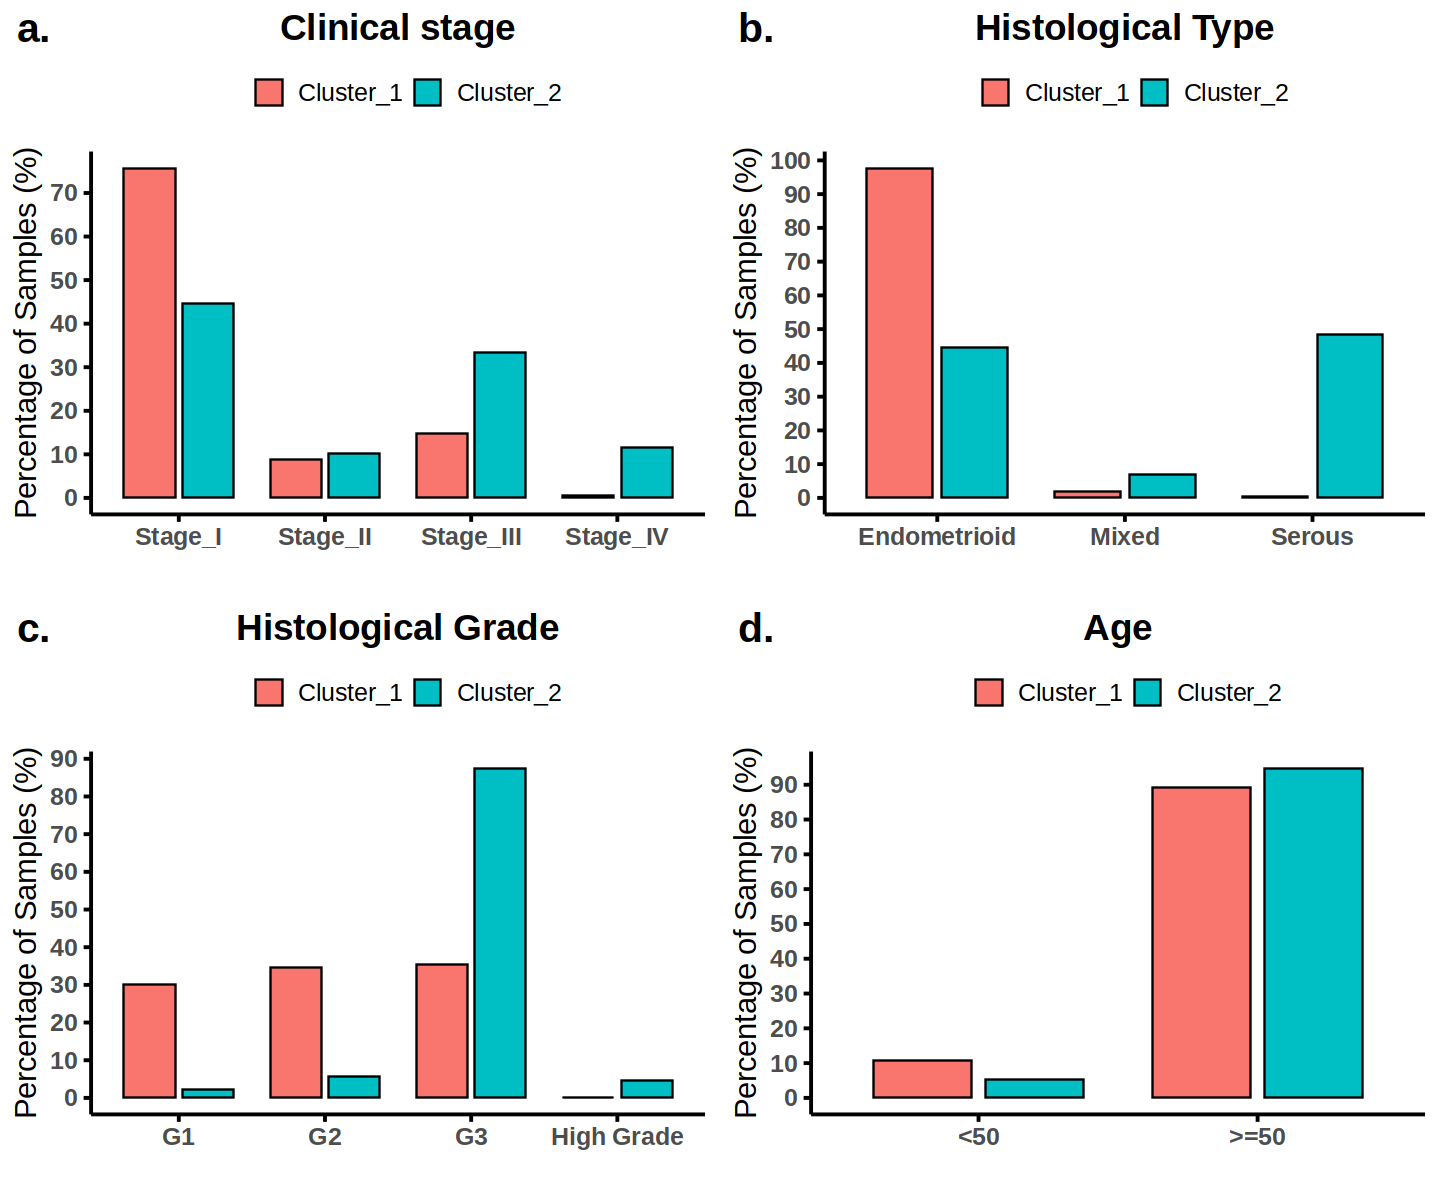

In [177]:
library(ggpubr)

stage_ct_df <- as.data.frame(stage_ct)
colnames(stage_ct_df) <- c("clinical_stages", "Clusters", "Percentage")
stage_bar <- ggbarplot(stage_ct_df, x = "clinical_stages", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Clinical stage", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10)) 

type_ct_df <- as.data.frame(type_ct)
colnames(type_ct_df) <- c("histological_types", "Clusters", "Percentage")
type_bar  <-  ggbarplot(type_ct_df, x = "histological_types", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Histological Type", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

grade_ct_df <- as.data.frame(grade_ct)
colnames(grade_ct_df) <- c("histological_grades", "Clusters", "Percentage")
grade_bar  <-  ggbarplot(grade_ct_df, x = "histological_grades", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Histological Grade", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

age_ct_df <- as.data.frame(age_ct)
colnames(age_ct_df) <- c("Ages", "Clusters", "Percentage")
age_bar  <-  ggbarplot(age_ct_df, x = "Ages", y = "Percentage", fill = "Clusters", label = FALSE,  
          position = position_dodge(0.8),
          ylab = "Percentage of Samples (%)", xlab = "", title = "Age", 
          ggtheme = theme_classic(base_size = 18), legend = "top") +
          theme(plot.title = element_text(hjust = 0.5, face="bold"), 
                axis.text = element_text(face="bold"), 
                legend.title=element_blank())  +
          scale_y_continuous(breaks=seq(0, 100, 10))

options(repr.plot.width = 12, repr.plot.height = 10)
clinical_barplot <- ggarrange(stage_bar, type_bar,  grade_bar, age_bar,
          labels = c("a.", "b.", "c.", "d."), font.label = list(size = 24),
          ncol = 2, nrow = 2) 
clinical_barplot

In [380]:
clinical_barplot_file <- file.path(paste(res_dir, 'revision/clinical_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(clinical_barplot_file, height = 10, width = 12, units = 'in', res=300)

# Print your heatmap
clinical_barplot

# Close the PNG file:
dev.off()

png 
  2

NULL

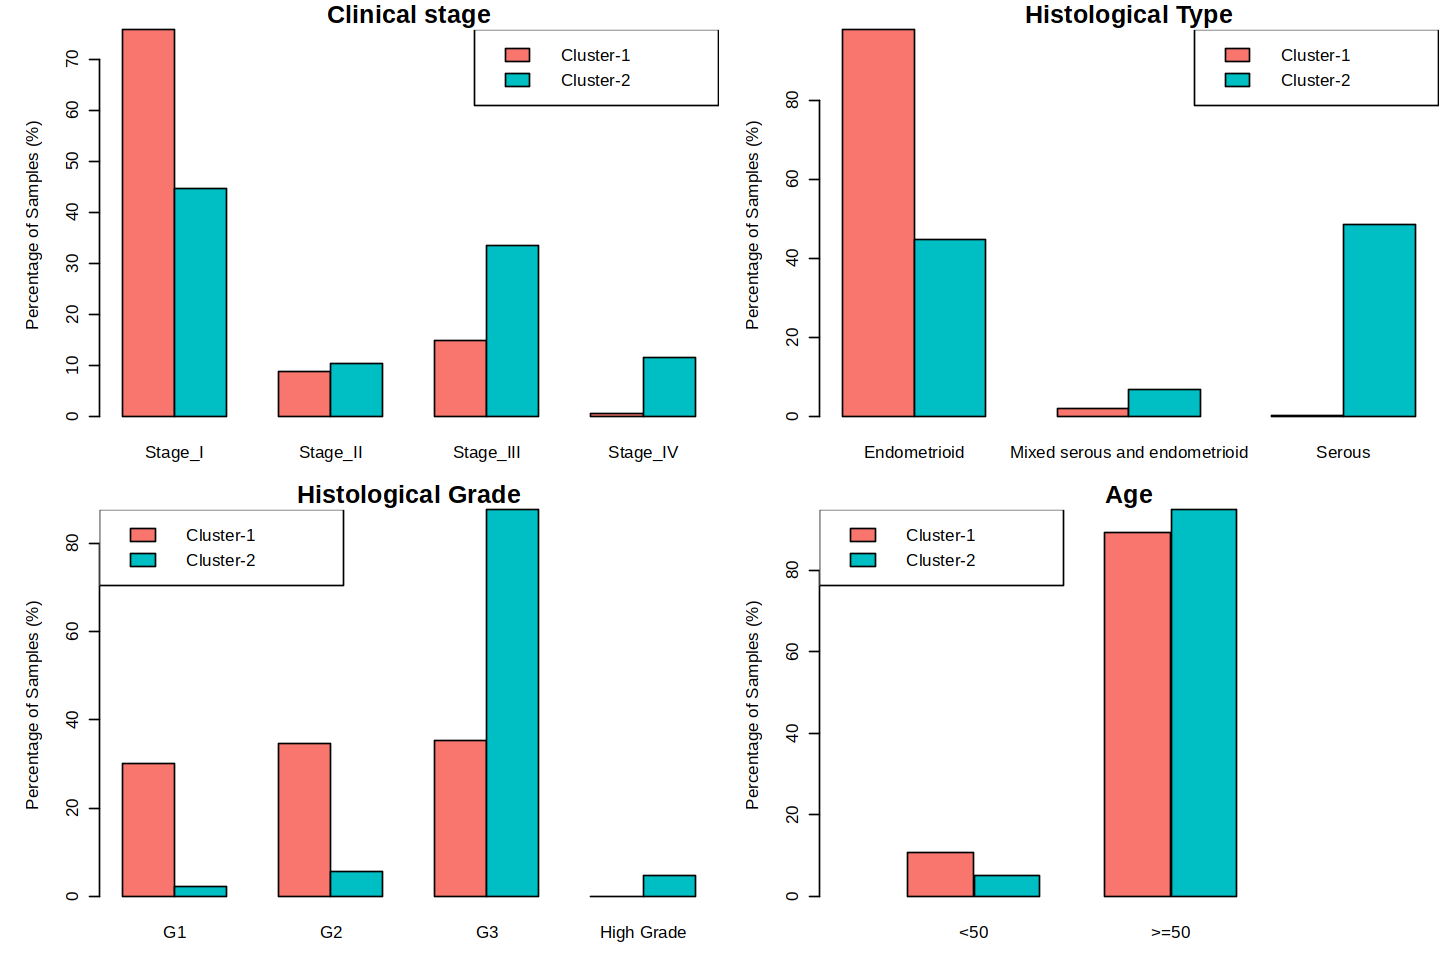

In [68]:
options(repr.plot.width = 12, repr.plot.height = 8)
par(mar = c(3, 5, 1.5, 0.1)) 
par(mfrow=c(2,2), cex.main= 1.5 )
barplot(t(stage_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Clinical stage", col = c("#F8766D", "#00BFC4")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 

barplot(t(type_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Histological Type", col = c("#F8766D", "#00BFC4")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4"))  


barplot(t(grade_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Histological Grade", col = c("#F8766D", "#00BFC4")) 
legend("topleft", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 


barplot(t(age_ct), beside = TRUE,  ylab = "Percentage of Samples (%)", 
        main = "Age", col = c("#F8766D", "#00BFC4"),
        width = c(0.08), space = c(0.01, 1), xlim = c(0, 0.7)) 
legend("topleft", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 

In [405]:
combined_clinical_barplot_file <- file.path(paste(res_dir, 'barplots/combined_clinical_barplot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(combined_clinical_barplot_file, height = 6, width = 9, units = 'in', res= 300)

# Print your heatmap
par(mar = c(3, 5, 1.5, 0.1)) 
par(mfrow=c(2,2), cex.main= 1.5 )
barplot(t(stage_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Clinical stage", col = c("#F8766D", "#00BFC4")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 


barplot(t(type_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Histological Type", col = c("#F8766D", "#00BFC4")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4"))  


barplot(t(grade_ct), beside = TRUE, ylab = "Percentage of Samples (%)", 
        main = "Histological Grade", col = c("#F8766D", "#00BFC4")) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 

barplot(t(age_ct), beside = TRUE,  ylab = "Percentage of Samples (%)", 
        main = "Age", col = c("#F8766D", "#00BFC4"),
        width = c(0.08), space = c(0.01, 1), xlim = c(0, 0.7)) 
legend("topright", c("Cluster-1", "Cluster-2"), fill = c("#F8766D", "#00BFC4")) 

# Close the PNG file:
dev.off()

png 
  2

In [105]:
ucec_age_f_test <- fisher.test(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster))
print(ucec_age_f_test)

assocstats(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster))


	Fisher's Exact Test for Count Data

data:  table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster)
p-value = 0.02696
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.066331 4.748456
sample estimates:
odds ratio 
  2.179067 



                    X^2 df P(> X^2)
Likelihood Ratio 5.4629  1 0.019424
Pearson          5.2056  1 0.022515

Phi-Coefficient   : 0.098 
Contingency Coeff.: 0.098 
Cramer's V        : 0.098 

In [101]:
ucec_age_test <- chisq.test(table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster))
ucec_age_test

# plot
#ggbarstats(data = ucec_prim_clinical_data,
#           x = age,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Age\n',
#           cex = 2.5, 
#          ) + labs(caption = NULL) # remove caption

#ucec_chisq_age_plot_file <- file.path(paste(res_dir, 'chi_sq_test_age_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
#tiff(ucec_chisq_age_plot_file, height = 6, width = 6, units = 'in', res=300)


# Print your heatmap
#ggbarstats(data = ucec_prim_clinical_data,
#           x = age,
#           y = nmf_cluster, 
#           title = 'Pearsons chi-square test between NMF Clusters & Age\n',
#           cex = 2.5, 
#          ) + labs(caption = NULL) 

# Close the PNG file:
#dev.off()


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(ucec_prim_clinical_data$age, ucec_prim_clinical_data$nmf_cluster)
X-squared = 3.0145, df = 1, p-value = 0.08252


# Feature Extraction for Endometrial Cancer

In [68]:
W = ucec_best_res@fit@W
H = ucec_best_res@fit@H
print(dim(W))
print(dim(H))

[1] 1000    2
[1]   2 542


In [69]:
# only compute the scores
ucec_best_res_feat_score <- featureScore(ucec_best_res)
print(summary(ucec_best_res_feat_score))

# compute the scores and characterize each metagene
ucec_best_res_feat <- extractFeatures(ucec_best_res)
print(str(ucec_best_res_feat))

clust1_feat <- W[ucec_best_res_feat[[1]],]
clust2_feat <- W[ucec_best_res_feat[[2]],]
print(dim(clust1_feat))
print(dim(clust2_feat))

clust1_genes <- rownames(clust1_feat)
clust2_genes <- rownames(clust2_feat)
print(length(clust1_genes))
print(length(clust2_genes))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.007608 0.050287 0.284944 0.568878 1.000000 
List of 2
 $ : int [1:46] 969 987 900 670 967 966 998 564 1000 996 ...
 $ : int [1:31] 80 204 715 711 811 629 819 835 628 751 ...
 - attr(*, "method")= chr "kim"
NULL
[1] 46  2
[1] 31  2
[1] 46
[1] 31


In [48]:
print_genes <- function(lst_genes){
    for (i in lst_genes){
        cat(noquote(i), sep='\n')
    }
}

In [49]:
#print_genes(gene_mapping[clust1_genes,'external_gene_name'])
#print_genes(gene_mapping[clust2_genes,'external_gene_name'])

## DeSeq2

In [347]:
# Import Important Libraries
library("pheatmap")
library("RColorBrewer")
library('apeglm')
library("tidyverse")
library('ggrepel')
library('DEGreport')
library("EnhancedVolcano")

### 1. Cluster 2 vs Cluster 1

In [348]:
ucec_count_data <- ucec_prim_exp_data[rownames(ucec_vst_data), ]
print(dim(ucec_count_data))

[1] 3584  542


In [349]:
# Check that sample names match in both count data and stage data
all(colnames(ucec_count_data) %in% rownames(ucec_prim_clinical_data['nmf_cluster']))
all(colnames(ucec_count_data) == rownames(ucec_prim_clinical_data['nmf_cluster']))

[1] TRUE

[1] TRUE

In [350]:
# construct the DESeqDataSet object from the matrix of counts and the sample information

ddsMat <- DESeqDataSetFromMatrix(countData = ucec_count_data,
                                 colData = ucec_prim_clinical_data['nmf_cluster'],
                                 design = ~nmf_cluster)
ddsMat

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 3584 542 
metadata(1): version
assays(1): counts
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(0):
colnames(542): TCGA-2E-A9G8-01A-11R-A40A-07
  TCGA-4E-A92E-01A-11R-A37O-07 ... TCGA-SL-A6J9-01A-11R-A31O-07
  TCGA-SL-A6JA-01A-11R-A31O-07
colData names(1): nmf_cluster

In [351]:
ddsMat <- DESeq(ddsMat)
ddsMat

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 376 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



class: DESeqDataSet 
dim: 3584 542 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(542): TCGA-2E-A9G8-01A-11R-A40A-07
  TCGA-4E-A92E-01A-11R-A37O-07 ... TCGA-SL-A6J9-01A-11R-A31O-07
  TCGA-SL-A6JA-01A-11R-A31O-07
colData names(3): nmf_cluster sizeFactor replaceable

In [352]:
# To know the name of coef in function lfcShrink
resultsNames(ddsMat)

[1] "Intercept"                          "nmf_cluster_Cluster_2_vs_Cluster_1"

In [353]:
## Extract results 
dds_res <- results(ddsMat, alpha = 0.05)
head(dds_res)

log2 fold change (MLE): nmf cluster Cluster 2 vs Cluster 1 
Wald test p-value: nmf cluster Cluster 2 vs Cluster 1 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat      pvalue
                <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSG00000000419  792.1832     0.60425258 0.0515130 11.7301090 8.93435e-32
ENSG00000000938  218.0809     0.00630073 0.1044021  0.0603506 9.51876e-01
ENSG00000001036 2270.6343     0.01101098 0.0465702  0.2364382 8.13093e-01
ENSG00000001084 1266.0338    -0.41655069 0.0863022 -4.8266501 1.38849e-06
ENSG00000001626  661.6075    -0.55160750 0.2059981 -2.6777308 7.41228e-03
ENSG00000001630   90.3084     0.07268683 0.0948034  0.7667115 4.43253e-01
                       padj
                  <numeric>
ENSG00000000419 1.51757e-30
ENSG00000000938 9.60993e-01
ENSG00000001036 8.41310e-01
ENSG00000001084 3.46783e-06
ENSG00000001626 1.17495e-02
ENSG00000001630 4.94743e-01

In [354]:
# Apply fold change shrinkage
dds_res <- lfcShrink(ddsMat, coef="nmf_cluster_Cluster_2_vs_Cluster_1", type="apeglm")
dds_res

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): nmf cluster Cluster 2 vs Cluster 1 
Wald test p-value: nmf cluster Cluster 2 vs Cluster 1 
DataFrame with 3584 rows and 5 columns
                 baseMean log2FoldChange     lfcSE      pvalue        padj
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000419   792.183     0.60053530 0.0514613 8.93435e-32 1.51757e-30
ENSG00000000938   218.081     0.00396837 0.1022193 9.51876e-01 9.60993e-01
ENSG00000001036  2270.634     0.01071050 0.0463750 8.13093e-01 8.41310e-01
ENSG00000001084  1266.034    -0.40989024 0.0858951 1.38849e-06 3.46783e-06
ENSG00000001626   661.608    -0.49398615 0.2027026 7.41228e-03 1.17495e-02
...                   ...            ...       ...         ...         ...
ENSG00000258429  65.80512       0.491850 0.0782690 1.95696e-10 7.20095e-10
ENSG00000259075  12.42035      -1.112951 0.0903734 1.02013e-35 2.28510e-34
ENSG00000259431 154.84051       0.158870 0.0663235 1.56537e-02 2.36521e-02
ENSG00000261052   2.4

In [355]:
dds_res %>% data.frame() %>% head()

baseMean   log2FoldChange lfcSE      pvalue       padj        
ENSG00000000419  792.18317  0.600535302   0.05146129 8.934353e-32 1.517570e-30
ENSG00000000938  218.08087  0.003968368   0.10221934 9.518764e-01 9.609930e-01
ENSG00000001036 2270.63427  0.010710501   0.04637503 8.130927e-01 8.413105e-01
ENSG00000001084 1266.03376 -0.409890242   0.08589513 1.388488e-06 3.467833e-06
ENSG00000001626  661.60752 -0.493986151   0.20270257 7.412278e-03 1.174949e-02
ENSG00000001630   90.30838  0.070118281   0.09312232 4.432530e-01 4.947427e-01

In [356]:
summary(dds_res, alpha = 0.05)


out of 3584 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1563, 44%
LFC < 0 (down)     : 956, 27%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [357]:
summary(dds_res, alpha = 0.01)


out of 3584 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 1401, 39%
LFC < 0 (down)     : 835, 23%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [358]:
# Create a tibble of results
dds_res_tb <- dds_res %>% data.frame()
print(dim(dds_res_tb))
head(dds_res_tb)

[1] 3584    5


baseMean   log2FoldChange lfcSE      pvalue       padj        
ENSG00000000419  792.18317  0.600535302   0.05146129 8.934353e-32 1.517570e-30
ENSG00000000938  218.08087  0.003968368   0.10221934 9.518764e-01 9.609930e-01
ENSG00000001036 2270.63427  0.010710501   0.04637503 8.130927e-01 8.413105e-01
ENSG00000001084 1266.03376 -0.409890242   0.08589513 1.388488e-06 3.467833e-06
ENSG00000001626  661.60752 -0.493986151   0.20270257 7.412278e-03 1.174949e-02
ENSG00000001630   90.30838  0.070118281   0.09312232 4.432530e-01 4.947427e-01

### SIgnificant Genes

In [359]:
### Set thresholds
padj.cutoff <- 0.05
lfc.cutoff <- c(1, 0.5, 0.6)

In [360]:
# Subset the tibble to keep only significant genes
sig_res1 <- dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[1])
print(dim(sig_res1))
#head(sig_res1, 4)

sig_res2 <- dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[2])
print(dim(sig_res2))
#head(sig_res2, 4)

sig_res3 <- dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[3])
print(dim(sig_res3))
#head(sig_res3, 4)

[1] 401   5
[1] 976   5
[1] 785   5


In [361]:
table(sig_res1['log2FoldChange'] > 0)


FALSE  TRUE 
  137   264 

In [362]:
table(sig_res2['log2FoldChange'] > 0)


FALSE  TRUE 
  365   611 

In [363]:
table(sig_res3['log2FoldChange'] > 0)


FALSE  TRUE 
  287   498 

In [364]:
up_regulated_genes1 <- rownames(sig_res1[sig_res1['log2FoldChange']>0,])
print(length(up_regulated_genes1))

down_regulated_genes1 <- rownames(sig_res1[sig_res1['log2FoldChange']<0,])
print(length(down_regulated_genes1))

[1] 264
[1] 137


In [365]:
up_regulated_genes2 <- rownames(sig_res2[sig_res2['log2FoldChange']>0,])
print(length(up_regulated_genes2))

down_regulated_genes2 <- rownames(sig_res2[sig_res2['log2FoldChange']<0,])
print(length(down_regulated_genes2))

[1] 611
[1] 365


In [366]:
up_regulated_genes3 <- rownames(sig_res3[sig_res3['log2FoldChange']>0,])
print(length(up_regulated_genes3))

down_regulated_genes3 <- rownames(sig_res3[sig_res3['log2FoldChange']<0,])
print(length(down_regulated_genes3))

[1] 498
[1] 287


In [48]:
#print_genes(gene_mapping[up_regulated_genes3,'external_gene_name'])
#print_genes(gene_mapping[down_regulated_genes3,'external_gene_name'])

In [367]:
gene_mapping[rownames(head(sig_res1[order(-sig_res1[,2]),], 10)), "external_gene_name"]

[1] "TKTL1"    "L1CAM"    "SLC2A2"   "APOA2"    "EEF1A2"   "SLC6A10P"
 [7] "FOLR3"    "TRHDE"    "DPEP3"    "SLC7A10"

In [368]:
head(sig_res1[order(-sig_res1[,2]),], 10)

baseMean     log2FoldChange lfcSE     pvalue       
ENSG00000007350   81.6807961 5.919763       0.2274116  5.567538e-95
ENSG00000198910 1376.4192845 5.549370       0.1609317 1.208475e-261
ENSG00000163581    0.8451187 5.285982       0.4884026  2.210235e-05
ENSG00000158874    4.2759336 5.227243       0.2477180  1.584914e-07
ENSG00000101210 1238.1743741 5.078209       0.2282485 1.357412e-163
ENSG00000214617   43.3519609 5.023707       0.3370601  2.753093e-51
ENSG00000110203   32.3318745 4.957448       0.2410496  2.086492e-95
ENSG00000072657  102.7783925 4.708201       0.2154755 8.787711e-107
ENSG00000141096    5.4898081 4.622528       0.2166856  3.209064e-16
ENSG00000130876   28.2443419 4.426460       0.2233768  8.548449e-90
                padj         
ENSG00000007350  3.990811e-92
ENSG00000198910 4.331173e-258
ENSG00000163581  4.844943e-05
ENSG00000158874  4.399946e-07
ENSG00000101210 2.432483e-160
ENSG00000214617  1.617555e-49
ENSG00000110203  1.869496e-92
ENSG00000072657 1.049839e-103
ENSG00000141096  1.888553e-15
ENSG00000130876  3.404182e-87

In [369]:
gene_mapping[rownames(head(sig_res1[order(sig_res1[,2]),], 10)), "external_gene_name"]

[1] "SLC5A8"  "CA6"     "ADH7"    "APOBEC4" "GSTA3"   "SLC6A2"  "MPC1L"  
 [8] "FMO6P"   "SLC47A1" "ENPP3"

In [370]:
head(sig_res1[order(sig_res1[,2]),], 10)

baseMean    log2FoldChange lfcSE     pvalue       padj        
ENSG00000256870   16.477312 -4.049043      0.2736896 3.085516e-17 1.946917e-16
ENSG00000131686   43.925761 -3.936591      0.2647344 6.826109e-64 9.061028e-62
ENSG00000196344    4.825510 -3.781646      0.3080300 8.984333e-26 1.076125e-24
ENSG00000173627  105.344828 -3.680528      0.2462210 7.881872e-52 4.870453e-50
ENSG00000174156   44.069945 -3.377638      0.2642850 1.128055e-38 3.158555e-37
ENSG00000103546  111.556807 -3.372627      0.2305857 8.291512e-50 4.643247e-48
ENSG00000238205    3.398701 -3.207992      0.2618090 1.603548e-37 4.047266e-36
ENSG00000117507   52.519587 -3.041546      0.2387543 1.638347e-38 4.516796e-37
ENSG00000142494 2393.077793 -3.035911      0.1489275 1.306256e-93 7.802705e-91
ENSG00000154269  726.641282 -2.926694      0.2034617 3.753868e-48 1.818089e-46

### Volcano Plot

In [371]:
library(EnhancedVolcano)

In [372]:
sig_res1$external_gene_name <- gene_mapping[rownames(sig_res1),'external_gene_name']
sig_res1$entrez_id <- hmr2_genes_mapping[rownames(sig_res1),'GENE.ID.2']
sig_res1$hmr2_gene_names <- hmr2_genes_mapping[rownames(sig_res1),'SHORT.NAME']
#write.csv(sig_res1, file=paste(res_dir,'volcano_plots/clust2_DEGs_table.csv', sep=''),quote=F)

In [373]:
dds_res_tb <- dds_res_tb[order(dds_res_tb[,5], -dds_res_tb[,2]),]

dds_res_tb$external_gene_name <- gene_mapping[rownames(dds_res_tb),'external_gene_name']
dds_res_tb$entrez_id <- hmr2_genes_mapping[rownames(dds_res_tb),'GENE.ID.2']
dds_res_tb$hmr2_gene_names <- hmr2_genes_mapping[rownames(dds_res_tb),'SHORT.NAME']
#write.csv(dds_res_tb, file=paste(res_dir,'volcano_plots/clust2_deseq2_result.csv', sep=''),quote=F)
head(dds_res_tb)

baseMean   log2FoldChange lfcSE     pvalue        padj         
ENSG00000198910 1376.41928  5.549370      0.1609317 1.208475e-261 4.331173e-258
ENSG00000101210 1238.17437  5.078209      0.2282485 1.357412e-163 2.432483e-160
ENSG00000072657  102.77839  4.708201      0.2154755 8.787711e-107 1.049839e-103
ENSG00000110203   32.33187  4.957448      0.2410496  2.086492e-95  1.869496e-92
ENSG00000007350   81.68080  5.919763      0.2274116  5.567538e-95  3.990811e-92
ENSG00000142494 2393.07779 -3.035911      0.1489275  1.306256e-93  7.802705e-91
                external_gene_name entrez_id hmr2_gene_names
ENSG00000198910 L1CAM               3897     L1CAM          
ENSG00000101210 EEF1A2              1917     EEF1A2         
ENSG00000072657 TRHDE              29953     TRHDE          
ENSG00000110203 FOLR3               2352     FOLR3          
ENSG00000007350 TKTL1               8277     TKTL1          
ENSG00000142494 SLC47A1            55244     SLC47A1

In [374]:
#filter(dds_res_tb, log2FoldChange < -1.5)[order(filter(dds_res_tb, log2FoldChange < -1.5)$log2FoldChange), ]

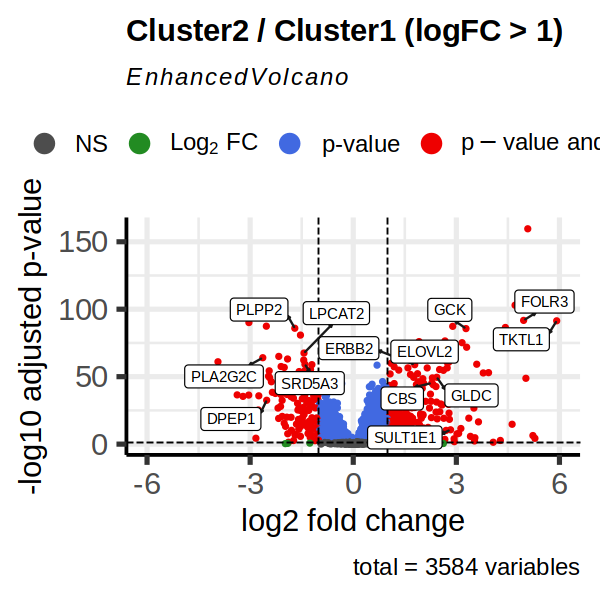

In [376]:
options(repr.plot.width = 5, repr.plot.height = 5)
vp1 <- EnhancedVolcano(dds_res_tb,
                       lab = dds_res_tb$external_gene_name,
                       selectLab = c( "L1CAM","FOLR3", 'TKTL1', 'GCK', "LPCAT2", "CBS", "SULT1E1",
                                     "ELOVL2",  "GLDC", "ERBB2", "SRD5A3","PLPP2", "PLA2G2C", 
                                     "DPEP1"  ),
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,160),
                       xlim = c(-6,6),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 1,
                       title = "Cluster2 / Cluster1 (logFC > 1)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(vp1)

In [377]:
#volcano_plot_file1 <- file.path(paste(res_dir, 'DEGs_results/clust21_logFC1.tiff', sep =''))
volcano_plot_file1 <- file.path(paste(res_dir, 'revision/clust21_logFC1.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(volcano_plot_file1, height = 6, width = 6, units = 'in', res= 300)

# Print your heatmap
print(vp1)

# Close the PNG file:
dev.off()

png 
  2

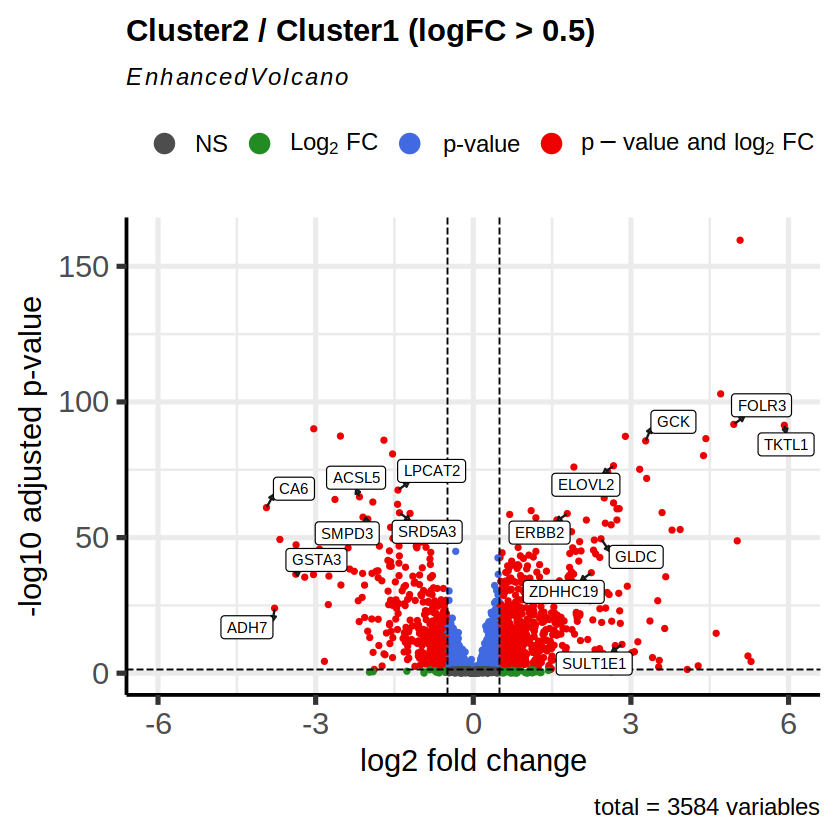

In [179]:
vp2 <- EnhancedVolcano(dds_res_tb,
                       lab = dds_res_tb$external_gene_name,
                       selectLab = c( "L1CAM","FOLR3", 'TKTL1', 'GCK', "LPCAT2", "ACSL5", "CA6", 'ZDHHC19', 
                                     "ELOVL2",  "GLDC", "ERBB2", "SRD5A3", "SMPD3","GSTA3", "ADH7", "SULT1E1"),
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,160),
                       xlim = c(-6,6),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 0.5,
                       title = "Cluster2 / Cluster1 (logFC > 0.5)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(vp2)

In [180]:
volcano_plot_file1b <- file.path(paste(res_dir, 'volcano_plots/clust21_logFC_0.5.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(volcano_plot_file1b, height = 6, width = 6, units = 'in', res=600)


# Print your heatmap
print(vp2)

# Close the PNG file:
dev.off()

png 
  2

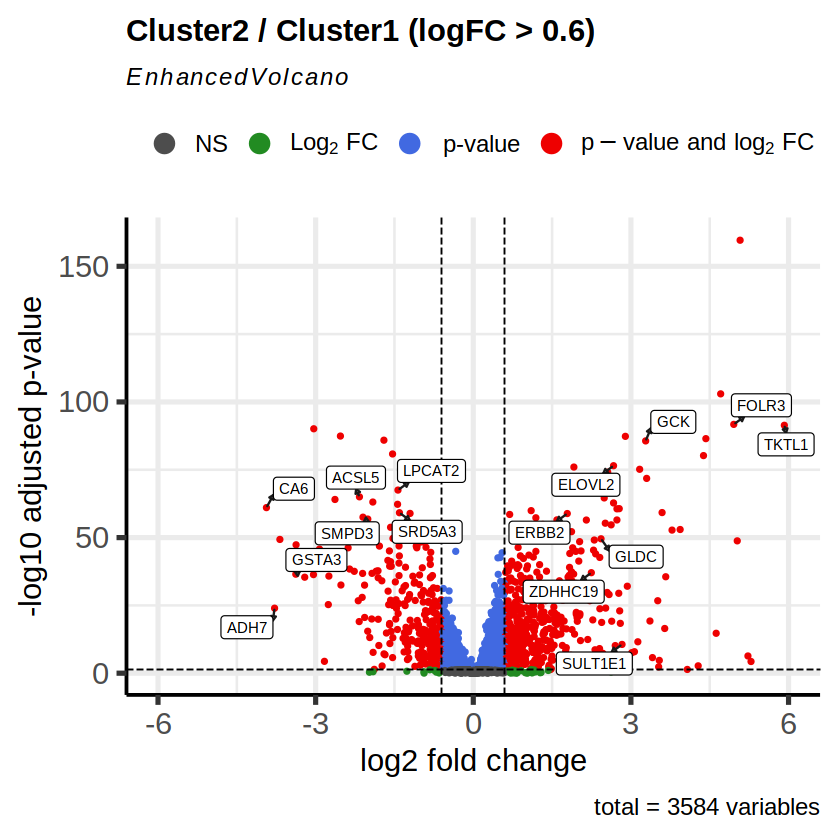

In [181]:
vp3 <- EnhancedVolcano(dds_res_tb,
                       lab = dds_res_tb$external_gene_name,
                       selectLab = c( "L1CAM","FOLR3", 'TKTL1', 'GCK', "LPCAT2", "ACSL5", "", 'ZDHHC19', 
                                     "ELOVL2",  "GLDC", "ERBB2", "SRD5A3", "SMPD3","GSTA3", "", "SULT1E1"),
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,160),
                       xlim = c(-6,6),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 0.6,
                       title = "Cluster2 / Cluster1 (logFC > 0.6)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(vp3)

In [182]:
volcano_plot_file1c <- file.path(paste(res_dir, 'volcano_plots/clust21_logFC_0.6.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(volcano_plot_file1c, height = 6, width = 6, units = 'in', res=600)


# Print your heatmap
print(vp3)

# Close the PNG file:
dev.off()

png 
  2

## Tumor vs Normal

In [55]:
dea_ucec_exp = ucec_exp_data[rownames(ucec_vst_data), ]
print(dim(dea_ucec_exp))
#head(dea_ucec_exp)

[1] 3584  565


In [61]:
ucec_clinical_data$sample_type <- sub(" ", "_", ucec_clinical_data$sample_type)
ucec_clinical_data$sample_type <- sub(" ", "_", ucec_clinical_data$sample_type)
table(ucec_clinical_data["sample_type"])


      Primary_Tumor Solid_Tissue_Normal 
                542                  23 

In [62]:
# Check that sample names match in both count data and stage data
all(colnames(dea_ucec_exp) %in% rownames(ucec_clinical_data["sample_type"]))
all(colnames(dea_ucec_exp) == rownames(ucec_clinical_data["sample_type"]))

[1] TRUE

[1] TRUE

In [63]:
# construct the DESeqDataSet object from the matrix of counts and the sample information

tn_ddsMat <- DESeqDataSetFromMatrix(countData = dea_ucec_exp,
                                 colData = ucec_clinical_data["sample_type"],
                                 design = ~sample_type)
tn_ddsMat

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 3584 565 
metadata(1): version
assays(1): counts
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(0):
colnames(565): TCGA-2E-A9G8-01A-11R-A40A-07
  TCGA-4E-A92E-01A-11R-A37O-07 ... TCGA-SL-A6J9-01A-11R-A31O-07
  TCGA-SL-A6JA-01A-11R-A31O-07
colData names(1): sample_type

In [66]:
tn_ddsMat$sample_type <- relevel(tn_ddsMat$sample_type, ref = "Solid_Tissue_Normal")
tn_ddsMat <- DESeq(tn_ddsMat)
tn_ddsMat

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 291 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



class: DESeqDataSet 
dim: 3584 565 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(565): TCGA-2E-A9G8-01A-11R-A40A-07
  TCGA-4E-A92E-01A-11R-A37O-07 ... TCGA-SL-A6J9-01A-11R-A31O-07
  TCGA-SL-A6JA-01A-11R-A31O-07
colData names(3): sample_type sizeFactor replaceable

In [67]:
# To know the name of coef in function lfcShrink
resultsNames(tn_ddsMat)

[1] "Intercept"                                       
[2] "sample_type_Primary_Tumor_vs_Solid_Tissue_Normal"

In [70]:
## Extract results 
tn_dds_res <- results(tn_ddsMat, alpha = 0.05)
head(tn_dds_res)

log2 fold change (MLE): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat      pvalue
                <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSG00000000419  796.4780     -0.0570246  0.138852 -0.4106871 6.81302e-01
ENSG00000000938  228.3773     -1.0466536  0.255373 -4.0985308 4.15781e-05
ENSG00000001036 2245.2659      0.6691738  0.112907  5.9267519 3.08985e-09
ENSG00000001084 1328.3598     -1.0798486  0.220011 -4.9081640 9.19330e-07
ENSG00000001626  648.6282      1.2797928  0.504674  2.5358816 1.12165e-02
ENSG00000001630   90.7159     -0.0222442  0.229261 -0.0970257 9.22706e-01
                       padj
                  <numeric>
ENSG00000000419 7.29109e-01
ENSG00000000938 9.75873e-05
ENSG00000001036 1.23045e-08
ENSG00000001084 2.67224e-06
ENSG00000001626 1.82560e-02
ENSG00000001630 9.40819e-01

In [71]:
# Apply fold change shrinkage
tn_dds_res <- lfcShrink(tn_ddsMat, coef="sample_type_Primary_Tumor_vs_Solid_Tissue_Normal", type="apeglm")
tn_dds_res

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 3584 rows and 5 columns
                 baseMean log2FoldChange     lfcSE      pvalue        padj
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000419   796.478     -0.0516085  0.136960 6.81302e-01 7.29109e-01
ENSG00000000938   228.377     -0.9964080  0.249885 4.15781e-05 9.75873e-05
ENSG00000001036  2245.266      0.6682434  0.112507 3.08985e-09 1.23045e-08
ENSG00000001084  1328.360     -1.0343476  0.215931 9.19330e-07 2.67224e-06
ENSG00000001626   648.628      1.0774436  0.529262 1.12165e-02 1.82560e-02
...                   ...            ...       ...         ...         ...
ENSG00000258429  64.64298       1.042910  0.201147 8.19826e-08 2.74603e-07
ENSG00000259075  12.33282       0.423153  0.241438 6.68274e-02 9.29412e-02
ENSG00000259431 158.80234      -0.600748  0.159107 1.29871e-04 2.882

In [72]:
tn_dds_res %>% data.frame() %>% head()

baseMean   log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  796.47804 -0.05160846    0.1369598 6.813020e-01 7.291091e-01
ENSG00000000938  228.37727 -0.99640803    0.2498847 4.157809e-05 9.758734e-05
ENSG00000001036 2245.26595  0.66824339    0.1125070 3.089853e-09 1.230448e-08
ENSG00000001084 1328.35976 -1.03434761    0.2159312 9.193297e-07 2.672245e-06
ENSG00000001626  648.62817  1.07744356    0.5292624 1.121647e-02 1.825605e-02
ENSG00000001630   90.71594 -0.01772078    0.2219094 9.227060e-01 9.408189e-01

In [74]:
summary(tn_dds_res, alpha = 0.05)


out of 3584 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1353, 38%
LFC < 0 (down)     : 1053, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [73]:
# Create a tibble of results
tn_dds_res_tb <- tn_dds_res %>% data.frame()
print(dim(tn_dds_res_tb))
head(tn_dds_res_tb)

[1] 3584    5


baseMean   log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  796.47804 -0.05160846    0.1369598 6.813020e-01 7.291091e-01
ENSG00000000938  228.37727 -0.99640803    0.2498847 4.157809e-05 9.758734e-05
ENSG00000001036 2245.26595  0.66824339    0.1125070 3.089853e-09 1.230448e-08
ENSG00000001084 1328.35976 -1.03434761    0.2159312 9.193297e-07 2.672245e-06
ENSG00000001626  648.62817  1.07744356    0.5292624 1.121647e-02 1.825605e-02
ENSG00000001630   90.71594 -0.01772078    0.2219094 9.227060e-01 9.408189e-01

In [75]:
# Subset the tibble to keep only significant genes
tn_sig_res1 <- tn_dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[1])
print(dim(tn_sig_res1))
#head(tn_sig_res1, 4)

[1] 1055    5


In [76]:
table(tn_sig_res1['log2FoldChange'] > 0)


FALSE  TRUE 
  440   615 

In [77]:
tn_up_regulated_genes1 <- rownames(tn_sig_res1[tn_sig_res1['log2FoldChange']>0,])
print(length(tn_up_regulated_genes1))

tn_down_regulated_genes1 <- rownames(tn_sig_res1[tn_sig_res1['log2FoldChange']<0,])
print(length(tn_down_regulated_genes1))

[1] 615
[1] 440


In [78]:
tn_dds_res_tb <- tn_dds_res_tb[order(tn_dds_res_tb[,5], -tn_dds_res_tb[,2]),]

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


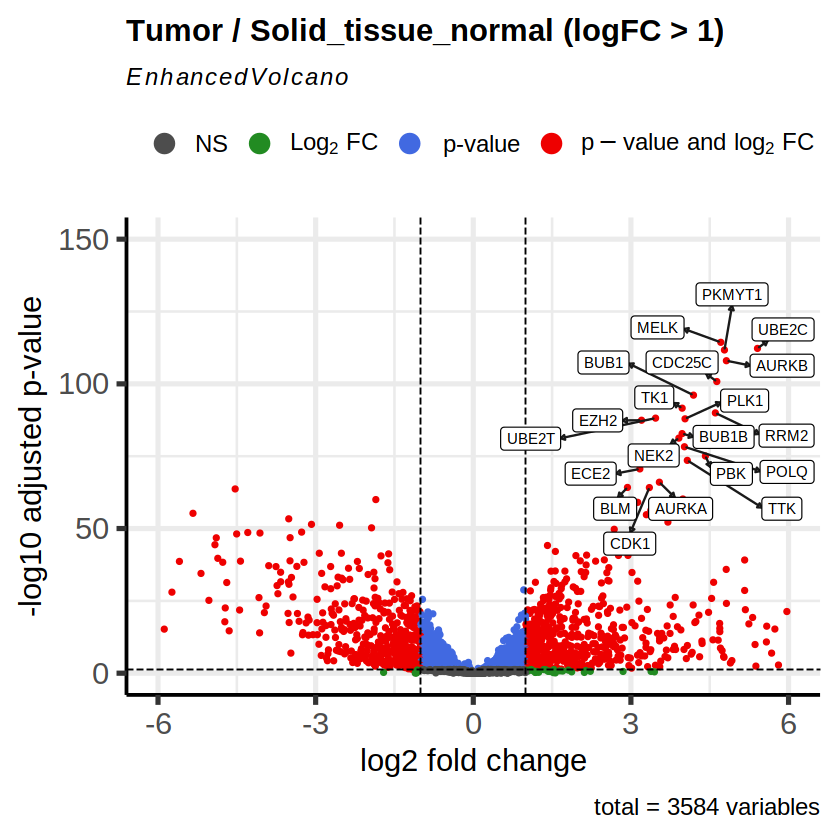

In [82]:
tn_vp1 <- EnhancedVolcano(tn_dds_res_tb,
                       lab = gene_mapping[rownames(tn_dds_res_tb), 'external_gene_name'],
                       selectLab = gene_mapping[rownames(tn_dds_res_tb)[1:20],'external_gene_name'],
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,150),
                       xlim = c(-6,6),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 1,
                       title = "Tumor / Solid_tissue_normal (logFC > 1)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(tn_vp1)

In [87]:
#print_genes(gene_mapping[tn_down_regulated_genes1, "external_gene_name"])

## Check whether each cluster have normal samples or not

In [99]:
table(ucec_prim_clinical_data[ucec_prim_clinical_data['nmf_cluster']== 'Cluster_1',]['detailed_sample_type'])


normal_matched_tumor        primary_tumor 
                  14                  295 

In [100]:
table(ucec_prim_clinical_data[ucec_prim_clinical_data['nmf_cluster']== 'Cluster_2',]['detailed_sample_type'])


normal_matched_tumor        primary_tumor 
                   9                  224 

In [101]:
clust1_nt_samples <- c()
clust1_index <- filter(ucec_prim_clinical_data, detailed_sample_type == "normal_matched_tumor", 
                        nmf_cluster == 'Cluster_1')["index"]

for (i in clust1_index$index){
    clust1_nt_samples <- c(clust1_nt_samples,rownames(ucec_clinical_data)[grep(i, rownames(ucec_clinical_data))])
}
print(length(clust1_nt_samples))

[1] 28


In [102]:
clust2_nt_samples <- c()
clust2_index <- filter(ucec_prim_clinical_data, detailed_sample_type == "normal_matched_tumor", 
                        nmf_cluster == 'Cluster_2')["index"]

for (i in clust2_index$index){
    clust2_nt_samples <- c(clust2_nt_samples,rownames(ucec_clinical_data)[grep(i, rownames(ucec_clinical_data))])
}
print(length(clust2_nt_samples))

[1] 18


In [105]:
length(c(clust1_nt_samples, clust2_nt_samples))

[1] 46

In [107]:
clust1_count_data <- ucec_exp_data[rownames(ucec_vst_data), clust1_nt_samples]
clust2_count_data <- ucec_exp_data[rownames(ucec_vst_data), clust2_nt_samples]

ucec_clinical_data$sample_type <- gsub(" ", "_", ucec_clinical_data$sample_type)
clust1_sample_type <- ucec_clinical_data[clust1_nt_samples, ]['sample_type']
clust2_sample_type <- ucec_clinical_data[clust2_nt_samples, ]['sample_type']
print(dim(clust1_count_data))
print(dim(clust2_count_data))
print(dim(clust1_sample_type))
print(dim(clust2_sample_type))

[1] 3584   28
[1] 3584   18
[1] 28  1
[1] 18  1


### A. Cluster1

In [153]:
# Check that sample names match in both count data and stage data
all(colnames(clust1_count_data) %in% rownames(clust1_sample_type['sample_type']))
all(colnames(clust1_count_data) == rownames(clust1_sample_type['sample_type']))

[1] TRUE

[1] TRUE

In [154]:
# construct the DESeqDataSet object from the matrix of counts and the sample information
clust1_ddsMat <- DESeqDataSetFromMatrix(countData = clust1_count_data,
                                 colData = clust1_sample_type['sample_type'],
                                 design = ~sample_type)
clust1_ddsMat

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 3584 28 
metadata(1): version
assays(1): counts
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(0):
colnames(28): TCGA-AJ-A2QL-11A-11R-A18M-07 TCGA-AJ-A2QL-01A-11R-A18M-07
  ... TCGA-E6-A1M0-11A-11R-A144-07 TCGA-E6-A1M0-01A-11R-A144-07
colData names(1): sample_type

In [155]:
clust1_ddsMat$sample_type <- relevel(clust1_ddsMat$sample_type, ref = "Solid_Tissue_Normal")
clust1_ddsMat <- DESeq(clust1_ddsMat)
clust1_ddsMat

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 184 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



class: DESeqDataSet 
dim: 3584 28 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(28): TCGA-AJ-A2QL-11A-11R-A18M-07 TCGA-AJ-A2QL-01A-11R-A18M-07
  ... TCGA-E6-A1M0-11A-11R-A144-07 TCGA-E6-A1M0-01A-11R-A144-07
colData names(3): sample_type sizeFactor replaceable

In [156]:
# To know the name of coef in function lfcShrink
resultsNames(clust1_ddsMat)

[1] "Intercept"                                       
[2] "sample_type_Primary_Tumor_vs_Solid_Tissue_Normal"

In [157]:
## Extract results 
clust1_dds_res <- results(clust1_ddsMat, alpha = 0.05)
head(clust1_dds_res)

log2 fold change (MLE): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000419   813.694      -0.253090  0.197531 -1.281269 2.00099e-01
ENSG00000000938   350.545      -1.733365  0.397664 -4.358871 1.30735e-05
ENSG00000001036  1911.234       0.688846  0.135354  5.089230 3.59519e-07
ENSG00000001084  1418.514       0.145803  0.308459  0.472681 6.36441e-01
ENSG00000001626   496.078       0.770870  0.766693  1.005449 3.14681e-01
ENSG00000001630   104.841       0.281805  0.376270  0.748945 4.53890e-01
                       padj
                  <numeric>
ENSG00000000419 2.84247e-01
ENSG00000000938 5.92357e-05
ENSG00000001036 2.33851e-06
ENSG00000001084 7.18200e-01
ENSG00000001626 4.11312e-01
ENSG00000001630 5.53879e-01

In [158]:
# Apply fold change shrinkage
clust1_dds_res <- lfcShrink(clust1_ddsMat, coef="sample_type_Primary_Tumor_vs_Solid_Tissue_Normal", type="apeglm")
clust1_dds_res

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 3584 rows and 5 columns
                 baseMean log2FoldChange     lfcSE      pvalue        padj
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000419   813.694      -0.241884  0.193328 2.00099e-01 2.84247e-01
ENSG00000000938   350.545      -1.610575  0.401462 1.30735e-05 5.92357e-05
ENSG00000001036  1911.234       0.675678  0.134662 3.59519e-07 2.33851e-06
ENSG00000001084  1418.514      -0.717376  0.301270 6.36441e-01 7.18200e-01
ENSG00000001626   496.078       0.473112  0.631047 3.14681e-01 4.11312e-01
...                   ...            ...       ...         ...         ...
ENSG00000258429  34.63729       0.786527  0.262128  0.00170638  0.00458789
ENSG00000259075  15.08642       0.852996  0.443716  0.02843340  0.05374668
ENSG00000259431 193.48929      -0.581704  0.236841  0.01071170  0.02

In [159]:
clust1_dds_res %>% data.frame() %>% head()

baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  813.6937 -0.2418835     0.1933284 2.000992e-01 2.842471e-01
ENSG00000000938  350.5445 -1.6105755     0.4014624 1.307351e-05 5.923575e-05
ENSG00000001036 1911.2338  0.6756784     0.1346618 3.595195e-07 2.338508e-06
ENSG00000001084 1418.5140 -0.7173762     0.3012696 6.364405e-01 7.181999e-01
ENSG00000001626  496.0779  0.4731120     0.6310471 3.146809e-01 4.113116e-01
ENSG00000001630  104.8413  0.2417026     0.3494697 4.538901e-01 5.538789e-01

In [160]:
summary(clust1_dds_res, alpha = 0.05)


out of 3584 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1020, 28%
LFC < 0 (down)     : 850, 24%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [161]:
# Create a tibble of results
clust1_dds_res_tb <- clust1_dds_res %>% data.frame()
print(dim(clust1_dds_res_tb))
head(clust1_dds_res_tb)

[1] 3584    5


baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  813.6937 -0.2418835     0.1933284 2.000992e-01 2.842471e-01
ENSG00000000938  350.5445 -1.6105755     0.4014624 1.307351e-05 5.923575e-05
ENSG00000001036 1911.2338  0.6756784     0.1346618 3.595195e-07 2.338508e-06
ENSG00000001084 1418.5140 -0.7173762     0.3012696 6.364405e-01 7.181999e-01
ENSG00000001626  496.0779  0.4731120     0.6310471 3.146809e-01 4.113116e-01
ENSG00000001630  104.8413  0.2417026     0.3494697 4.538901e-01 5.538789e-01

In [162]:
# Subset the tibble to keep only significant genes
clust1_sig_res1 <- clust1_dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[1])
print(dim(clust1_sig_res1))
#head(clust1_sig_res1, 4)

[1] 987   5


In [163]:
table(clust1_sig_res1['log2FoldChange'] > 0)


FALSE  TRUE 
  464   523 

In [164]:
clust1_up_regulated_genes1 <- rownames(clust1_sig_res1[clust1_sig_res1['log2FoldChange']>0,])
print(length(clust1_up_regulated_genes1))

clust1_down_regulated_genes1 <- rownames(clust1_sig_res1[clust1_sig_res1['log2FoldChange']<0,])
print(length(clust1_down_regulated_genes1))

[1] 523
[1] 464


In [492]:
#print_genes(gene_mapping[clust1_up_regulated_genes1,'external_gene_name'])
#print_genes(gene_mapping[clust1_down_regulated_genes1,'external_gene_name'])

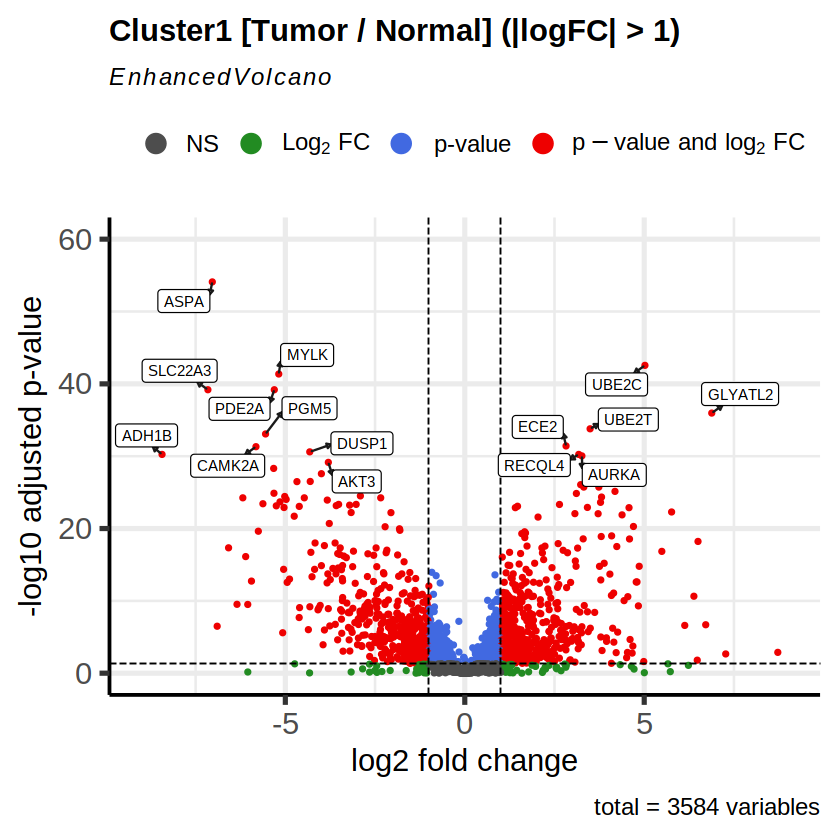

In [312]:
clust1_dds_res_tb <- clust1_dds_res_tb[order(clust1_dds_res_tb[,5], -clust1_dds_res_tb[,2]),]

clust1_vp1 <- EnhancedVolcano(clust1_dds_res_tb,
                       lab = gene_mapping[rownames(clust1_dds_res_tb), 'external_gene_name'],
                       selectLab = gene_mapping[rownames(clust1_dds_res_tb)[1:15],'external_gene_name'],
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,60),
                       xlim = c(-9,9),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 1,
                       title = "Cluster1 [Tumor / Normal] (|logFC| > 1)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(clust1_vp1)

In [313]:
volcano_plot_file2 <- file.path(paste(res_dir, 'clust1_volcano_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(volcano_plot_file2, height = 6, width = 6, units = 'in', res=300)

# Print your heatmap
print(clust1_vp1)

# Close the PNG file:
dev.off()

png 
  2

### B. Cluster2

In [168]:
# Check that sample names match in both count data and stage data
all(colnames(clust2_count_data) %in% rownames(clust2_sample_type['sample_type']))
all(colnames(clust2_count_data) == rownames(clust2_sample_type['sample_type']))

[1] TRUE

[1] TRUE

In [169]:
# construct the DESeqDataSet object from the matrix of counts and the sample information
clust2_ddsMat <- DESeqDataSetFromMatrix(countData = clust2_count_data,
                                 colData = clust2_sample_type['sample_type'],
                                 design = ~sample_type)
clust2_ddsMat

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 3584 18 
metadata(1): version
assays(1): counts
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(0):
colnames(18): TCGA-AJ-A3NH-11A-11R-A22K-07 TCGA-AJ-A3NH-01A-11R-A22K-07
  ... TCGA-DI-A2QY-11A-11R-A19W-07 TCGA-DI-A2QY-01A-12R-A19W-07
colData names(1): sample_type

In [170]:
clust2_ddsMat$sample_type <- relevel(clust2_ddsMat$sample_type, ref = "Solid_Tissue_Normal")
clust2_ddsMat <- DESeq(clust2_ddsMat)
clust2_ddsMat

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 139 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



class: DESeqDataSet 
dim: 3584 18 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(18): TCGA-AJ-A3NH-11A-11R-A22K-07 TCGA-AJ-A3NH-01A-11R-A22K-07
  ... TCGA-DI-A2QY-11A-11R-A19W-07 TCGA-DI-A2QY-01A-12R-A19W-07
colData names(3): sample_type sizeFactor replaceable

In [171]:
# To know the name of coef in function lfcShrink
resultsNames(clust2_ddsMat)

[1] "Intercept"                                       
[2] "sample_type_Primary_Tumor_vs_Solid_Tissue_Normal"

In [172]:
## Extract results 
clust2_dds_res <- results(clust2_ddsMat, alpha = 0.05)
head(clust2_dds_res)

log2 fold change (MLE): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000419  1042.840       0.285915  0.209653   1.36375 1.72646e-01
ENSG00000000938   257.008      -2.004818  0.509400  -3.93564 8.29737e-05
ENSG00000001036  2419.295       0.818116  0.232263   3.52237 4.27715e-04
ENSG00000001084  2698.585      -1.031136  0.539643  -1.91077 5.60336e-02
ENSG00000001626   145.460      -0.747095  0.832028  -0.89792 3.69228e-01
ENSG00000001630   135.678       0.526049  0.421375   1.24841 2.11880e-01
                       padj
                  <numeric>
ENSG00000000419 0.288497636
ENSG00000000938 0.000536138
ENSG00000001036 0.002185534
ENSG00000001084 0.120838913
ENSG00000001626 0.506017330
ENSG00000001630 0.335655713

In [173]:
# Apply fold change shrinkage
clust2_dds_res <- lfcShrink(clust2_ddsMat, coef="sample_type_Primary_Tumor_vs_Solid_Tissue_Normal", type="apeglm")
clust2_dds_res

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): sample type Primary Tumor vs Solid Tissue Normal 
Wald test p-value: sample type Primary Tumor vs Solid Tissue Normal 
DataFrame with 3584 rows and 5 columns
                 baseMean log2FoldChange     lfcSE      pvalue        padj
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000419  1042.840       0.270489  0.204232 1.72646e-01 0.296544321
ENSG00000000938   257.008      -1.801495  0.522297 8.29737e-05 0.000557776
ENSG00000001036  2419.295       0.781135  0.229678 4.27715e-04 0.002273742
ENSG00000001084  2698.585      -0.800737  0.514078 5.60336e-02 0.125011467
ENSG00000001626   145.460      -0.393618  0.639209 3.69228e-01 0.515165209
...                   ...            ...       ...         ...         ...
ENSG00000258429  70.76968       0.707125  0.404771   0.0471867   0.1085134
ENSG00000259075  11.10305       0.232288  0.439263   0.5344022   0.6655416
ENSG00000259431 251.20738      -0.592291  0.307419   0.0376083   0.0

In [174]:
clust2_dds_res %>% data.frame() %>% head()

baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419 1042.8400  0.2704885     0.2042324 0.1726462333 0.2965443211
ENSG00000000938  257.0077 -1.8014954     0.5222973 0.0000829737 0.0005577763
ENSG00000001036 2419.2952  0.7811348     0.2296777 0.0004277148 0.0022737420
ENSG00000001084 2698.5853 -0.8007369     0.5140779 0.0560336074 0.1250114666
ENSG00000001626  145.4603 -0.3936178     0.6392087 0.3692280926 0.5151652086
ENSG00000001630  135.6783  0.4318232     0.3898802 0.2118802322 0.3441372947

In [175]:
summary(clust2_dds_res, alpha = 0.05)


out of 3583 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 697, 19%
LFC < 0 (down)     : 586, 16%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [176]:
# Create a tibble of results
clust2_dds_res_tb <- clust2_dds_res %>% data.frame()
print(dim(clust2_dds_res_tb))
head(clust2_dds_res_tb)

[1] 3584    5


baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419 1042.8400  0.2704885     0.2042324 0.1726462333 0.2965443211
ENSG00000000938  257.0077 -1.8014954     0.5222973 0.0000829737 0.0005577763
ENSG00000001036 2419.2952  0.7811348     0.2296777 0.0004277148 0.0022737420
ENSG00000001084 2698.5853 -0.8007369     0.5140779 0.0560336074 0.1250114666
ENSG00000001626  145.4603 -0.3936178     0.6392087 0.3692280926 0.5151652086
ENSG00000001630  135.6783  0.4318232     0.3898802 0.2118802322 0.3441372947

In [177]:
# Subset the tibble to keep only significant genes
clust2_sig_res1 <- clust2_dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[1])
print(dim(clust2_sig_res1))
#head(clust2_sig_res1, 4)

print(table(clust2_sig_res1['log2FoldChange'] > 0))

[1] 775   5

FALSE  TRUE 
  382   393 


In [178]:
clust2_up_regulated_genes1 <- rownames(clust2_sig_res1[clust2_sig_res1['log2FoldChange']>0,])
print(length(clust2_up_regulated_genes1))

clust2_down_regulated_genes1 <- rownames(clust2_sig_res1[clust2_sig_res1['log2FoldChange']<0,])
print(length(clust2_down_regulated_genes1))

[1] 393
[1] 382


In [495]:
#print_genes(gene_mapping[clust2_up_regulated_genes1,'external_gene_name'])
#print_genes(gene_mapping[clust2_down_regulated_genes1,'external_gene_name'])

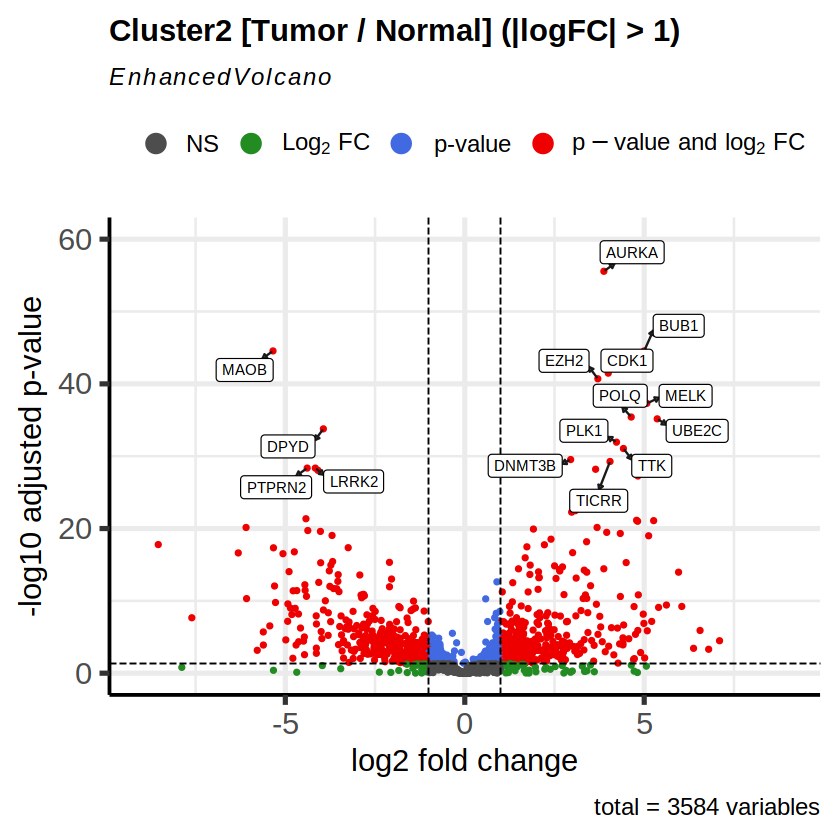

In [180]:
clust2_dds_res_tb <- clust2_dds_res_tb[order(clust2_dds_res_tb[,5], -clust2_dds_res_tb[,2]),]

clust2_vp1 <- EnhancedVolcano(clust2_dds_res_tb,
                       lab = gene_mapping[rownames(clust2_dds_res_tb), 'external_gene_name'],
                       selectLab = gene_mapping[rownames(clust2_dds_res_tb)[1:15],'external_gene_name'],
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0,60),
                       xlim = c(-9,9),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 1,
                       title = "Cluster2 [Tumor / Normal] (|logFC| > 1)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(clust2_vp1)

In [183]:
volcano_plot_file3 <- file.path(paste(res_dir, 'clust2_volcano_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(volcano_plot_file3, height = 6, width = 6, units = 'in', res=300)


# Print your heatmap
print(clust2_vp1)

# Close the PNG file:
dev.off()

png 
  2

## matched Tumor Normal

In [58]:
ucec_clinical_data$sample_type <- gsub(" ", "_", ucec_clinical_data$sample_type)
mtn_sample_type <- filter(ucec_clinical_data, detailed_sample_type== "normal_matched_tumor" | 
                          detailed_sample_type== "tumor_matched_normal_sample")["sample_type"]
mtn_count_data <- ucec_exp_data[rownames(ucec_vst_data), rownames(mtn_sample_type)]
print(dim(mtn_count_data))
print(dim(mtn_sample_type))
table(mtn_sample_type$sample_type)

[1] 3584   46
[1] 46  1



      Primary_Tumor Solid_Tissue_Normal 
                 23                  23 

In [59]:
# Check that sample names match in both count data and stage data
all(colnames(mtn_count_data) %in% rownames(mtn_sample_type["sample_type"]))
all(colnames(mtn_count_data) == rownames(mtn_sample_type["sample_type"]))

[1] TRUE

[1] TRUE

In [60]:
# construct the DESeqDataSet object from the matrix of counts and the sample information
mtn_ddsMat <- DESeqDataSetFromMatrix(countData = mtn_count_data,
                                 colData = mtn_sample_type['sample_type'],
                                 design = ~sample_type)
mtn_ddsMat

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 3584 46 
metadata(1): version
assays(1): counts
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(0):
colnames(46): TCGA-AJ-A2QL-11A-11R-A18M-07 TCGA-AJ-A2QL-01A-11R-A18M-07
  ... TCGA-E6-A1M0-11A-11R-A144-07 TCGA-E6-A1M0-01A-11R-A144-07
colData names(1): sample_type

In [61]:
mtn_ddsMat$sample_type <- relevel(mtn_ddsMat$sample_type, ref = "Solid_Tissue_Normal")
mtn_ddsMat <- DESeq(mtn_ddsMat)
mtn_ddsMat

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 191 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



class: DESeqDataSet 
dim: 3584 46 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(3584): ENSG00000000419 ENSG00000000938 ... ENSG00000261052
  ENSG00000267156
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(46): TCGA-AJ-A2QL-11A-11R-A18M-07 TCGA-AJ-A2QL-01A-11R-A18M-07
  ... TCGA-E6-A1M0-11A-11R-A144-07 TCGA-E6-A1M0-01A-11R-A144-07
colData names(3): sample_type sizeFactor replaceable

In [62]:
# To know the name of coef in function lfcShrink
resultsNames(mtn_ddsMat)

[1] "Intercept"                                       
[2] "sample_type_Primary_Tumor_vs_Solid_Tissue_Normal"

In [63]:
## Extract results 
mtn_dds_res <- results(mtn_ddsMat, alpha = 0.05)

# Apply fold change shrinkage
mtn_dds_res <- lfcShrink(mtn_ddsMat, coef="sample_type_Primary_Tumor_vs_Solid_Tissue_Normal", type="apeglm")

mtn_dds_res %>% data.frame() %>% head()

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  898.1112 -0.02934046    0.1440443 8.350233e-01 8.724895e-01
ENSG00000000938  317.9525 -1.73355867    0.3260034 2.064809e-08 1.195521e-07
ENSG00000001036 2098.3997  0.72910383    0.1171113 3.152787e-10 2.378861e-09
ENSG00000001084 1885.1216 -0.82029390    0.2993181 1.372314e-01 1.932514e-01
ENSG00000001626  371.7425  0.38240667    0.5262405 3.735424e-01 4.509181e-01
ENSG00000001630  116.0546  0.34637145    0.2654794 1.719637e-01 2.334537e-01

In [64]:
summary(mtn_dds_res, alpha = 0.05)


out of 3584 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1175, 33%
LFC < 0 (down)     : 932, 26%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [65]:
# Create a tibble of results
mtn_dds_res_tb <- mtn_dds_res %>% data.frame()
print(dim(mtn_dds_res_tb))
head(mtn_dds_res_tb, 3)

[1] 3584    5


baseMean  log2FoldChange lfcSE     pvalue       padj        
ENSG00000000419  898.1112 -0.02934046    0.1440443 8.350233e-01 8.724895e-01
ENSG00000000938  317.9525 -1.73355867    0.3260034 2.064809e-08 1.195521e-07
ENSG00000001036 2098.3997  0.72910383    0.1171113 3.152787e-10 2.378861e-09

In [66]:
# Subset the tibble to keep only significant genes
mtn_sig_res1 <- mtn_dds_res_tb %>% filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff[1])
print(dim(mtn_sig_res1))
#head(mtn_sig_res1, 4)

print(table(mtn_sig_res1['log2FoldChange'] > 0))

[1] 971   5

FALSE  TRUE 
  454   517 


In [67]:
mtn_up_regulated_genes1 <- rownames(mtn_sig_res1[mtn_sig_res1['log2FoldChange']>0,])
print(length(mtn_up_regulated_genes1))

mtn_down_regulated_genes1 <- rownames(mtn_sig_res1[mtn_sig_res1['log2FoldChange']<0,])
print(length(mtn_down_regulated_genes1))

[1] 517
[1] 454


In [68]:
gene_mapping[rownames(head(mtn_sig_res1[order(-mtn_sig_res1[2] ),], 10)), "external_gene_name"]

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "SLC18A3"  "NOS2P2"   "GLYATL2"  "SLC6A10P" "GAD1"     "PGLYRP3" 
 [7] "RHCG"     "FMO6P"    "AQP5"     "CA6"

In [69]:
mtn_sig_res1$external_gene_name <- gene_mapping[rownames(mtn_sig_res1),'external_gene_name']
mtn_sig_res1$entrez_id <- hmr2_genes_mapping[rownames(mtn_sig_res1),'GENE.ID.2']
mtn_sig_res1$hmr2_gene_names <- hmr2_genes_mapping[rownames(mtn_sig_res1),'SHORT.NAME']
#write.csv(mtn_sig_res1, file=paste(res_dir,'DEGs_results/tumor_DEGs_table.csv', sep=''),quote=F)

In [70]:
mtn_dds_res_tb <- mtn_dds_res_tb[order(mtn_dds_res_tb[,5], -mtn_dds_res_tb[,2]),]
mtn_dds_res_tb$external_gene_name <- gene_mapping[rownames(mtn_dds_res_tb),'external_gene_name']
mtn_dds_res_tb$entrez_id <- hmr2_genes_mapping[rownames(mtn_dds_res_tb),'GENE.ID.2']
mtn_dds_res_tb$hmr2_gene_names <- hmr2_genes_mapping[rownames(mtn_dds_res_tb),'SHORT.NAME']
#write.csv(mtn_dds_res_tb, file=paste(res_dir,'DEGs_results/tumor_deseq2_result.csv', sep=''),quote=F)

In [71]:
#mtn_dds_res_tb[abs(mtn_dds_res_tb$log2FoldChange)>5,]

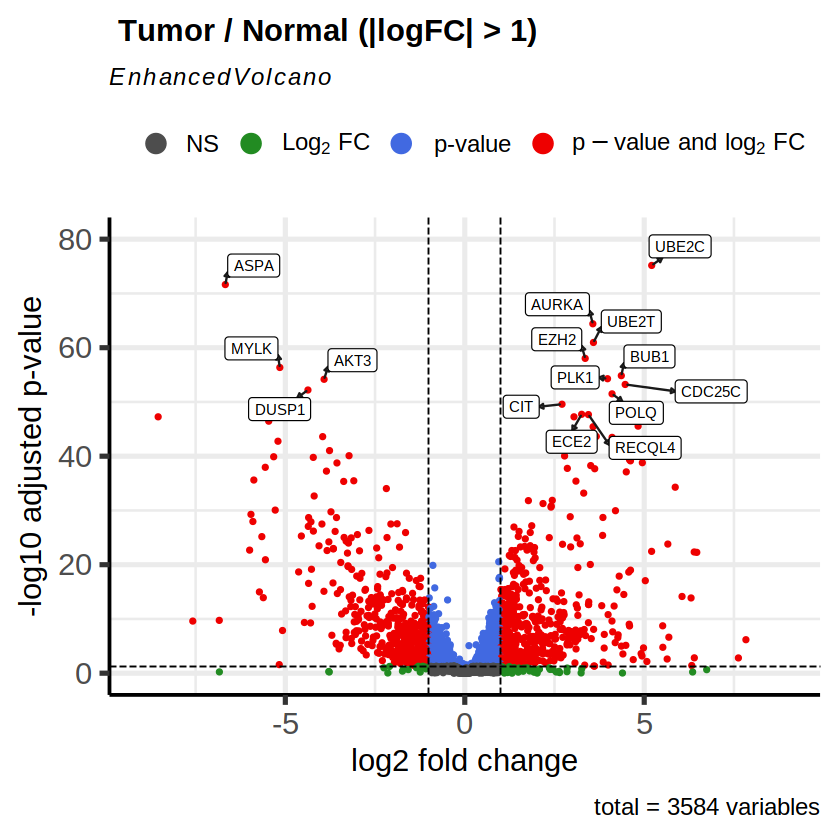

In [72]:
mtn_vp1 <- EnhancedVolcano(mtn_dds_res_tb,
                       lab = mtn_dds_res_tb$external_gene_name,
                       selectLab = mtn_dds_res_tb$external_gene_name[1:15],
                       x = 'log2FoldChange',
                       y = 'padj', 
                       xlab = "log2 fold change",
                       ylab = "-log10 adjusted p-value",
                       ylim = c(0, 80),
                       xlim = c(-9,9),
                       colAlpha = 1,
                       pCutoff = 0.05,
                       FCcutoff = 1,
                       title = " Tumor / Normal (|logFC| > 1)",
                       pointSize = 1,
                       labSize = 3,
                       drawConnectors = TRUE,widthConnectors = 0.5,
                       boxedLabels = TRUE
                       )

print(mtn_vp1)

In [597]:
mtn_volcano_plot_file <- file.path(paste(res_dir, 'volcano_plots/mTN_logFC1.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(mtn_volcano_plot_file, height = 6, width = 6, units = 'in', res=600)


# Print your heatmap
print(mtn_vp1)

# Close the PNG file:
dev.off()

png 
  2

In [140]:
# print_genes(gene_mapping[mtn_down_regulated_genes1,'external_gene_name'])

#### Survival Analysis based on the expression of GCK

#### ASS1

In [127]:
summary(t(ucec_vst_data["ENSG00000130707", ]))

 ENSG00000130707 
 Min.   : 6.051  
 1st Qu.: 9.961  
 Median :11.516  
 Mean   :11.291  
 3rd Qu.:12.736  
 Max.   :16.073  

In [128]:
ass1 = as.data.frame(t(ucec_vst_data["ENSG00000130707", ]))
ass1$binary<- ifelse(ass1$ENSG00000130707> 11.5,"high","low")
head(ass1,3)

ENSG00000130707 binary
TCGA-2E-A9G8-01A-11R-A40A-07 13.67737        high  
TCGA-4E-A92E-01A-11R-A37O-07 10.82182        low   
TCGA-5B-A90C-01A-11R-A37O-07 10.04878        low

In [130]:
# Fitting the survival model
ass1_surv_fun = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ ass1$binary)
ass1_surv_fun

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    ass1$binary)

                   n events median 0.95LCL 0.95UCL
ass1$binary=high 272     65   9.18    8.91      NA
ass1$binary=low  270     26     NA      NA      NA

In [132]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ ass1$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ ass1$binary)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
ass1$binary=high 272       65     42.4      12.0      22.6
ass1$binary=low  270       26     48.6      10.5      22.6

 Chisq= 22.6  on 1 degrees of freedom, p= 2e-06 

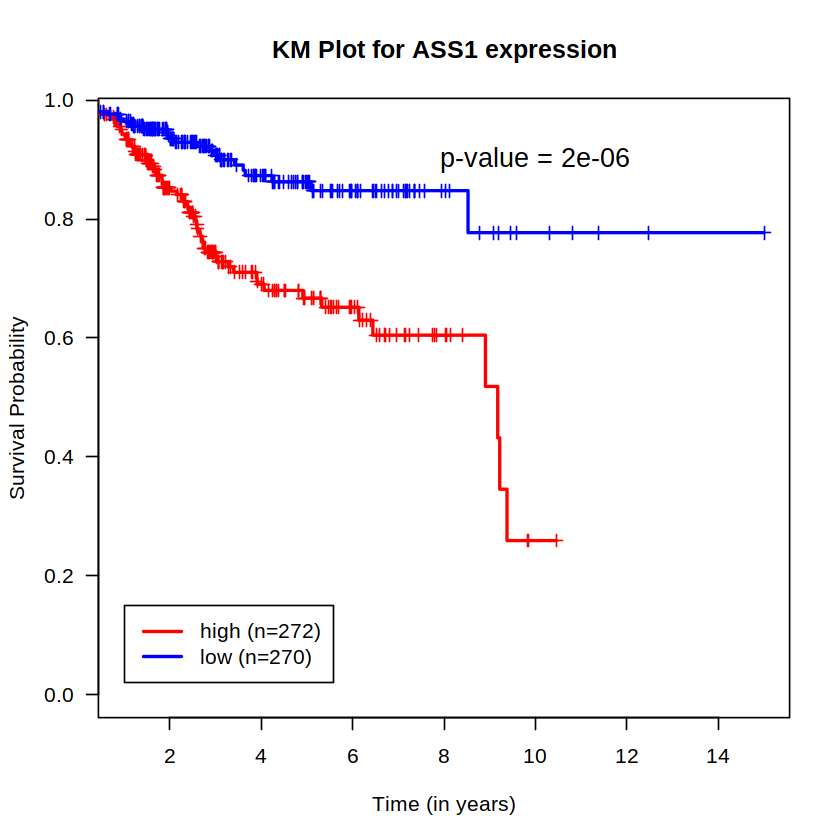

In [133]:
plot(ass1_surv_fun, main = "KM Plot for ASS1 expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=272)', 'low (n=270)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 2e-06', cex=1.3) 

#### ERBB2

In [221]:
summary(t(ucec_vst_data["ENSG00000141736", ]))  # ERBB2

 ENSG00000141736 
 Min.   : 8.239  
 1st Qu.:12.262  
 Median :12.685  
 Mean   :12.813  
 3rd Qu.:13.196  
 Max.   :19.008  

In [222]:
erbb2 = as.data.frame(t(ucec_vst_data["ENSG00000141736", ]))
erbb2$binary<- ifelse(erbb2$ENSG00000141736>= 12.685,"high","low")
head(erbb2,3)

ENSG00000141736 binary
TCGA-2E-A9G8-01A-11R-A40A-07 14.47019        high  
TCGA-4E-A92E-01A-11R-A37O-07 12.26693        low   
TCGA-5B-A90C-01A-11R-A37O-07 12.77368        high

In [223]:
# Fitting the survival model
surv_fun_erbb2 = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ erbb2$binary)
surv_fun_erbb2

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    erbb2$binary)

                    n events median 0.95LCL 0.95UCL
erbb2$binary=high 270     55   8.91    8.53      NA
erbb2$binary=low  272     36     NA      NA      NA

In [224]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ erbb2$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ erbb2$binary)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
erbb2$binary=high 270       55     42.6      3.59      6.91
erbb2$binary=low  272       36     48.4      3.17      6.91

 Chisq= 6.9  on 1 degrees of freedom, p= 0.009 

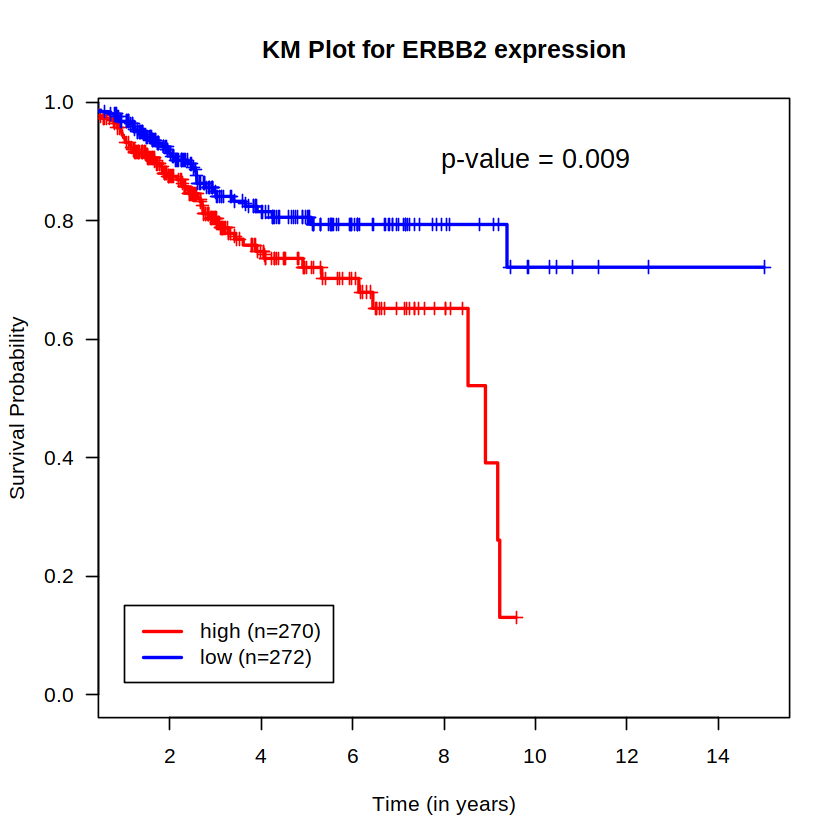

In [225]:
plot(surv_fun_erbb2, main = "KM Plot for ERBB2 expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=270)', 'low (n=272)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 0.009', cex=1.3) 

#### PSAT1

In [211]:
summary(t(ucec_vst_data["ENSG00000135069", ]))  # PSAT1

 ENSG00000135069 
 Min.   : 5.862  
 1st Qu.:10.125  
 Median :10.980  
 Mean   :10.944  
 3rd Qu.:11.860  
 Max.   :14.318  

In [213]:
psat1 = as.data.frame(t(ucec_vst_data["ENSG00000135069", ]))
psat1$binary<- ifelse(psat1$ENSG00000135069> 10.980,"high","low")
head(psat1,3)

ENSG00000135069 binary
TCGA-2E-A9G8-01A-11R-A40A-07 11.29640        high  
TCGA-4E-A92E-01A-11R-A37O-07 10.64618        low   
TCGA-5B-A90C-01A-11R-A37O-07 11.95498        high

In [214]:
# Fitting the survival model
surv_fun_psat1 = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ psat1$binary)
surv_fun_psat1

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    psat1$binary)

                    n events median 0.95LCL 0.95UCL
psat1$binary=high 271     56     NA    8.53      NA
psat1$binary=low  271     35   9.38    9.22      NA

In [215]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ psat1$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ psat1$binary)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
psat1$binary=high 271       56     45.3      2.55      5.07
psat1$binary=low  271       35     45.7      2.52      5.07

 Chisq= 5.1  on 1 degrees of freedom, p= 0.02 

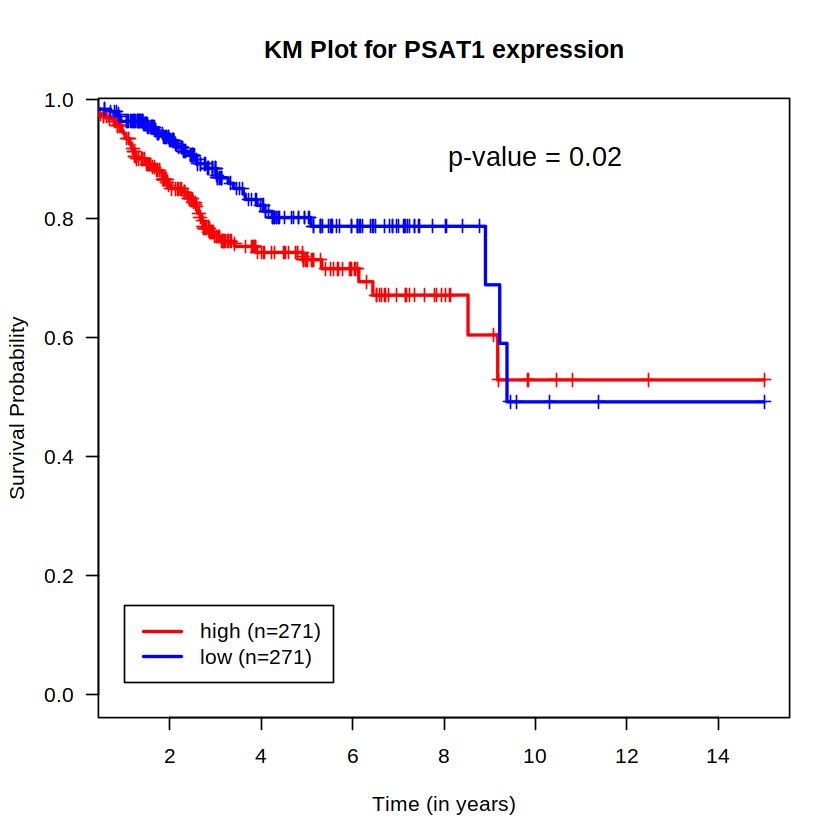

In [216]:
plot(surv_fun_psat1, main = "KM Plot for PSAT1 expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=271)', 'low (n=271)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 0.02', cex=1.3) 

#### GCK

In [73]:
summary(t(ucec_vst_data["ENSG00000106633", ]))  # GCK

 ENSG00000106633 
 Min.   : 2.967  
 1st Qu.: 3.869  
 Median : 4.302  
 Mean   : 4.697  
 3rd Qu.: 5.081  
 Max.   :10.923  

In [74]:
gck = as.data.frame(t(ucec_vst_data["ENSG00000106633", ]))
gck$binary<- ifelse(gck$ENSG00000106633> 4.3,"high","low")
head(gck,3)

ENSG00000106633 binary
TCGA-2E-A9G8-01A-11R-A40A-07 4.280929        low   
TCGA-4E-A92E-01A-11R-A37O-07 4.117406        low   
TCGA-5B-A90C-01A-11R-A37O-07 4.411020        high

In [75]:
# Fitting the survival model
ucec_surv_fun_gck = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ gck$binary)
ucec_surv_fun_gck

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    gck$binary)

                  n events median 0.95LCL 0.95UCL
gck$binary=high 272     59   9.18    8.53      NA
gck$binary=low  270     32     NA    9.38      NA

In [76]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ gck$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ gck$binary)

                  N Observed Expected (O-E)^2/E (O-E)^2/V
gck$binary=high 272       59     43.1      5.83      11.1
gck$binary=low  270       32     47.9      5.25      11.1

 Chisq= 11.1  on 1 degrees of freedom, p= 9e-04 

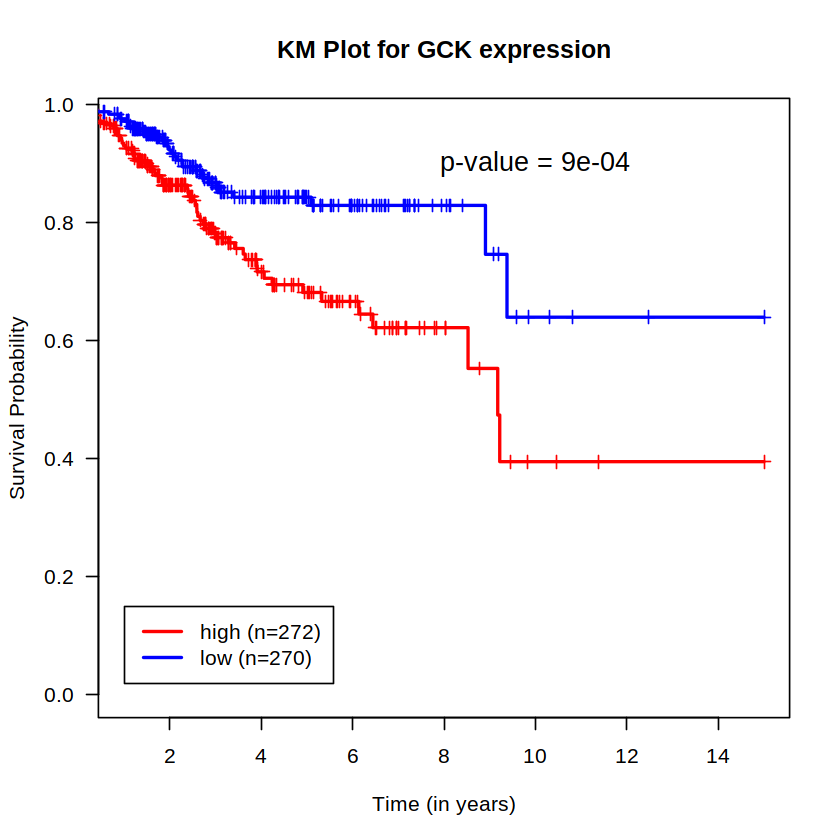

In [77]:
plot(ucec_surv_fun_gck, main = "KM Plot for GCK expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=272)', 'low (n=270)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 9e-04', cex=1.3) 

In [533]:
gck_survival_plot_file <- file.path(paste(res_dir, 'gck_survival_plot.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(gck_survival_plot_file, height = 6, width = 6, units = 'in', res=300)

# Print your heatmap
plot(ucec_surv_fun_gck, main = "KM Plot for GCK expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=272)', 'low (n=270)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 9e-04', cex=1.3) 

# Close the PNG file:
dev.off()

png 
  2

### Boxplot

In [88]:
gck_vst_exp <- merge(ucec_prim_clinical_data["nmf_cluster"], as.data.frame(t(ucec_vst_data["ENSG00000106633", ])),
                     by = 'row.names', all = TRUE)
head(gck_vst_exp,3)

Row.names                    nmf_cluster ENSG00000106633
1 TCGA-2E-A9G8-01A-11R-A40A-07 Cluster_2   4.280929       
2 TCGA-4E-A92E-01A-11R-A37O-07 Cluster_1   4.117406       
3 TCGA-5B-A90C-01A-11R-A37O-07 Cluster_2   4.411020

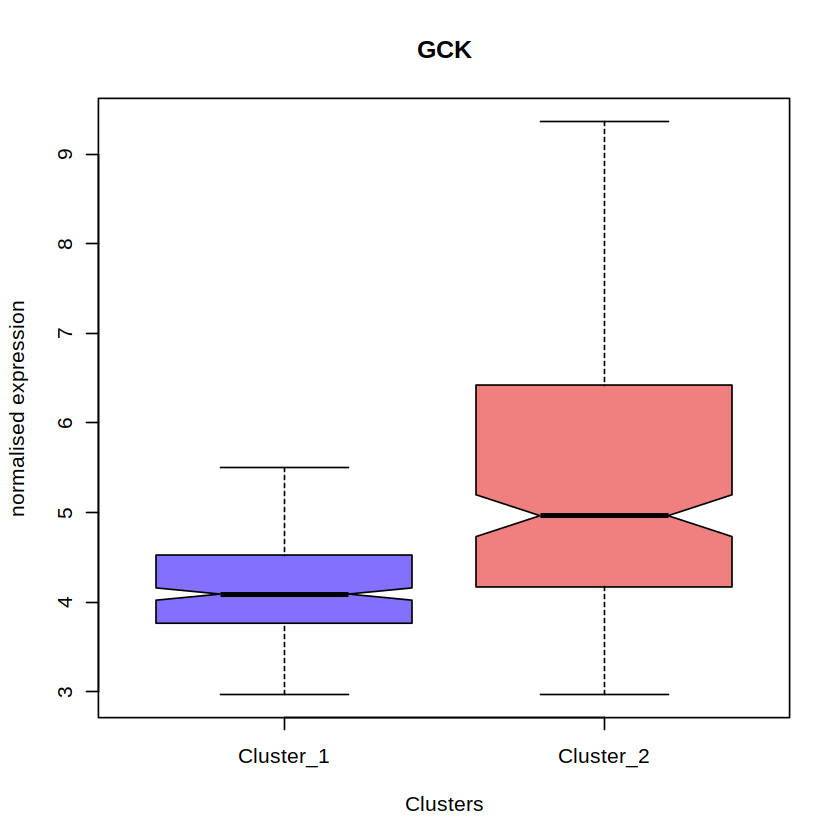

In [118]:
boxplot(ENSG00000106633~nmf_cluster, data = gck_vst_exp, xlab = "Clusters", ylab = "normalised expression",
        main = "GCK",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = FALSE)

In [113]:
mtn_vst_data = vst_norm(mtn_count_data)
head(mtn_vst_data,2)

[1] 3429
[1] 3429   46


TCGA-AJ-A2QL-11A-11R-A18M-07 TCGA-AJ-A2QL-01A-11R-A18M-07
ENSG00000000419 9.489898                     10.099551                   
ENSG00000000938 8.034221                      9.038756                   
                TCGA-AJ-A3NC-01A-11R-A22K-07 TCGA-AJ-A3NC-11A-11R-A22K-07
ENSG00000000419 9.978648                     10.29613                    
ENSG00000000938 8.791182                     10.43277                    
                TCGA-AJ-A3NE-11A-11R-A22K-07 TCGA-AJ-A3NE-01A-11R-A22K-07
ENSG00000000419 10.191947                    10.321019                   
ENSG00000000938  9.705013                     7.671886                   
                TCGA-AJ-A3NH-11A-11R-A22K-07 TCGA-AJ-A3NH-01A-11R-A22K-07
ENSG00000000419 10.070160                    11.060954                   
ENSG00000000938  7.690596                     7.131252                   
                TCGA-AX-A05Y-11A-11R-A27V-07 TCGA-AX-A05Y-01A-11R-A00V-07 ⋯
ENSG00000000419 10.39157                     9.078716                     ⋯
ENSG00000000938 10.25714                     7.122087                     ⋯
                TCGA-BK-A13C-11A-11R-A118-07 TCGA-BK-A13C-01A-11R-A118-07
ENSG00000000419 9.830348                     9.509456                    
ENSG00000000938 9.438312                     8.295897                    
                TCGA-BK-A4ZD-01A-11R-A27V-07 TCGA-BK-A4ZD-11A-12R-A27V-07
ENSG00000000419 9.936489                     10.098947                   
ENSG00000000938 6.617722                      9.555631                   
                TCGA-DI-A2QU-11A-11R-A18M-07 TCGA-DI-A2QU-01A-11R-A18M-07
ENSG00000000419 9.745845                     10.106680                   
ENSG00000000938 9.004359                      7.881451                   
                TCGA-DI-A2QY-11A-11R-A19W-07 TCGA-DI-A2QY-01A-12R-A19W-07
ENSG00000000419 9.796164                     10.187228                   
ENSG00000000938 8.259748                      6.723046                   
                TCGA-E6-A1M0-11A-11R-A144-07 TCGA-E6-A1M0-01A-11R-A144-07
ENSG00000000419 9.831864                     10.480193                   
ENSG00000000938 6.956368                      8.064739

In [114]:
mtn_gck_vst_exp <-merge(mtn_sample_type, as.data.frame(t(mtn_vst_data))["ENSG00000106633"],
                     by = 'row.names', all = TRUE)
head(mtn_gck_vst_exp,3)

Row.names                    sample_type         ENSG00000106633
1 TCGA-AJ-A2QL-01A-11R-A18M-07 Primary_Tumor       5.872027       
2 TCGA-AJ-A2QL-11A-11R-A18M-07 Solid_Tissue_Normal 6.524243       
3 TCGA-AJ-A3NC-01A-11R-A22K-07 Primary_Tumor       5.843191

### Combined One Boxplot

In [158]:
ucec_all_vst_data <- vst_norm(ucec_exp_data)
ucec_all_vst_data <- ucec_all_vst_data[rownames(ucec_vst_data), ]
print(dim(ucec_all_vst_data))
head(ucec_all_vst_data,2)

[1] 31822
[1] 31822   565
[1] 3584  565


TCGA-2E-A9G8-01A-11R-A40A-07 TCGA-4E-A92E-01A-11R-A37O-07
ENSG00000000419 10.863810                    9.310914                    
ENSG00000000938  6.679349                    8.167686                    
                TCGA-5B-A90C-01A-11R-A37O-07 TCGA-5S-A9Q8-01A-11R-A40A-07
ENSG00000000419 10.090194                    9.134400                    
ENSG00000000938  6.192546                    6.559968                    
                TCGA-A5-A0G1-01A-11R-A118-07 TCGA-A5-A0G2-01A-11R-A16W-07
ENSG00000000419 9.555838                     9.830835                    
ENSG00000000938 8.782240                     7.793648                    
                TCGA-A5-A0G3-01A-11R-A040-07 TCGA-A5-A0G5-01A-11R-A040-07
ENSG00000000419 8.782067                      9.154726                   
ENSG00000000938 6.443002                     10.192138                   
                TCGA-A5-A0G9-01A-11R-A040-07 TCGA-A5-A0GA-01A-11R-A040-07 ⋯
ENSG00000000419 8.712819                     9.854768                     ⋯
ENSG00000000938 7.954423                     7.317347                     ⋯
                TCGA-QF-A5YS-01A-11R-A31O-07 TCGA-QF-A5YT-01A-11R-A31O-07
ENSG00000000419 9.583223                     10.077783                   
ENSG00000000938 7.321986                      6.002501                   
                TCGA-QS-A5YQ-01A-11R-A31O-07 TCGA-QS-A5YR-01A-31R-A31O-07
ENSG00000000419 9.533563                     9.590863                    
ENSG00000000938 7.750170                     8.551317                    
                TCGA-QS-A744-01A-11R-A34R-07 TCGA-QS-A8F1-01A-21R-A37O-07
ENSG00000000419 9.796163                     9.044177                    
ENSG00000000938 5.821735                     5.811068                    
                TCGA-SJ-A6ZI-01A-12R-A34R-07 TCGA-SJ-A6ZJ-01A-12R-A34R-07
ENSG00000000419 9.816253                     9.584386                    
ENSG00000000938 8.998114                     7.222424                    
                TCGA-SL-A6J9-01A-11R-A31O-07 TCGA-SL-A6JA-01A-11R-A31O-07
ENSG00000000419 11.006491                    9.691330                    
ENSG00000000938  8.322395                    5.432184

In [175]:
merged_ucec_all_vst_data <- merge(as.data.frame(t(ucec_all_vst_data)), 
           ucec_prim_clinical_data["nmf_cluster"], 
           by = 'row.names', all.x = TRUE)
merged_ucec_all_vst_data$nmf_cluster[is.na(merged_ucec_all_vst_data$nmf_cluster)]<- "Solid_Tissue_Normal"
rownames(merged_ucec_all_vst_data) <- merged_ucec_all_vst_data$Row.names
merged_ucec_all_vst_data$Row.names <- NULL
head(merged_ucec_all_vst_data, 2)

ENSG00000000419 ENSG00000000938 ENSG00000001036
TCGA-2E-A9G8-01A-11R-A40A-07 10.863810       6.679349        10.94513       
TCGA-4E-A92E-01A-11R-A37O-07  9.310914       8.167686        10.66388       
                             ENSG00000001084 ENSG00000001626 ENSG00000001630
TCGA-2E-A9G8-01A-11R-A40A-07 10.09925        10.49203        5.751001       
TCGA-4E-A92E-01A-11R-A37O-07 10.65964        12.92063        7.358207       
                             ENSG00000002549 ENSG00000002587 ENSG00000002726
TCGA-2E-A9G8-01A-11R-A40A-07 12.98068        6.825263        10.691530      
TCGA-4E-A92E-01A-11R-A37O-07 12.25684        9.906629         5.337244      
                             ENSG00000002746 ⋯ ENSG00000257335 ENSG00000257365
TCGA-2E-A9G8-01A-11R-A40A-07 5.183864        ⋯ 3.887781        9.045971       
TCGA-4E-A92E-01A-11R-A37O-07 6.338205        ⋯ 4.875787        8.301997       
                             ENSG00000257594 ENSG00000258366 ENSG00000258429
TCGA-2E-A9G8-01A-11R-A40A-07 3.742122        4.940709        7.183805       
TCGA-4E-A92E-01A-11R-A37O-07 8.309237        6.086625        6.120689       
                             ENSG00000259075 ENSG00000259431 ENSG00000261052
TCGA-2E-A9G8-01A-11R-A40A-07 4.630615        8.295697        4.312257       
TCGA-4E-A92E-01A-11R-A37O-07 5.296133        8.349592        3.844157       
                             ENSG00000267156 nmf_cluster
TCGA-2E-A9G8-01A-11R-A40A-07 3.887781        Cluster_2  
TCGA-4E-A92E-01A-11R-A37O-07 4.105157        Cluster_1

In [174]:
table(merged_ucec_all_vst_data$nmf_cluster)


          Cluster_1           Cluster_2 Solid_Tissue_Normal 
                309                 233                  23 

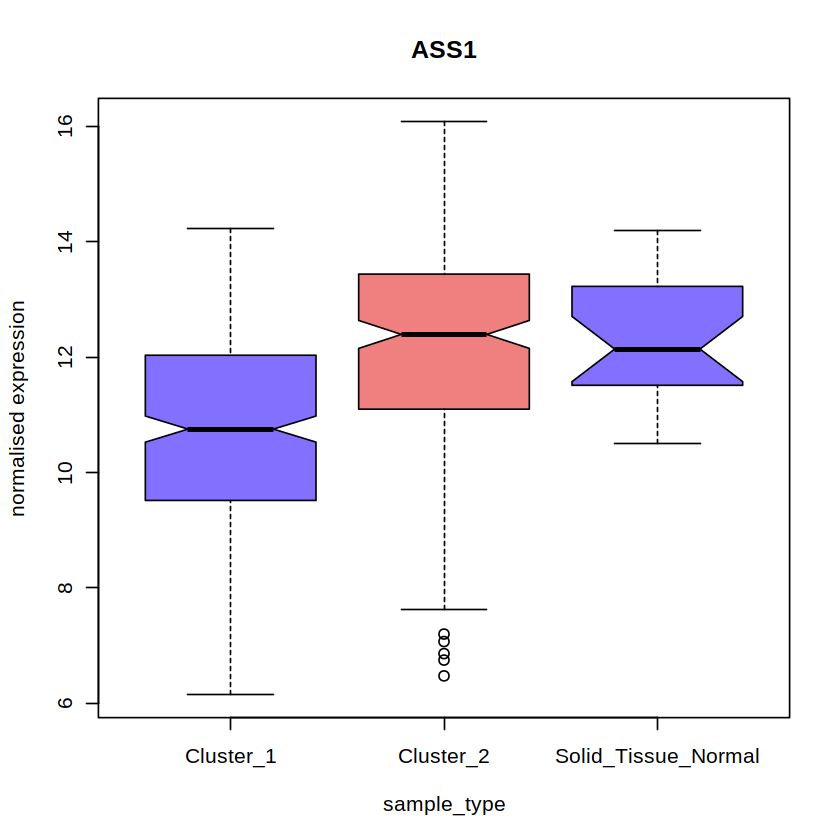

In [183]:
boxplot(ENSG00000130707~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "ASS1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

Warning message in (function (z, notch = FALSE, width = NULL, varwidth = FALSE, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”


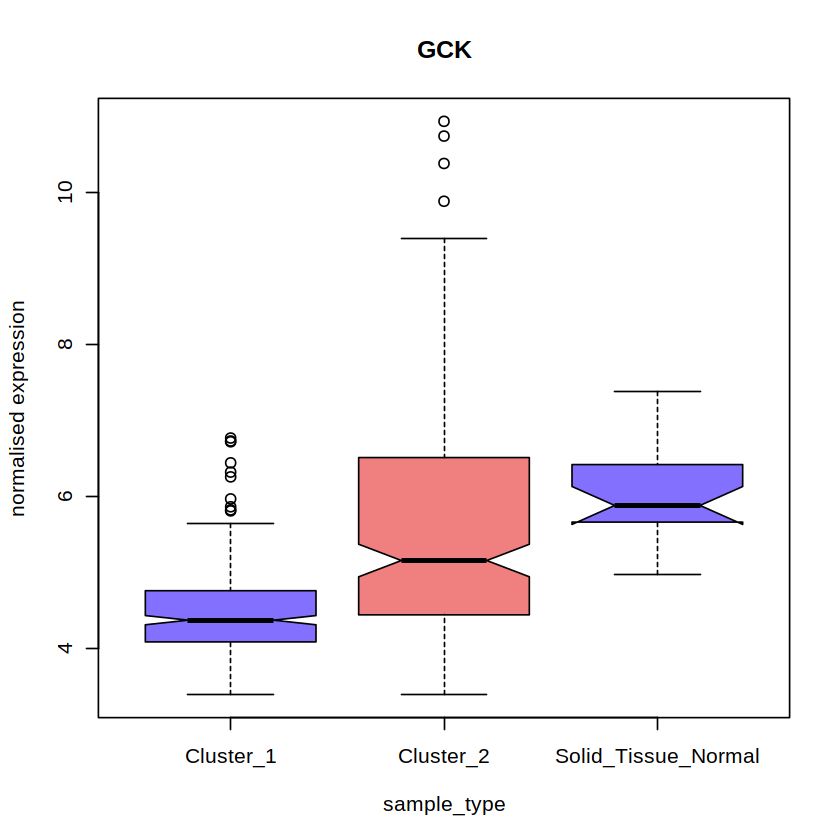

In [184]:
boxplot(ENSG00000106633~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "GCK",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

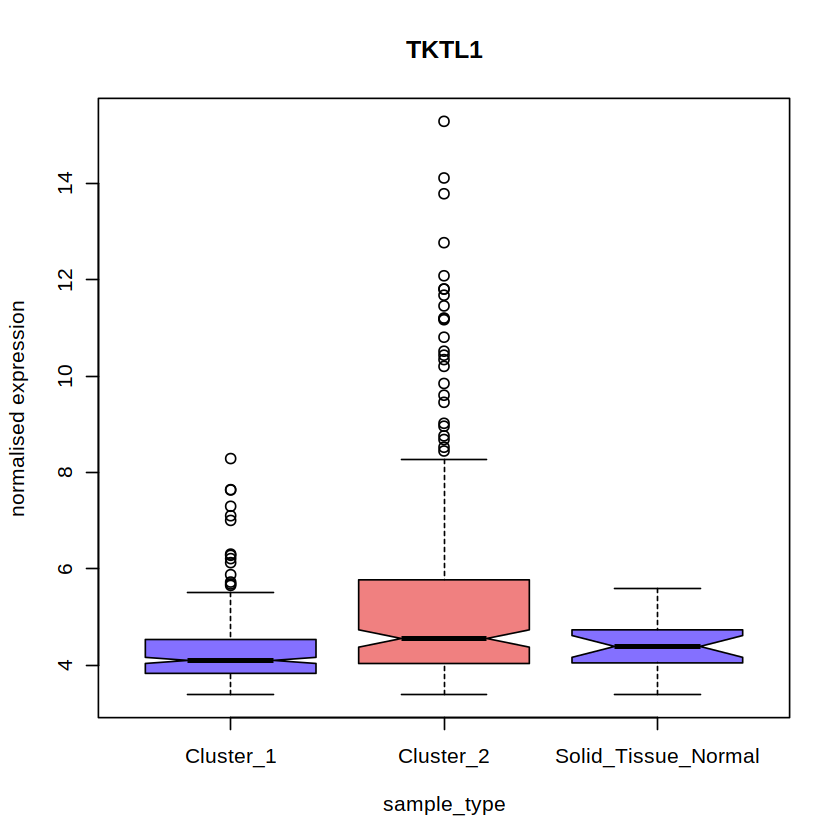

In [185]:
boxplot(ENSG00000007350~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "TKTL1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

Warning message in (function (z, notch = FALSE, width = NULL, varwidth = FALSE, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”


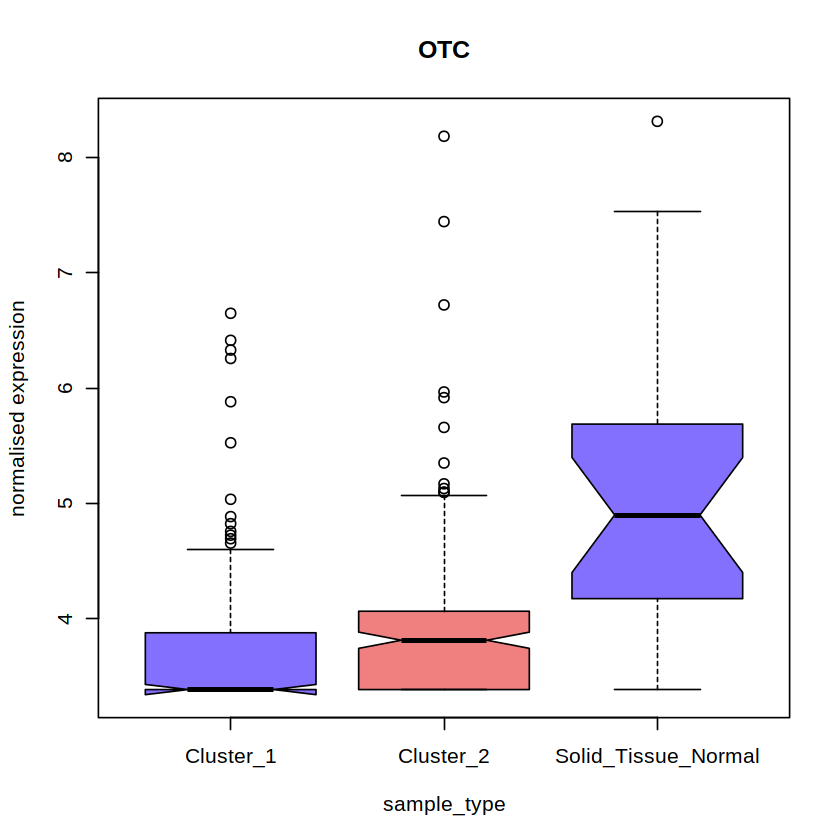

In [188]:
boxplot(ENSG00000036473~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "OTC",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

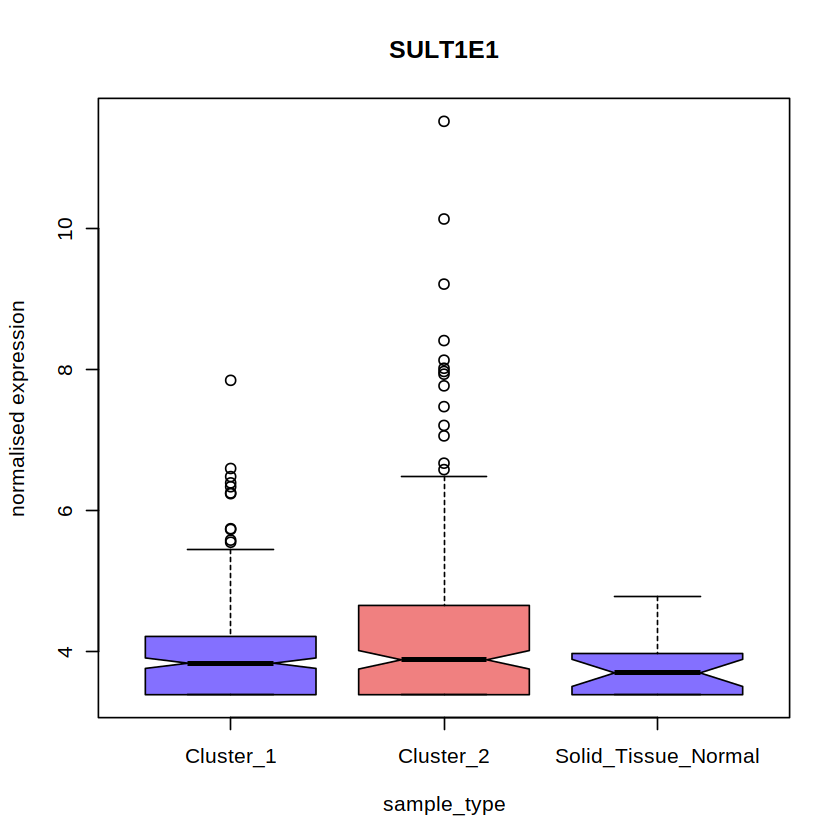

In [190]:
boxplot(ENSG00000109193~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "SULT1E1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

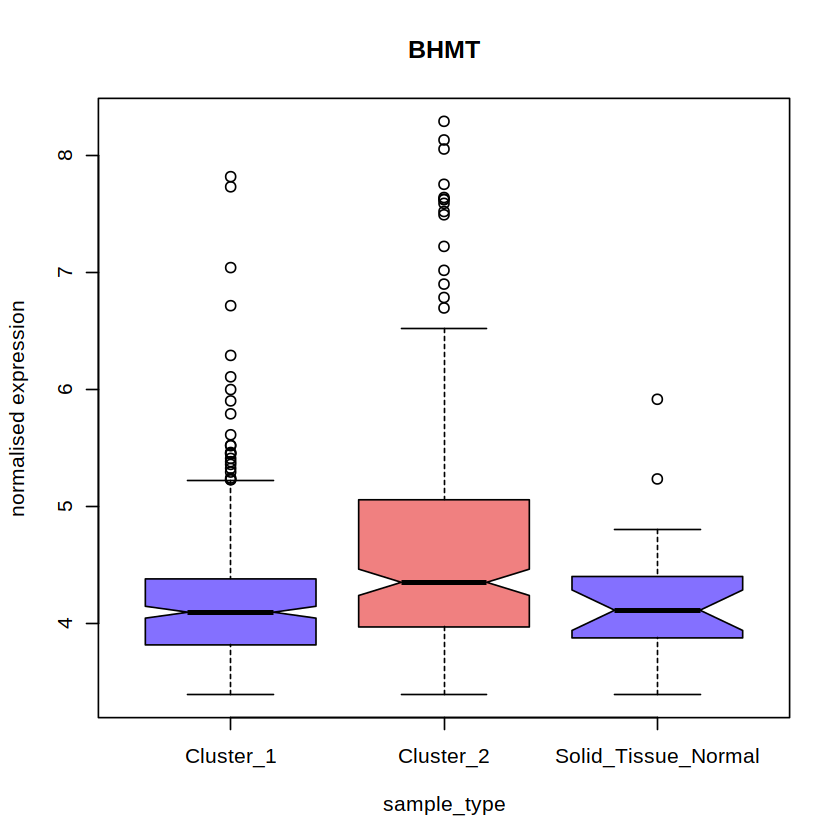

In [191]:
boxplot(ENSG00000145692~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "BHMT",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

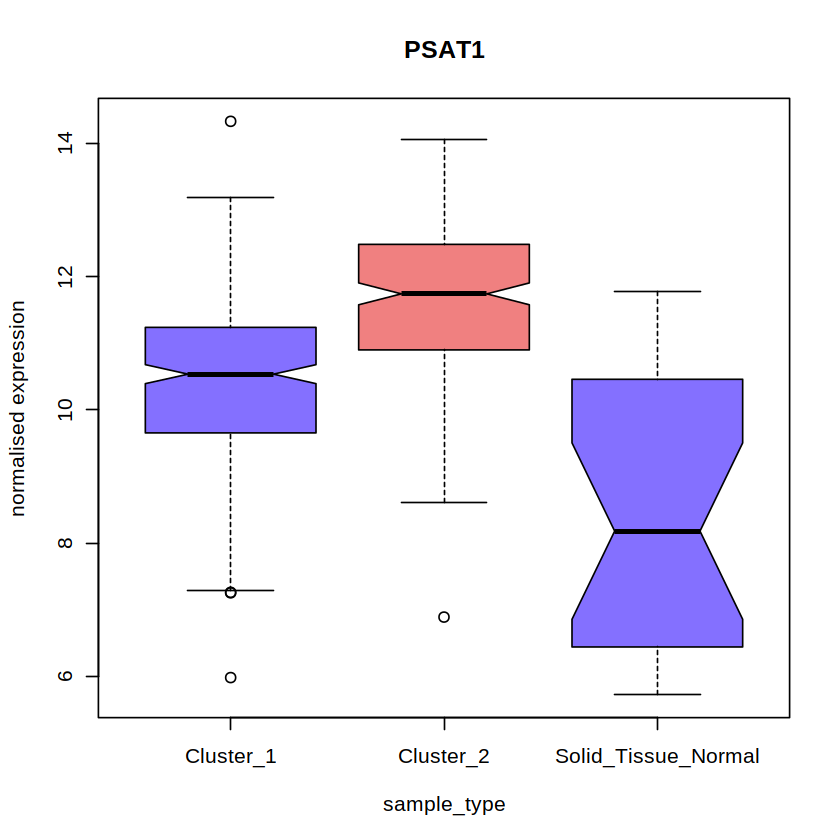

In [192]:
boxplot(ENSG00000135069~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "PSAT1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

Warning message in (function (z, notch = FALSE, width = NULL, varwidth = FALSE, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”


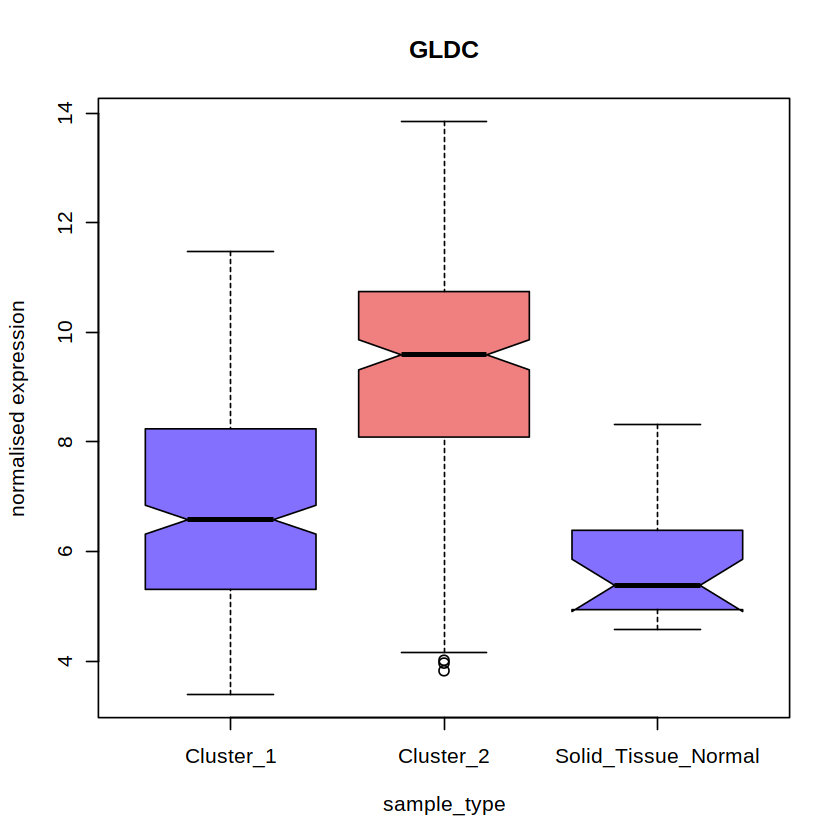

In [194]:
boxplot(ENSG00000178445~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "GLDC",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

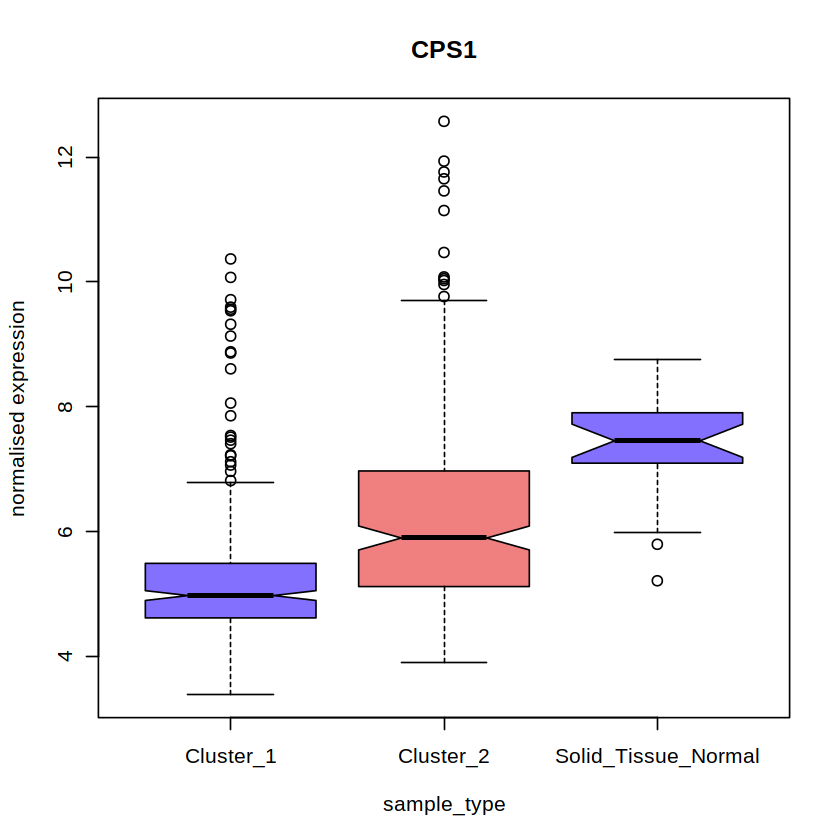

In [196]:
boxplot(ENSG00000021826~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "CPS1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

Warning message in (function (z, notch = FALSE, width = NULL, varwidth = FALSE, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”


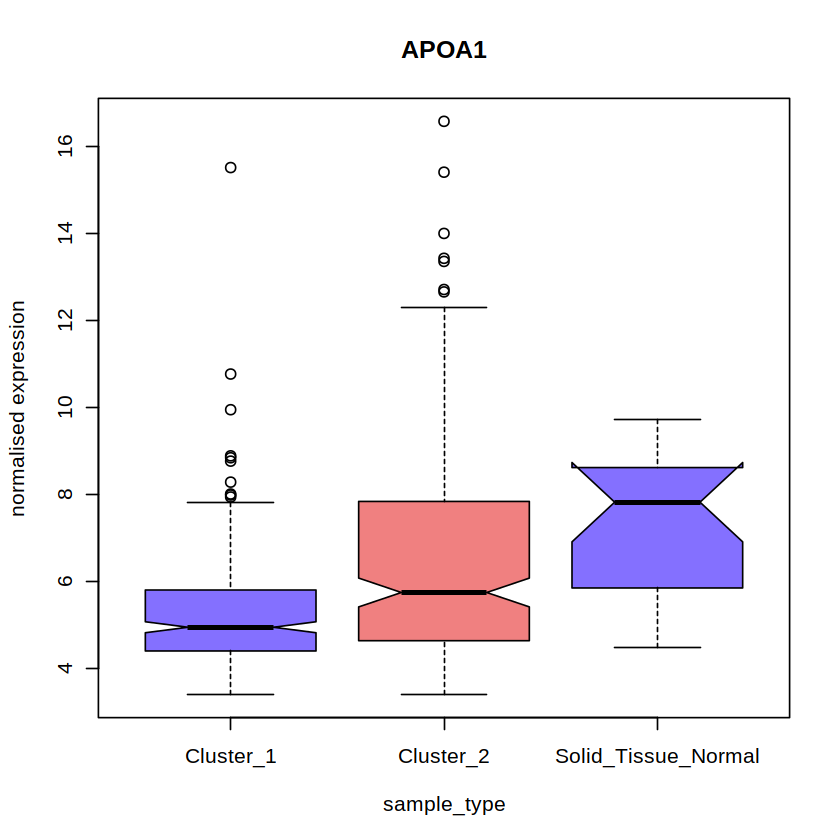

In [197]:
boxplot(ENSG00000118137~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "APOA1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

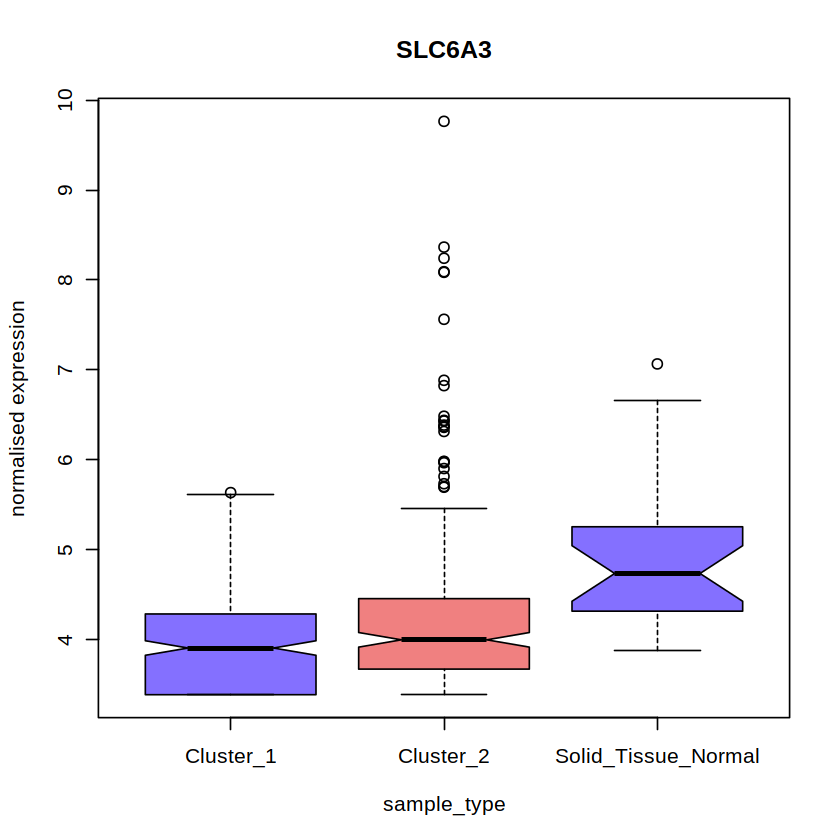

In [204]:
boxplot(ENSG00000142319~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "SLC6A3",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

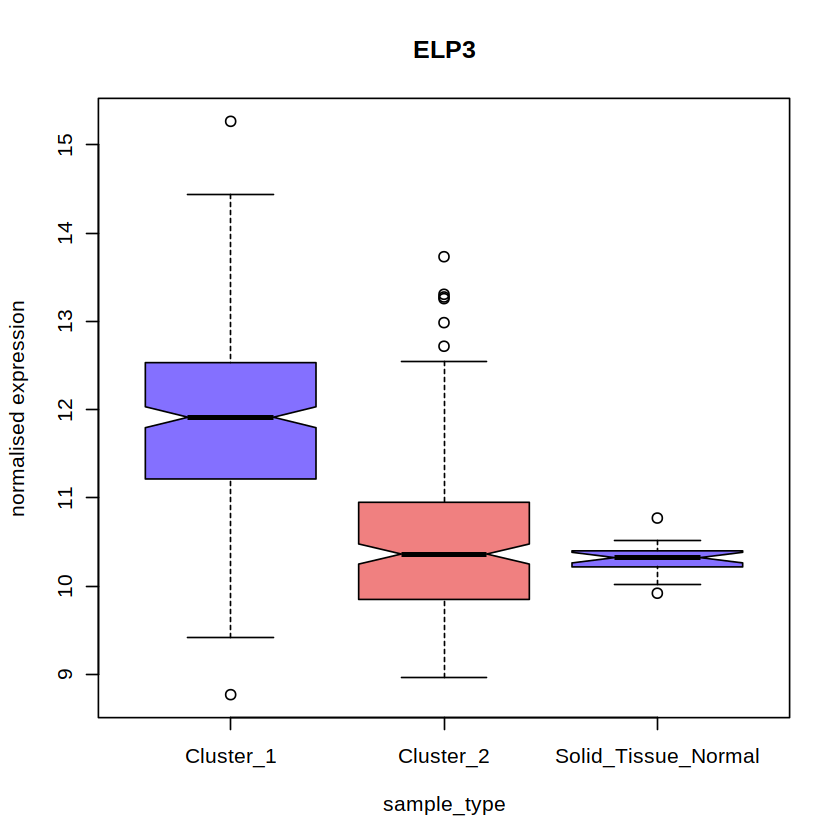

In [205]:
boxplot(ENSG00000134014~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "ELP3",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

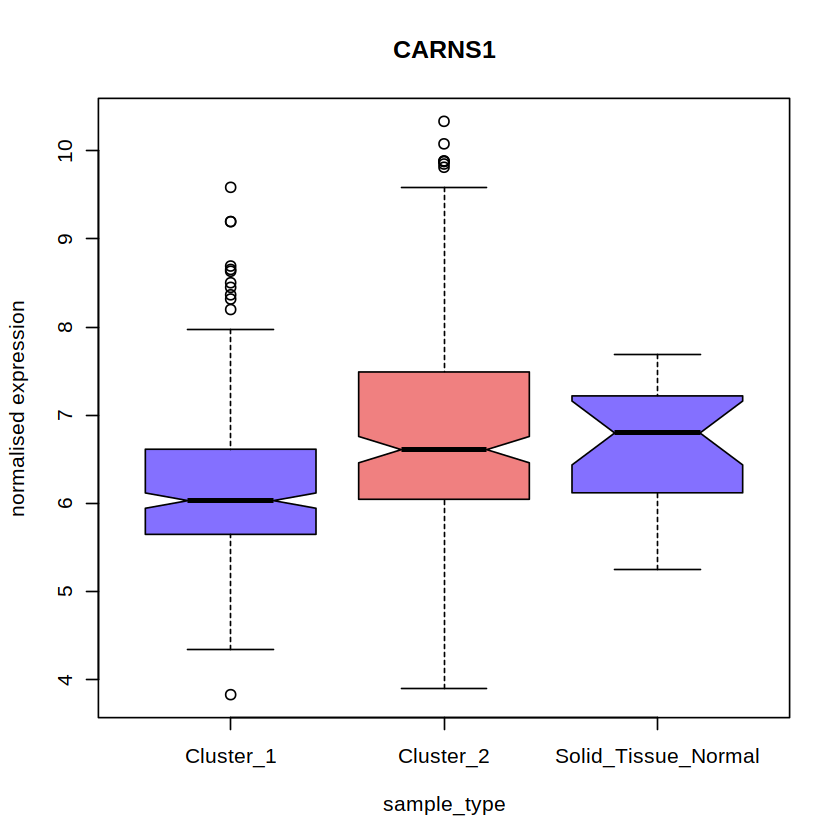

In [217]:
boxplot(ENSG00000172508~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "CARNS1",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

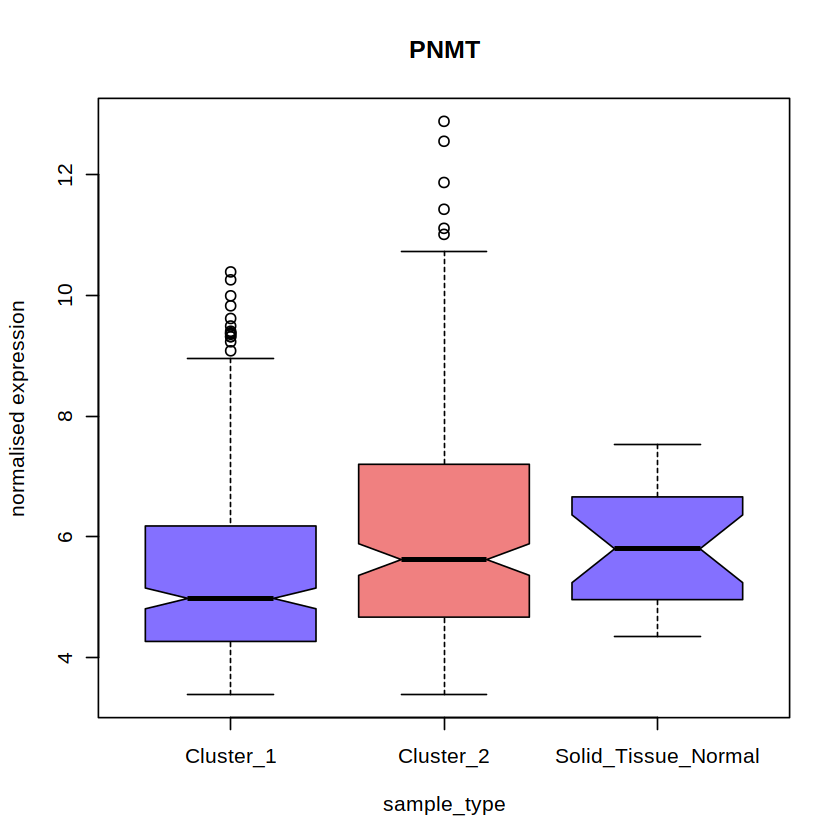

In [220]:
boxplot(ENSG00000141744~nmf_cluster, 
        data = merged_ucec_all_vst_data, xlab = "sample_type",
        ylab = "normalised expression",
        main = "PNMT",  col = c("#8470FF", "#F08080"),
        notch = TRUE, outline = TRUE)

## Gene Set Enrichment Analysis (Pathway Enrichment)

### 1. Pathway database

In [424]:
library("readxl")
library("KEGGREST")
library(EnrichmentBrowser)
library(stringr)

#### A. HMR2

In [434]:
hmr2_db_df <- read_excel('/home/akansha/downloads/metabolic_characterization/HMRdatabase2_00.xlsx')[, 
                                                                c("GENE ASSOCIATION", "SUBSYSTEM", "COMPARTMENT")]
print(dim(hmr2_db_df))
#head(hmr2_db_df,3)

print(table(is.na(hmr2_db_df['SUBSYSTEM'])))

print(table(is.na(hmr2_db_df['GENE ASSOCIATION'])))

hmr2_db_df <- hmr2_db_df[complete.cases(hmr2_db_df),]
hmr2_db_df$compart_pathway <- str_c(hmr2_db_df$COMPARTMENT, "_", hmr2_db_df$SUBSYSTEM)
print(dim(hmr2_db_df))
#head(hmr2_db_df, 3)

cat("\nTotal Number of pathways in HMR2: ", dim(unique(hmr2_db_df['SUBSYSTEM']))[1])
cat("\nTotal Number of compartment-wise pathways in HMR2: ", dim(unique(hmr2_db_df['compart_pathway']))[1])


Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A7709 / R7709C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8171 / R8171C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8176 / R8176C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8177 / R8177C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8183 / R8183C1: got '#'”


[1] 8186    3

FALSE  TRUE 
 8182     4 

FALSE  TRUE 
 6071  2115 
[1] 6071    4

Total Number of pathways in HMR2:  129
Total Number of compartment-wise pathways in HMR2:  298

In [488]:
hmr2_db <- list()
for (sys in unique(hmr2_db_df['compart_pathway'])$compart_pathway){
    hmr2_db[[sys]] <- c(unique(unlist(strsplit(c(filter(hmr2_db_df, SUBSYSTEM == substring(sys, 3,) & COMPARTMENT == substring(sys, 1,1)))[[1]], ';'))))

}
print(length(names(hmr2_db)))
hmr2_db[2]

[1] 298


$`m_Glycolysis / Gluconeogenesis`
 [1] "ENSG00000111058" "ENSG00000154930" "ENSG00000091140" "ENSG00000110435"
 [5] "ENSG00000131828" "ENSG00000150768" "ENSG00000163114" "ENSG00000168291"
 [9] "ENSG00000072210" "ENSG00000111275" "ENSG00000137124" "ENSG00000143149"
[13] "ENSG00000164904"

In [429]:
hmr2_db_df <- read_excel('/home/akansha/downloads/metabolic_characterization/HMRdatabase2_00.xlsx')[, 
                                                                c("GENE ASSOCIATION", "SUBSYSTEM")]
print(dim(hmr2_db_df))
#head(hmr2_db_df,3)

print(table(is.na(hmr2_db_df['SUBSYSTEM'])))

print(table(is.na(hmr2_db_df['GENE ASSOCIATION'])))

hmr2_db_df <- hmr2_db_df[complete.cases(hmr2_db_df),]
print(dim(hmr2_db_df))
#head(hmr2_db_df, 3)

cat("\nTotal Number of pathways in HMR2: ", dim(unique(hmr2_db_df['SUBSYSTEM']))[1])

hmr2_db <- list()
for (sys in unique(hmr2_db_df['SUBSYSTEM'])$SUBSYSTEM){
    hmr2_db[[sys]] <- c(unique(unlist(strsplit(c(hmr2_db_df[hmr2_db_df['SUBSYSTEM'] == sys,
                                                            'GENE ASSOCIATION'])[[1]], ';'))))

}
print(length(names(hmr2_db)))
hmr2_db[2]

Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A7709 / R7709C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8171 / R8171C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8176 / R8176C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8177 / R8177C1: got '#'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in A8183 / R8183C1: got '#'”


[1] 8186    2

FALSE  TRUE 
 8182     4 

FALSE  TRUE 
 6071  2115 
[1] 6071    2

Total Number of pathways in HMR2:  129[1] 129


$`Starch and sucrose metabolism`
 [1] "ENSG00000092529" "ENSG00000171298" "ENSG00000179087" "ENSG00000214013"
 [5] "ENSG00000257335" "ENSG00000109814" "ENSG00000118094" "ENSG00000142102"
 [9] "ENSG00000056998" "ENSG00000163754" "ENSG00000104812" "ENSG00000111713"
[13] "ENSG00000173281" "ENSG00000119938" "ENSG00000114480" "ENSG00000068976"
[17] "ENSG00000100504" "ENSG00000100994" "ENSG00000162688" "ENSG00000120563"
[21] "ENSG00000174876" "ENSG00000187733" "ENSG00000237763" "ENSG00000240038"
[25] "ENSG00000243480" "ENSG00000090402" "ENSG00000165434"

#### B. KEGG

In [235]:
kegg_pathway_db <- getGenesets(org = "hsa", db = "kegg", cache = TRUE, return.type="list")
cat("Total Number of pathways in KEGG: ", length(kegg_pathway_db))

web_kegg_met_db <- read.csv("/home/akansha/downloads/metabolic_characterization/met_subtypes_nmf/kegg_metabolic_pathways.csv")
web_kegg_met_db$X <-NULL
print(dim(web_kegg_met_db))
#head(web_kegg_met_db, 8)

lst_common_met_pathways <- c()
for (pathway in web_kegg_met_db$kegg_Metabolic_pathways){
    com_path <- names(kegg_pathway_db)[grep(strsplit(pathway, '_')[[1]][1] , names(kegg_pathway_db))]
    lst_common_met_pathways <- c(lst_common_met_pathways, com_path)
}
print(length(lst_common_met_pathways))

kegg_met_pathway_db <-  kegg_pathway_db[lst_common_met_pathways]

cat("Total Number of metabolic pathways in KEGG: ", length(kegg_met_pathway_db))
kegg_met_pathway_db[2]

Total Number of pathways in KEGG:  347[1] 185   1
[1] 78
Total Number of metabolic pathways in KEGG:  78

$hsa01200_Carbon_metabolism
  [1] "10873"  "10993"  "113675" "128"    "132158" "1373"   "137362" "1431"  
  [9] "1737"   "1738"   "1743"   "189"    "1892"   "2023"   "2026"   "2027"  
 [17] "2098"   "2203"   "221823" "226"    "2271"   "229"    "22934"  "230"   
 [25] "2539"   "25796"  "2597"   "26007"  "26227"  "26275"  "2645"   "2653"  
 [33] "2731"   "2746"   "2747"   "275"    "2805"   "2806"   "2821"   "283871"
 [41] "2875"   "29968"  "3098"   "3099"   "3101"   "3417"   "3418"   "3419"  
 [49] "3420"   "3421"   "35"     "38"     "387712" "39"     "414328" "4190"  
 [57] "4191"   "4199"   "4200"   "4329"   "441531" "4594"   "48"     "4967"  
 [65] "50"     "5091"   "5095"   "5096"   "51"     "51179"  "5160"   "5161"  
 [73] "5162"   "5211"   "5213"   "5214"   "5223"   "5224"   "5226"   "5230"  
 [81] "5232"   "5313"   "5315"   "54363"  "55753"  "55902"  "5631"   "5634"  
 [89] "5723"   "6120"   "6389"   "6390"   "6391"   "6392"   "6470"   "6472"  
 [97] "6888"   "7086"   "7167"   "729020" "80201"  "8277"   "8310"   "83440" 
[105] "84076"  "84532"  "84693"  "847"    "84706"  "8789"   "8801"   "8802"  
[113] "8803"   "9104"   "9563"

### 2. Functions for Enrichment Analysis

In [351]:
create_contigency_table <- function(n_genes_db, n_genes_pathway, 
                                    n_genes_interest_pathdb, n_genes_interest_pathway){
    
    ## Prepare a two-dimensional contingency table
    contingency.table <- data.frame(matrix(nrow=2, ncol=2))
    colnames(contingency.table) <- c("interesting_genes", "not_interesting_genes")
    rownames(contingency.table) <- c("enriched_pathway", "not_enriched_pathway")
    
    contingency.table["enriched_pathway", "interesting_genes"] <- n_genes_interest_pathway ## Number of marked genes in the selection
    contingency.table["not_enriched_pathway", "interesting_genes"] <- n_genes_interest_pathdb - n_genes_interest_pathway ## Number of non-marked genes in the selection
    contingency.table["enriched_pathway", "not_interesting_genes"] <- n_genes_pathway - n_genes_interest_pathway ## Number of marked genes outside of the selection
    contingency.table["not_enriched_pathway", "not_interesting_genes"] <- n_genes_db - n_genes_interest_pathdb - n_genes_pathway + n_genes_interest_pathway ## Number of non-marked genes in the selection
    #print(contingency.table)
    return (contingency.table)
}

In [237]:
print_contigency_table_marginal_sums <- function(contingency.table){
    ## Create a contingency table with marginal sums
    contingency.row.sum <- apply(contingency.table, 1, sum)
    contingency.col.sum <- apply(contingency.table, 2, sum)
    contingency.table.margins <- cbind(contingency.table, contingency.row.sum)
    contingency.table.margins <- rbind(contingency.table.margins, apply(contingency.table.margins, 2, sum))
    names(contingency.table.margins) <- c(names(contingency.table), "total")
    rownames(contingency.table.margins) <- c(rownames(contingency.table), "total")
    print(contingency.table.margins)
    
}

In [349]:
fischer_exact_test <- function(contigency_table){
    f_test_result <- fisher.test(x=contigency_table, alternative="greater")
    #print(f_test_result)
    return (f_test_result$p.value)
}

#fischer_exact_test(rbind(c(19, 592), c(40, 12937)))

In [387]:
print(fischer_exact_test(rbind(c(9, 52), c(255, 3449))))  # Glycine, serine
fischer_exact_test(rbind(c(12, 49), c(486, 3218)))  # Glycine, serine

[1] 0.02470837


[1] 0.09959576

In [556]:
gsea <- function(lst_genes_submittted, pathwayDB){
    lst_p_values <- c()
    lst_interesting_genes <- list()
    pathwayDB_genes <- unique(unlist(pathwayDB))
    #print(length(pathwayDB_genes))
    
    lst_genes_interest <- intersect(pathwayDB_genes, lst_genes_submittted)
    for (path in seq(1:length(names(pathwayDB)))){
        #print(path)
        pathway_genes <- pathwayDB[[path]]
        genes_of_interest_in_pathway <- intersect(pathway_genes, lst_genes_interest)
        #print(genes_of_interest_in_pathway)
        
        contegency_tb <- create_contigency_table(length(pathwayDB_genes), length(pathway_genes), 
                            length(lst_genes_interest), length(genes_of_interest_in_pathway))
        
        #print(names(pathwayDB)[path])
        #print_contigency_table_marginal_sums(contegency_tb)
        
        lst_p_values <- c(lst_p_values, fischer_exact_test(contegency_tb)) 
        lst_interesting_genes[[path]] <- gene_mapping[genes_of_interest_in_pathway,'external_gene_name']
    }
    adjp_values <- p.adjust(lst_p_values, method = p.adjust.methods[5], n = length(lst_p_values))
    print(length(lst_p_values))
    return (list(lst_p_values, adjp_values, lst_interesting_genes))
}

In [537]:
gsea_result_df <- function(db, p_values, adjp_values, gene_list){ 
    result_df <- data.frame("pathways" = names(db), "p_value" = p_values, 
                             "adj_p_value" = adjp_values)
    result_df$gene_lst <- gene_list
    result_df <- result_df[order(result_df$p_value),]
    result_df <- filter(result_df, p_value != 1)
    #result_df <- result_df[result_df["p_value"]< 0.05,]
    print(dim(result_df))
    return (result_df)
    
}

### Pathway Enrichment Analysis

#### A. HMR2

In [306]:
#print(length(names(hmr2_db)))
#hmr2_db <- hmr2_db[names(hmr2_db) %in% c('Isolated', 'Transport, nuclear',
#                            'Transport, endoplasmic reticular','Transport, mitochondrial',
#                              'Transport, peroxisomal', 'Transport, extracellular',
#                              'Miscellaneous', 'isolated', 'Transport, lysosomal', 
#                              'Transport, Golgi apparatus') == FALSE]
# Remove multiple list elements
#length(names(hmr2_db))

In [305]:
#clust1_hmr2_gsea <- gsea(clust1_genes, hmr2_db)
#clust1_hmr2_gsea_result_df <- gsea_result_df(hmr2_db, clust1_hmr2_gsea[[1]], clust1_hmr2_gsea[[2]])
#clust1_hmr2_gsea_result_df
#write.table(clust1_hmr2_gsea_result_df, file=paste(res_dir,'pathways_clust1_genes_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep = "\t")

In [307]:
#clust2_hmr2_gsea <- gsea(clust2_genes, hmr2_db)
#clust2_hmr2_gsea_result_df <- gsea_result_df(hmr2_db, clust2_hmr2_gsea[[1]], clust2_hmr2_gsea[[2]])
#clust2_hmr2_gsea_result_df
#write.table(clust2_hmr2_gsea_result_df, file=paste(res_dir,'pathways_clust2_genes_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep = "\t")

### Cluster-2 pathway enrichment analysis (HMR2)

In [561]:
hmr2_gsea_up_clust2_1 <- gsea(up_regulated_genes1, hmr2_db)
hmr2_gsea_up_clust2_1_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_up_clust2_1[[1]], 
                                 hmr2_gsea_up_clust2_1[[2]], hmr2_gsea_up_clust2_1[[3]])

hmr2_gsea_up_clust2_1_result_df$gene_lst = as.character(hmr2_gsea_up_clust2_1_result_df$gene_lst)
head(hmr2_gsea_up_clust2_1_result_df, 3)

write.table(hmr2_gsea_up_clust2_1_result_df, file=paste(res_dir,
            'HMR2_pathway_enrichment_results/clust2_up_logFC_1.tsv', 
             sep=''),quote=F, row.names = FALSE, sep = "\t")

[1] 298
[1] 152   4


pathways                   p_value      adj_p_value 
1 s_Transport, extracellular 1.225455e-09 3.651856e-07
2 c_Linoleate metabolism     4.955092e-06 7.383087e-04
3 r_Linoleate metabolism     3.137851e-05 3.116932e-03
  gene_lst                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1 c("APOA1", "APOA2", "SLCO1A2", "SLCO4A1", "SLC22A8", "FABP3", "FABP7", "CA1", "CA4", "ABCG8", "FOLR3", "SLC2A2", "SLC2A7", "SLC6A13", "SLC6A12", "SLC6A11", "SLC17A3", "SLC17A1", "SLC17A4", "SLC34A3", "SLC1A3", "SLC1A6", "SLC14A2", "SLC2A4", "SLC38A4", "SLC7A10", "ATP1A3", "SLC6A15", "SLC38A1", "SLC6A19", "SLC38A3", "SLC17A6", "SLC17A7", "SLC9A3", "SLC10A2", "SLC3A1", "SLC39A5", "SLC12A5", "SLCO1C1", "SLCO3A1", "SLC19A3", "SLC6A3", "SLC36A2", "SLC12A3", "CELSR3", "ATP2B2", "SLC8A1", "SLC24A2", "SLC18A3", \n"SLC6A10P", "SLC22A16", "ATP12A", "SLC22A12")
2 c("PTGS1", "ALOX15B", "GPX3", "CYP2C18", "CYP2C9", "CYP1A2", "CYP4F12", "CYP4F8", "CYP2F1", "UGT2A3", "UGT3A1", "UGT1A6", "UGT3A2", "UGT2A1", "UGT1A1", "UGT1A10")                                                                                                                                                                                                                                                                                                                                                                                                          
3 c("CYP2C18", "CYP2C9", "CYP1A2", "CYP4F12", "CYP4F8", "CYP2F1", "UGT2A3", "UGT3A1", "UGT1A6", "UGT3A2", "UGT2A1", "UGT1A1", "UGT1A10")

In [564]:
hmr2_gsea_down_clust2_1 <- gsea(down_regulated_genes1, hmr2_db)
hmr2_gsea_down_clust2_1_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_down_clust2_1[[1]], 
                                                    hmr2_gsea_down_clust2_1[[2]], hmr2_gsea_down_clust2_1[[3]])

hmr2_gsea_down_clust2_1_result_df$gene_lst = as.character(hmr2_gsea_down_clust2_1_result_df$gene_lst)
head(hmr2_gsea_down_clust2_1_result_df, 3)

write.table(hmr2_gsea_down_clust2_1_result_df, file=paste(res_dir,
            'HMR2_pathway_enrichment_results/clust2_down_logFC_1.tsv', 
             sep=''),quote=F, row.names = FALSE, sep = "\t")

[1] 298
[1] 130   4


pathways                   p_value      adj_p_value
1 g_O-glycan metabolism      0.0001400545 0.04173625 
2 s_Transport, extracellular 0.0012497722 0.18621606 
3 c_Miscellaneous            0.0034794367 0.29880870 
  gene_lst                                                                                                                                                                                                                               
1 c("ST6GALNAC1", "GCNT3", "GCNT1", "GALNT16", "GALNT10", "GALNT4", "POC1B-GALNT4")                                                                                                                                                      
2 c("SLC47A1", "SLC47A2", "CA6", "CA8", "SLC5A1", "AQP10", "AQP5", "SLC1A1", "SLC26A3", "SLC23A1", "SLC43A1", "SLC17A8", "SLC40A1", "SLCO2A1", "SLC6A2", "PLPP2", "SLC26A4", "ATP2C2", "SLC15A2", "SLC5A7", "SLC5A8", "SLC22A4", "ATP4B")
3 c("CA6", "CA8", "ADH6", "ADH7", "ADH4")

In [567]:
hmr2_gsea_all_clust2_1 <- gsea(c(up_regulated_genes1, down_regulated_genes1), hmr2_db)
hmr2_gsea_all_clust2_1_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_all_clust2_1[[1]], 
                                                    hmr2_gsea_all_clust2_1[[2]], hmr2_gsea_all_clust2_1[[3]])

hmr2_gsea_all_clust2_1_result_df$gene_lst = as.character(hmr2_gsea_all_clust2_1_result_df$gene_lst)
head(hmr2_gsea_all_clust2_1_result_df, 3)

write.table(hmr2_gsea_all_clust2_1_result_df, file=paste(res_dir,
            'HMR2_pathway_enrichment_results/clust2_all_logFC_1.tsv', 
             sep=''),quote=F, row.names = FALSE, sep = "\t")

[1] 298
[1] 188   4


pathways                   p_value      adj_p_value 
1 s_Transport, extracellular 2.691980e-12 8.022100e-10
2 g_O-glycan metabolism      1.458829e-05 1.999578e-03
3 c_Linoleate metabolism     2.012998e-05 1.999578e-03
  gene_lst                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 c("APOA1", "APOA2", "SLCO1A2", "SLCO4A1", "SLC47A1", "SLC47A2", "SLC22A8", "FABP3", "FABP7", "CA6", "CA1", "CA4", "CA8", "ABCG8", "FOLR3", "SLC2A2", "SLC2A7", "SLC6A13", "SLC6A12", "SLC6A11", "SLC5A1", "AQP10", "AQP5", "SLC17A3", "SLC17A1", "SLC17A4", "SLC34A3", "SLC1A3", "SLC1A6", "SLC1A1", "SLC26A3", "SLC14A2", "SLC2A4", "SLC23A1", "SLC38A4", "SLC43A1", "SLC7A10", "ATP1A3", "SLC6A15", "SLC38A1", "SLC6A19", "SLC38A3", "SLC17A6", "SLC17A7", "SLC17A8", "SLC9A3", "SLC10A2", "SLC3A1", "SLC40A1", "SLC39A5", \n"SLC12A5", "SLCO1C1", "SLCO3A1", "SLC19A3", "SLCO2A1", "SLC6A2", "SLC6A3", "SLC36A2", "PLPP2", "SLC12A3", "CELSR3", "SLC26A4", "ATP2C2", "ATP2B2", "SLC8A1", "SLC24A2", "SLC15A2", "SLC18A3", "SLC5A7", "SLC5A8", "SLC6A10P", "SLC22A4", "SLC22A16", "ATP12A", "ATP4B", "SLC22A12")
2 c("ST6GALNAC1", "GCNT3", "GCNT1", "GALNT16", "GALNTL5", "GALNT8", "GALNT13", "GALNT14", "GALNT10", "GALNT9", "GALNT17", "GALNT4", "POC1B-GALNT4")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
3 c("PTGS2", "PTGS1", "ALOX15B", "GPX3", "CYP2C18", "CYP2J2", "CYP2C9", "CYP1A2", "CYP4F12", "CYP4F8", "CYP2F1", "CYP2A6", "UGT2A3", "UGT3A1", "UGT1A6", "UGT3A2", "UGT2A1", "UGT1A1", "UGT1A10")

### matched-tumor normal samples

In [568]:
hmr2_gsea_up_mtn <- gsea(mtn_up_regulated_genes1, hmr2_db)
hmr2_gsea_up_mtn_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_up_mtn[[1]], 
                                 hmr2_gsea_up_mtn[[2]], hmr2_gsea_up_mtn[[3]])

hmr2_gsea_up_mtn_result_df$gene_lst = as.character(hmr2_gsea_up_mtn_result_df$gene_lst)
head(hmr2_gsea_up_mtn_result_df, 3)

#write.table(hmr2_gsea_up_mtn_result_df, file=paste(res_dir,
#            'HMR2_pathway_enrichment_results/mTN_up_logFC_1.tsv',sep=''),quote=F,row.names = FALSE, sep = "\t")

[1] 298
[1] 204   4


pathways                          p_value      adj_p_value
1 s_Transport, extracellular        3.593052e-05 0.01070730 
2 c_Fructose and Mannose metabolism 3.751132e-04 0.05589187 
3 c_isolated                        7.927733e-04 0.07874882 
  gene_lst                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1 c("ANGPTL4", "ABCC3", "SLCO1A2", "SLCO1B3", "ABCC1", "SLC22A1", "SLC47A1", "SLC31A1", "ABHD12", "SDC1", "FABP7", "FABP5", "SLC27A4", "FABP9", "CA2", "CA9", "CA6", "CA8", "ABCG1", "SLC16A3", "SLC5A6", "FASN", "SLC29A2", "SLC2A1", "AQP6", "SLC5A1", "AQP5", "AQP2", "SLC20A1", "SLC13A2", "SLC26A7", "SLC26A2", "SLC14A2", "SLC14A1", "SLC2A6", "SLC29A4", "SLC7A1", "SLC7A5", "SLC36A1", "SLC16A10", "SLC7A10", "ATP1A4", "SLC6A15", "SLC6A20", "SLC9A2", "SLC9A4", "SLC5A12", "SLC11A1", "SLC11A2", "SLC39A8", "SLC39A4", \n"SLC12A5", "PLPP2", "SLC12A3", "CELSR3", "SLC4A9", "SLC26A6", "HAS3", "ATP2A1", "SLC18A1", "SLC18A2", "SLC15A1", "SLC18A3", "SLC19A1", "SLC6A8", "SLC6A10P", "SLC22A16", "ATP12A", "ATP4A", "COPE")
2 c("HK2", "TIGAR", "DLX4", "PFKFB4", "PFKFB2", "PFKFB1", "TSTA3")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
3 c("PDIA6", "PDIA4", "PDIA3", "PDIA2", "P4HB")

In [569]:
hmr2_gsea_down_mtn <- gsea(mtn_down_regulated_genes1, hmr2_db)
hmr2_gsea_down_mtn_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_down_mtn[[1]], 
                                 hmr2_gsea_down_mtn[[2]], hmr2_gsea_down_mtn[[3]])

hmr2_gsea_down_mtn_result_df$gene_lst = as.character(hmr2_gsea_down_mtn_result_df$gene_lst)
head(hmr2_gsea_down_mtn_result_df, 3)

#write.table(hmr2_gsea_down_mtn_result_df, file=paste(res_dir,
#            'HMR2_pathway_enrichment_results/mTN_down_logFC_1.tsv', 
#            sep=''),quote=F, row.names = FALSE, sep = "\t")

[1] 298
[1] 184   4


pathways                               p_value      adj_p_value
1 c_Serotonin and melatonin biosynthesis 7.744320e-06 0.002307807
2 c_Protein modification                 1.858203e-04 0.027687232
3 c_Tyrosine metabolism                  6.135693e-04 0.059163130
  gene_lst                                                                                                                                                                                                                                                                                                                                                                            
1 c("ASMT", "CYP1B1", "UST", "CHST8", "CHST4", "CHST9", "NDST3", "HS6ST2", "HS6ST3", "GAL3ST4", "INMT", "MAOB", "MAOA", "ALDH1B1", "AOX1", "ADHFE1", "ADH6", "ADH1A", "ADH1B")                                                                                                                                                                                                        
2 c("FGR", "FYN", "FLT4", "EPHA3", "TIE1", "EPHA6", "TYRO3", "JAK2", "FLT1", "EPHB6", "PDGFRB", "TEK", "KDR", "PDGFRA", "NTRK3", "EPHA5", "FER", "EPHB1", "KIT", "JAK1", "DDR2", "AXL", "SPRYD3", "INSR", "FES", "NTRK1", "PTPN5", "EYA4", "EPM2A", "DUSP1", "PTPRB", "DUSP26", "DUSP5", "PTPRO", "PTPN14", "PTPRR", "PTPRD", "PTPRN2", "DUSP19", "PTPN13", "PTPRM", "PTPRT", "ADPRH")
3 c("MAOB", "AOC3", "MAOA", "ALDH3B1", "ALDH1A3", "AOX1", "TPO", "ADHFE1", "ADH6", "ADH1A", "ADH1B")

In [570]:
hmr2_gsea_all_mtn <- gsea(c(mtn_up_regulated_genes1, mtn_down_regulated_genes1), hmr2_db)
hmr2_gsea_all_mtn_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_all_mtn[[1]], 
                                 hmr2_gsea_all_mtn[[2]], hmr2_gsea_all_mtn[[3]])

hmr2_gsea_all_mtn_result_df$gene_lst = as.character(hmr2_gsea_all_mtn_result_df$gene_lst)
head(hmr2_gsea_all_mtn_result_df, 3)

#write.table(hmr2_gsea_all_mtn_result_df, file=paste(res_dir,
#            'HMR2_pathway_enrichment_results/mTN_all_logFC_1.tsv', 
#             sep=''),quote=F, row.names = FALSE, sep = "\t")

[1] 298
[1] 240   4


pathways                               p_value      adj_p_value
1 s_Transport, extracellular             1.911275e-07 0.000056956
2 c_Serotonin and melatonin biosynthesis 3.064218e-04 0.045656841
3 r_Retinol metabolism                   9.716759e-04 0.096519804
  gene_lst                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1 c("APOA1", "CCN2", "ANGPTL4", "ABCC3", "SLCO1A2", "SLCO1B3", "ABCC1", "SLC22A3", "SLC22A1", "SLC47A1", "SLC47A2", "SLC31A1", "ABHD12", "SDC1", "HSPG2", "LPL", "SLC27A6", "FABP3", "FABP7", "FABP5", "SLC27A4", "FABP9", "CA2", "CA9", "CA6", "CA3", "CA4", "CA8", "AQP7", "ABCG1", "SLC16A7", "SLC16A3", "SLC16A4", "SLC6A13", "SLC6A1", "SLC5A6", "FASN", "SLC28A1", "SLC29A2", "SLC7A2", "SLC2A3", "SLC2A1", "SLC2A13", "AQP6", "SLC5A1", "AQP10", "AQP5", "AQP2", "AQP1", "SLC17A3", "SLC20A1", "SLC1A7", "SLC13A2", \n"SLC26A3", "SLC26A7", "SLC26A2", "AQP9", "SLC14A2", "SLC14A1", "SLC2A4", "SLC23A2", "SLC23A1", "SLC2A6", "SLC29A4", "SLC38A4", "SLC7A1", "SLC7A3", "SLC7A5", "SLC36A1", "SLC16A10", "SLC7A10", "ATP1B2", "ATP1A4", "SLC6A15", "SLC6A20", "SLC9A2", "SLC9A4", "SLC9A9", "SLC5A12", "SLC11A1", "SLC11A2", "SLC39A8", "SLC39A4", "SLC12A4", "SLC12A5", "SLC13A5", "SLC16A2", "SLCO2A1", "SLCO2B1", "SLC6A3", "SLC6A4", "ABCC11", "PLPP1", "PLPP2", "PLPP3", "SLC12A3", "CELSR3", "SLC4A9", "SLC26A6", "SLC4A10", "HAS3", \n"HAS1", "ATP2B4", "ATP2A1", "SLC8A2", "SLC8A1", "SLC24A2", "SLC24A3", "SLC18A1", "SLC18A2", "SLC15A1", "SLC18A3", "SLC19A1", "SLC5A7", "SLC6A8", "SLC6A10P", "SLC22A4", "SLC22A16", "ATP12A", "ATP4A", "ATP4B", "HEPH", "SLC10A6", "COPE")
2 c("ASMT", "CYP1B1", "CYP1A1", "UST", "CHST8", "SULT4A1", "HS6ST1", "CHST4", "CHST9", "NDST3", "HS6ST2", "CHST2", "CHST6", "HS6ST3", "GAL3ST4", "IDO1", "IDO2", "INMT", "MAOB", "MAOA", "ALDH1B1", "AOX1", "ADHFE1", "ADH6", "ADH1A", "ADH1B")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Cluster-wise tumor normal 

In [516]:
hmr2_gsea_up_clust1 <- gsea(clust1_up_regulated_genes1, hmr2_db)
hmr2_gsea_up_clust1_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_up_clust1[[1]], hmr2_gsea_up_clust1[[2]])
hmr2_gsea_up_clust1_result_df
#write.table(hmr2_gsea_up_clust1_result_df, file=paste(res_dir,'pathways_up_clust1_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep = "\t")

[1] 129
[1] 12  3


pathways                                                        
5   Fructose and Mannose metabolism                                 
99  Transport, extracellular                                        
84  Glycerolipid metabolism                                         
97  Transport, mitochondrial                                        
93  Ether lipid metabolism                                          
66  Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)
126 isolated                                                        
12  Pyrimidine metabolism                                           
4   Fructose and mannose metabolism                                 
16  Glycine, serine and threonine metabolism                        
72  Beta oxidation of poly-unsaturated fatty acids (mitochondrial)  
77  Cholesterol biosynthesis 1 (Bloch pathway)                      
    p_value      adj_p_value
5   0.0004036756 0.04175358 
99  0.0006473424 0.04175358 
84  0.0019650622 0.07907048 
97  0.0024517980 0.07907048 
93  0.0043188441 0.11142618 
66  0.0070003700 0.15050795 
126 0.0091014769 0.16772722 
12  0.0253228267 0.40833058 
4   0.0315622134 0.45239173 
16  0.0365128725 0.45435189 
72  0.0387431846 0.45435189 
77  0.0485759392 0.51634228

In [517]:
hmr2_gsea_down_clust1 <- gsea(clust1_down_regulated_genes1, hmr2_db)
hmr2_gsea_down_clust1_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_down_clust1[[1]], hmr2_gsea_down_clust1[[2]])
hmr2_gsea_down_clust1_result_df
#write.table(hmr2_gsea_down_clust1_result_df, file=paste(res_dir,'pathways_down_clust1_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep = "\t")

[1] 129
[1] 10  3


pathways                                   p_value      adj_p_value 
32  Protein modification                       6.404968e-06 0.0006902239
118 Serotonin and melatonin biosynthesis       1.070115e-05 0.0006902239
20  Tyrosine metabolism                        2.921695e-03 0.1256328716
11  Purine metabolism                          1.059927e-02 0.2737393344
99  Transport, extracellular                   1.207824e-02 0.2737393344
100 Chondroitin / heparan sulfate biosynthesis 1.273206e-02 0.2737393344
93  Ether lipid metabolism                     2.838812e-02 0.5231525728
35  Sulfur metabolism                          3.698117e-02 0.5504491764
29  O-glycan metabolism                        4.267048e-02 0.5504491764
125 Miscellaneous                              4.267048e-02 0.5504491764

In [509]:
print_genes(hmr2_gsea_up_clust1_result_df$pathways)

Fructose and Mannose metabolism
Transport, extracellular
Glycerolipid metabolism
Transport, mitochondrial
Ether lipid metabolism
Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)
isolated
Pyrimidine metabolism
Fructose and mannose metabolism
Glycine, serine and threonine metabolism
Beta oxidation of poly-unsaturated fatty acids (mitochondrial)
Cholesterol biosynthesis 1 (Bloch pathway)


In [518]:
hmr2_gsea_up_clust2 <- gsea(clust2_up_regulated_genes1, hmr2_db)
hmr2_gsea_up_clust2_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_up_clust2[[1]], hmr2_gsea_up_clust2[[2]])
hmr2_gsea_up_clust2_result_df
#write.table(hmr2_gsea_up_clust2_result_df, file=paste(res_dir,'pathways_up_clust2_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep ="\t")

[1] 129
[1] 8 3


pathways                                 p_value      adj_p_value 
99  Transport, extracellular                 1.637532e-07 2.112416e-05
5   Fructose and Mannose metabolism          6.651831e-04 4.290431e-02
97  Transport, mitochondrial                 2.162172e-03 9.297341e-02
47  Fatty acid desaturation (even-chain)     1.774513e-02 5.722804e-01
126 isolated                                 2.867947e-02 5.751997e-01
15  Arginine and proline metabolism          3.049846e-02 5.751997e-01
98  Transport, peroxisomal                   3.121238e-02 5.751997e-01
16  Glycine, serine and threonine metabolism 4.810258e-02 7.148430e-01

In [519]:
hmr2_gsea_down_clust2 <- gsea(clust2_down_regulated_genes1, hmr2_db)
hmr2_gsea_down_clust2_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_down_clust2[[1]], hmr2_gsea_down_clust2[[2]])
hmr2_gsea_down_clust2_result_df
#write.table(hmr2_gsea_down_clust2_result_df, file=paste(res_dir,'pathways_down_clust2_hmr2.tsv', sep=''),
#            quote=F, row.names = FALSE, sep = '\t' )

[1] 129
[1] 12  3


pathways                                      p_value      adj_p_value
11  Purine metabolism                             0.0006450232 0.04530653 
118 Serotonin and melatonin biosynthesis          0.0007024268 0.04530653 
32  Protein modification                          0.0014969618 0.06436936 
20  Tyrosine metabolism                           0.0101198304 0.32636453 
86  Glycosphingolipid biosynthesis-ganglio series 0.0154468433 0.36553477 
40  Fatty acid activation (cytosolic)             0.0177909290 0.36553477 
93  Ether lipid metabolism                        0.0198352203 0.36553477 
99  Transport, extracellular                      0.0270839369 0.43672848 
92  prostaglandin biosynthesis                    0.0333434186 0.46952950 
81  Estrogen metabolism                           0.0363976359 0.46952950 
125 Miscellaneous                                 0.0438503745 0.48472627 
33  Protein degradation                           0.0450908161 0.48472627

In [513]:
#print_genes(hmr2_gsea_down_clust2_result_df$pathways)

Purine metabolism
Serotonin and melatonin biosynthesis
Protein modification
Tyrosine metabolism
Glycosphingolipid biosynthesis-ganglio series
Fatty acid activation (cytosolic)
Ether lipid metabolism
Transport, extracellular
prostaglandin biosynthesis
Estrogen metabolism
Miscellaneous
Protein degradation


#### B. KEGG

In [441]:
kegg_gsea_up_clust2_1 <- gsea(hmr2_genes_mapping[up_regulated_genes1,'GENE.ID.2'], kegg_met_pathway_db)
kegg_gsea_up_clust2_1_result_df <-gsea_result_df(kegg_met_pathway_db, kegg_gsea_up_clust2_1[[1]], kegg_gsea_up_clust2_1[[2]])
head(kegg_gsea_up_clust2_1_result_df, 5)

[1] 78
[1] 5 3


pathways                                          p_value    adj_p_value
57 hsa00512_Mucin_type_O-glycan_biosynthesis         0.01172392 0.5363282  
45 hsa00220_Arginine_biosynthesis                    0.01691485 0.5363282  
40 hsa00260_Glycine,_serine_and_threonine_metabolism 0.02062801 0.5363282  
11 hsa00040_Pentose_and_glucuronate_interconversions 0.03031086 0.5910618  
36 hsa01040_Biosynthesis_of_unsaturated_fatty_acids  0.03894316 0.6075133

In [443]:
kegg_gsea_up_clust2_1 <- gsea(hmr2_genes_mapping[up_regulated_genes1,'GENE.ID.2'], kegg_pathway_db)
kegg_gsea_up_clust2_1_result_df <-gsea_result_df(kegg_pathway_db, kegg_gsea_up_clust2_1[[1]], kegg_gsea_up_clust2_1[[2]])
head(kegg_gsea_up_clust2_1_result_df, 10)

[1] 345
[1] 69  3


pathways                                              p_value     
86  hsa01100_Metabolic_pathways                           1.458092e-33
258 hsa04976_Bile_secretion                               1.510986e-08
204 hsa04721_Synaptic_vesicle_cycle                       1.719862e-06
76  hsa00830_Retinol_metabolism                           3.493355e-06
306 hsa05204_Chemical_carcinogenesis                      4.003331e-06
210 hsa04727_GABAergic_synapse                            6.452697e-06
56  hsa00590_Arachidonic_acid_metabolism                  1.060421e-05
250 hsa04964_Proximal_tubule_bicarbonate_reclamation      1.102616e-05
82  hsa00980_Metabolism_of_xenobiotics_by_cytochrome_P450 1.234144e-05
41  hsa00512_Mucin_type_O-glycan_biosynthesis             1.621654e-05
    adj_p_value 
86  5.030418e-31
258 2.606451e-06
204 1.977841e-04
76  2.762299e-04
306 2.762299e-04
210 3.710301e-04
56  4.730886e-04
250 4.730886e-04
82  4.730886e-04
41  5.594707e-04

In [450]:
hmr2_gsea_uni_down_clust2 <- gsea(uniq_c2_down_genes, hmr2_db)
hmr2_gsea_uni_down_clust2_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_uni_down_clust2[[1]], 
                                                  hmr2_gsea_uni_down_clust2[[2]])
head(hmr2_gsea_uni_down_clust2_result_df, 4)

[1] 129
[1] 4 3


pathways                                                 p_value    
122 Vitamin D metabolism                                     0.002315536
116 Retinol metabolism                                       0.034018752
86  Glycosphingolipid biosynthesis-ganglio series            0.039798907
88  Glycosphingolipid biosynthesis-lacto and neolacto series 0.039798907
    adj_p_value
122 0.2987041  
116 1.0000000  
86  1.0000000  
88  1.0000000

In [451]:
hmr2_gsea_uni_up_clust2 <- gsea(uniq_c2_up_genes, hmr2_db)
hmr2_gsea_uni_up_clust2_result_df <- gsea_result_df(hmr2_db, hmr2_gsea_uni_up_clust2[[1]], 
                                                  hmr2_gsea_uni_up_clust2[[2]])
head(hmr2_gsea_uni_up_clust2_result_df, 1)

[1] 129
[1] 1 3


pathways                 p_value     adj_p_value
99 Transport, extracellular 0.002016078 0.2600741

In [96]:
tn_dds_res_tb$external_gene_name <- gene_mapping[rownames(tn_dds_res_tb),'external_gene_name']
tn_dds_res_tb$entrez_id <- hmr2_genes_mapping[rownames(tn_dds_res_tb),'GENE.ID.2']
tn_dds_res_tb$hmr2_gene_names <- hmr2_genes_mapping[rownames(tn_dds_res_tb),'SHORT.NAME']
#write.csv(tn_dds_res_tb, file=paste(res_dir,'TN_deseq2_result.csv', sep=''),quote=F)

In [280]:
clust1_dds_res_tb$external_gene_name <- gene_mapping[rownames(clust1_dds_res_tb),'external_gene_name']
clust1_dds_res_tb$entrez_id <- hmr2_genes_mapping[rownames(clust1_dds_res_tb),'GENE.ID.2']
clust1_dds_res_tb$hmr2_gene_names <- hmr2_genes_mapping[rownames(clust1_dds_res_tb),'SHORT.NAME']
#write.csv(clust1_dds_res_tb, file=paste(res_dir,'clust1_deseq2_result.csv', sep=''),quote=F)

In [282]:
clust2_dds_res_tb$external_gene_name <- gene_mapping[rownames(clust2_dds_res_tb),'external_gene_name']
clust2_dds_res_tb$entrez_id <- hmr2_genes_mapping[rownames(clust2_dds_res_tb),'GENE.ID.2']
clust2_dds_res_tb$hmr2_gene_names <- hmr2_genes_mapping[rownames(clust2_dds_res_tb),'SHORT.NAME']
#write.csv(clust2_dds_res_tb, file=paste(res_dir,'clust2_deseq2_result.csv', sep=''),quote=F)

## PCA

### 3. Two clusters

In [25]:
prim_clinical_clusters <- read.csv(paste(res_dir,'prim_clinical_cluster_assign_data.csv', sep=''))
rownames(prim_clinical_clusters) <- prim_clinical_clusters$X
prim_clinical_clusters <- prim_clinical_clusters[,-1]
print(dim(prim_clinical_clusters))
table(prim_clinical_clusters$nmf_cluster)

[1] 542  14



Cluster_1 Cluster_2 
      309       233 

#### A. All metabolic Genes

In [36]:
pca_df3 = merge(t(ucec_vst_data) , prim_clinical_clusters["nmf_cluster"], by="row.names") 
row.names(pca_df3) = pca_df3$Row.names
pca_df3 = pca_df3[, -1]
print(dim(pca_df3))
#pca_df
pca_res3 <- prcomp( pca_df3[, - 3585], center = TRUE, scale. = TRUE)

[1]  542 3585


In [38]:
pca_plot_file5 <- file.path(paste(res_dir, 'pca_2clust_all_met_plot_boundary.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file5, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res3, data = pca_df3, colour = 'nmf_cluster', frame = TRUE)

# Close the PNG file:
dev.off()

png 
  2

In [39]:
pca_plot_file6 <- file.path(paste(res_dir, 'pca_2clust_all_met_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file6, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res3, data = pca_df3, colour = 'nmf_cluster')

# Close the PNG file:
dev.off()

png 
  2

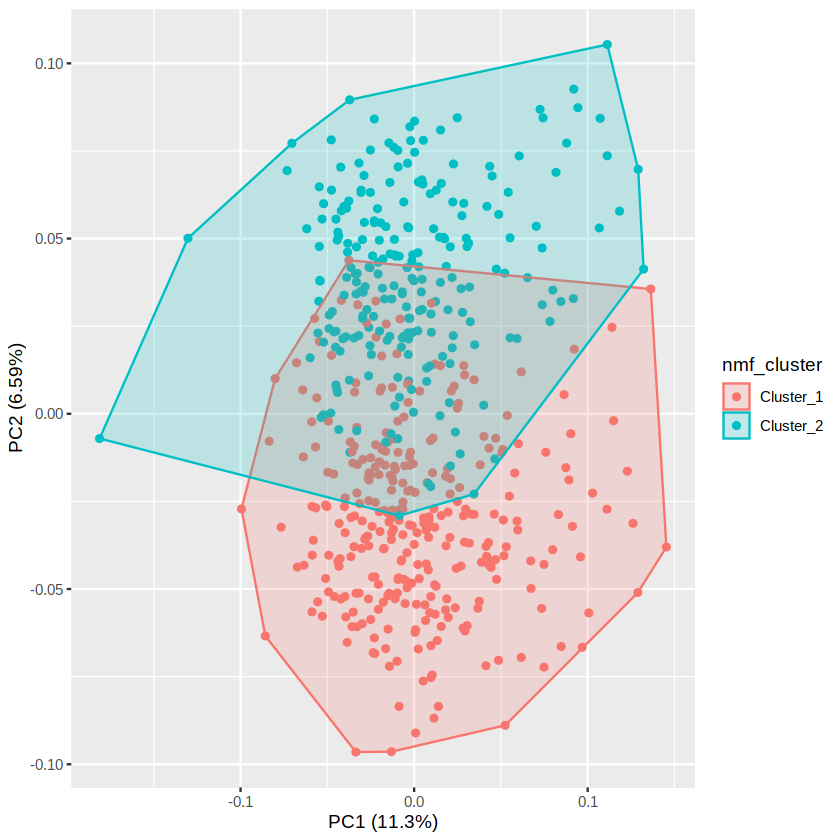

In [37]:
autoplot(pca_res3, data = pca_df3, colour = 'nmf_cluster', frame = TRUE)

#### B. MAD GENES

In [40]:
pca_df4 = merge(t(ucec_vst_data[ucec_top_mad_genes,]) , prim_clinical_clusters["nmf_cluster"], by="row.names") 
row.names(pca_df4) = pca_df4$Row.names
pca_df4 = pca_df4[, -1]
print(dim(pca_df4))
pca_res4 <- prcomp( pca_df4[, -1001], center = TRUE, scale. = TRUE)

[1]  542 1001


In [41]:
pca_plot_file7 <- file.path(paste(res_dir, 'pca_2clust_MAD_met_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file7, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res4, data = pca_df4, colour = 'nmf_cluster')

# Close the PNG file:
dev.off()

png 
  2

In [43]:
pca_plot_file8 <- file.path(paste(res_dir, 'pca_2clust_MAD_met_plot_boundary.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(pca_plot_file8, height = 5, width = 5, units = 'in', res=600)

# Print your heatmap
autoplot(pca_res4, data = pca_df4, colour = 'nmf_cluster', frame = TRUE)

# Close the PNG file:
dev.off()

png 
  2

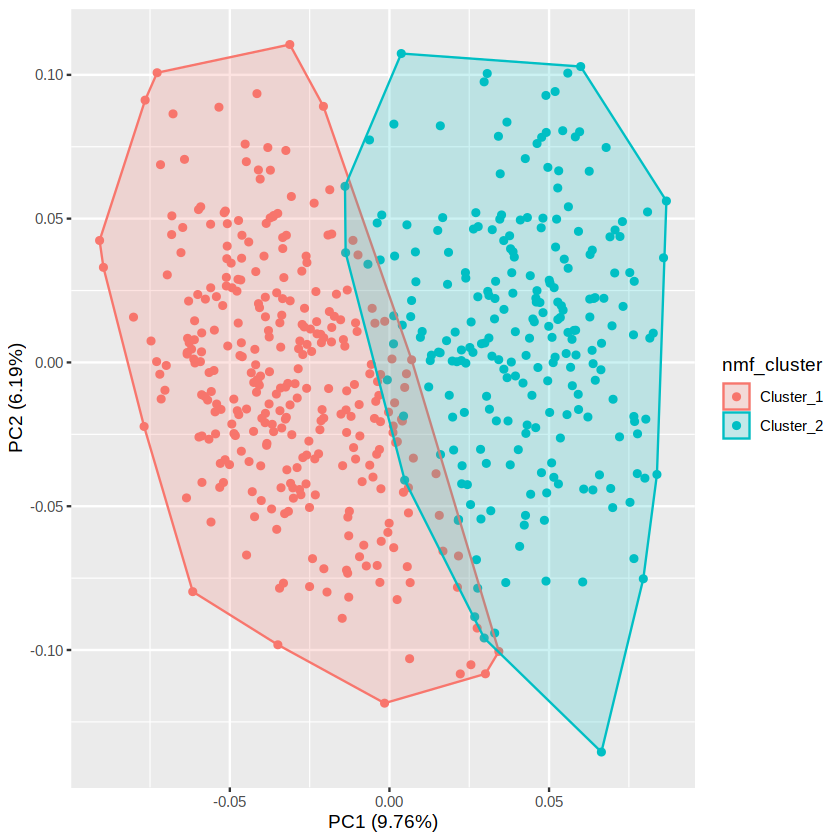

In [44]:
autoplot(pca_res4, data = pca_df4, colour = 'nmf_cluster', frame = TRUE)

## Univariate Cox Regression

In [57]:
vst_exp_surv <- as.data.frame(t(ucec_vst_data[union(up_regulated_genes1, ucec_top_mad_genes),]))
print(dim(vst_exp_surv))
#vst_exp_surv

[1]  542 1124


In [607]:
vst_exp_surv1 <- as.data.frame(t(ucec_vst_data[rownames(sig_res1),]))
print(dim(vst_exp_surv1))
#vst_exp_surv

[1] 542 401


In [96]:
res.cox <- coxph(Surv(ucec_prim_clinical_data$OS.time, 
                      ucec_prim_clinical_data$OS) ~ vst_exp_surv[,"ENSG00000106633"])
res.cox

Call:
coxph(formula = Surv(ucec_prim_clinical_data$OS.time, ucec_prim_clinical_data$OS) ~ 
    vst_exp_surv[, "ENSG00000106633"])

                                     coef exp(coef) se(coef)     z       p
vst_exp_surv[, "ENSG00000106633"] 0.20541   1.22803  0.06522 3.149 0.00164

Likelihood ratio test=8.62  on 1 df, p=0.003329
n= 542, number of events= 91 

In [97]:
summary(res.cox)

Call:
coxph(formula = Surv(ucec_prim_clinical_data$OS.time, ucec_prim_clinical_data$OS) ~ 
    vst_exp_surv[, "ENSG00000106633"])

  n= 542, number of events= 91 

                                     coef exp(coef) se(coef)     z Pr(>|z|)   
vst_exp_surv[, "ENSG00000106633"] 0.20541   1.22803  0.06522 3.149  0.00164 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                                  exp(coef) exp(-coef) lower .95 upper .95
vst_exp_surv[, "ENSG00000106633"]     1.228     0.8143     1.081     1.395

Concordance= 0.585  (se = 0.035 )
Likelihood ratio test= 8.62  on 1 df,   p=0.003
Wald test            = 9.92  on 1 df,   p=0.002
Score (logrank) test = 10.09  on 1 df,   p=0.001


In [58]:
row = 1
mat = matrix(ncol = 6, nrow = 0)  
univariate_res  = data.frame(mat)
colnames(univariate_res) <- c("Gene", "coeficient_beta", "Hazard_Ratio", "wald.test", "p.value", "Ensembl_id")
for (col in colnames(vst_exp_surv)){
    res.cox <- coxph(Surv(ucec_prim_clinical_data$OS.time, 
                      ucec_prim_clinical_data$OS) ~ vst_exp_surv[,col])
    res.cox <- summary(res.cox)
    p.value<-  signif(res.cox$wald["pvalue"], digits=2)
    wald.test<-signif(res.cox$wald["test"], digits=2)
    beta<-signif(res.cox$coef[1], digits=2);#coeficient beta
    HR <-signif(res.cox$coef[2], digits=2);#exp(beta)
    res<-c(gene_mapping[col ,'external_gene_name'], beta, HR, wald.test, p.value, col)
    univariate_res[row, ] <- res
    row <- row + 1
    
}

univariate_res[, c("coeficient_beta", "Hazard_Ratio", "wald.test", "p.value")]  <- lapply(univariate_res[, 
                                c("coeficient_beta", "Hazard_Ratio", "wald.test", "p.value")] ,as.numeric)
sig_univariate_res <- filter(univariate_res, p.value < 0.05)
print(dim(sig_univariate_res))
head(sig_univariate_res,4)

[1] 396   6


Gene     coeficient_beta Hazard_Ratio wald.test p.value Ensembl_id     
1 AOC1     0.082           1.1           5.4      0.0200  ENSG00000002726
2 SLC22A16 0.160           1.2           8.6      0.0034  ENSG00000004809
3 CELSR3   0.230           1.3           6.1      0.0140  ENSG00000008300
4 SLC6A13  0.190           1.2          10.0      0.0014  ENSG00000010379

In [608]:
row = 1
mat = matrix(ncol = 6, nrow = 0)  
univariate_res  = data.frame(mat)
colnames(univariate_res) <- c("Gene", "coeficient_beta", "Hazard_Ratio", "wald.test", "p.value", "Ensembl_id")
for (col in colnames(vst_exp_surv1)){
    res.cox <- coxph(Surv(ucec_prim_clinical_data$OS.time, 
                      ucec_prim_clinical_data$OS) ~ vst_exp_surv1[,col])
    res.cox <- summary(res.cox)
    p.value<-  signif(res.cox$wald["pvalue"], digits=2)
    wald.test<-signif(res.cox$wald["test"], digits=2)
    beta<-signif(res.cox$coef[1], digits=2);#coeficient beta
    HR <-signif(res.cox$coef[2], digits=2);#exp(beta)
    res<-c(gene_mapping[col ,'external_gene_name'], beta, HR, wald.test, p.value, col)
    univariate_res[row, ] <- res
    row <- row + 1
    
}

univariate_res[, c("coeficient_beta", "Hazard_Ratio", "wald.test", "p.value")]  <- lapply(univariate_res[, 
                                c("coeficient_beta", "Hazard_Ratio", "wald.test", "p.value")] ,as.numeric)
sig_univariate_res <- filter(univariate_res, p.value < 0.05)
print(dim(sig_univariate_res))
head(sig_univariate_res,4)

[1] 225   6


Gene     coeficient_beta Hazard_Ratio wald.test p.value Ensembl_id     
1 HS3ST1   -0.150          0.86         4.2       0.0410  ENSG00000002587
2 AOC1      0.082          1.10         5.4       0.0200  ENSG00000002726
3 SLC22A16  0.160          1.20         8.6       0.0034  ENSG00000004809
4 CELSR3    0.230          1.30         6.1       0.0140  ENSG00000008300

In [610]:
#write.csv(univariate_res, file=paste(res_dir,'DEGs_results/univariate_results.csv', sep=''),quote=F, row.names = FALSE)
#write.csv(sig_univariate_res, file=paste(res_dir,'DEGs_results/prognostic_DEGs_table.csv', sep=''),quote=F, row.names = FALSE)

In [62]:
table(sig_univariate_res$Hazard_Ratio > 1)


FALSE  TRUE 
   69   156 

In [151]:
"LPCAT2" %in% print_genes(high_exp_better_surv_genes)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'table' in selecting a method for function '%in%': object 'high_exp_better_surv_genes' not found


In [59]:
table(sig_univariate_res$coeficient_beta > 0)


FALSE  TRUE 
  129   267 

In [67]:
high_exp_better_surv_genes <- filter(sig_univariate_res, coeficient_beta < 0)$Gene
high_exp_poor_surv_genes <- filter(sig_univariate_res, coeficient_beta > 0)$Gene
print(length(high_exp_better_surv_genes))
print(length(high_exp_poor_surv_genes))

[1] 69
[1] 156


In [344]:
high_exp_better_surv_genes

[1] "PLA2G2D"    "TMEM91"     "TPST2"      "MPST"       "CYB5R1"    
  [6] "DECR2"      "UAP1L1"     "CTSB"       "TRPM2"      "MANSC1"    
 [11] "ABHD6"      "GMDS"       "LCAT"       "ARSA"       "HHAT"      
 [16] "MAST4"      "ADH4"       "TST"        "GALNT7"     "CHST3"     
 [21] "ABCG1"      "DPM3"       "FKBP11"     "HNMT"       "ATP5F1D"   
 [26] "GCNT2"      "NME3"       "FADS2"      "NAAA"       "CHDH"      
 [31] "EPHX1"      "INPP5D"     "ART3"       "STARD10"    "USP43"     
 [36] "MAN1C1"     "CYP27A1"    "FGR"        "ADCY4"      "DUSP6"     
 [41] "SLC22A4"    "ZDHHC1"     "SRD5A3"     "PTPN22"     "A4GALT"    
 [46] "BMX"        "PLA2G10"    "CRAT"       "GALNT10"    "SAT1"      
 [51] "PLPP2"      "LCK"        "CUBN"       "GALNT12"    "DHRS3"     
 [56] "PLCE1"      "INMT"       "ITK"        "PMM1"       "PAM"       
 [61] "ACP5"       "GSTA3"      "GPCPD1"     "ATP8B3"     "AK8"       
 [66] "LPCAT2"     "EYA2"       "TREH"       "SLC1A1"     "CTSW"      
 [71] "B4GALNT3"   "PTPN7"      "ELP3"       "ST6GALNAC2" "ZAP70"     
 [76] "GALNT4"     "NME5"       "CYP2D6"     "SLC6A2"     "B4GALT1"   
 [81] "GCNT1"      "PTPRC"      "AK7"        "ADH6"       "BMPR1B"    
 [86] "HS3ST1"     "ASRGL1"     "CA8"        "FBP1"       "FRMPD2"    
 [91] "TTLL10"     "ATP2C2"     "PIK3R1"     "MAOB"       "AMT"       
 [96] "GLYATL1"    "SLC23A1"    "DIO2"       "SMPD3"      "ATP6V1C2"  
[101] "ACY3"       "CA12"       "ALDH3A1"    "ENTPD3"     "HGD"       
[106] "MOXD1"      "CTSV"       "PLA2G4A"    "FMO6P"      "TRMT9B"    
[111] "ACSL5"      "PLPPR3"     "CHST6"      "AQP5"       "SLC43A1"   
[116] "GCNT3"      "APOBEC4"    "NT5E"       "PTGDS"      "GALNT16"   
[121] "CES3"       "PPP2R2C"    "ENPP3"      "GAD1"       "B3GALT5"   
[126] "SLC5A1"     "ALPP"       "SLC47A1"    "GLYATL2"

In [345]:
high_exp_poor_surv_genes

[1] "AOC1"       "SLC22A16"   "CELSR3"     "SLC6A13"    "CPS1"      
  [6] "INSRR"      "OTC"        "DGKG"       "SLC9A3"     "PDZD4"     
 [11] "FGFR3"      "CHAT"       "SLC12A3"    "MGAT4A"     "SLC6A15"   
 [16] "RPS6KA6"    "SPEG"       "TRHDE"      "PAK3"       "SLC1A3"    
 [21] "EPHA6"      "LRP2"       "AURKA"      "SLC17A6"    "CPA1"      
 [26] "PTGS1"      "MYO3A"      "EEF1A2"     "CDC25B"     "TRIB3"     
 [31] "ST8SIA5"    "CLC"        "ATP1A3"     "MAST1"      "EPHB6"     
 [36] "GCK"        "NEURL1"     "DLX4"       "SULT1E1"    "SLC6A12"   
 [41] "SLC38A1"    "UST"        "B3GAT2"     "EYA4"       "TTK"       
 [46] "RBP2"       "BCHE"       "GLS"        "ATP6V1B1"   "CHD5"      
 [51] "DNAJC6"     "ELOVL4"     "ELOVL3"     "SLC12A5"    "SLC17A3"   
 [56] "SLC17A1"    "GALNT8"     "GDPD2"      "PXDN"       "HELZ2"     
 [61] "ASS1"       "DUSP9"      "SLC7A10"    "COX4I2"     "SLC6A11"   
 [66] "DDC"        "GUCY2D"     "RHBG"       "SLC14A2"    "ATP8A2"    
 [71] "EPHB2"      "CA1"        "DUSP26"     "PSAT1"      "UGT2A3"    
 [76] "B4GALNT1"   "SLC19A3"    "KHK"        "CDKL2"      "SLC39A5"   
 [81] "CYP1A2"     "MAPK4"      "ERBB2"      "PNMT"       "SLC6A3"    
 [86] "PADI3"      "DEGS1"      "MBOAT2"     "GALNT13"    "UGT3A1"    
 [91] "BHMT"       "SLC17A4"    "SLC22A8"    "PLCH2"      "DUSP15"    
 [96] "PDE3B"      "AK5"        "EPHB1"      "ADCY8"      "PPP2R2B"   
[101] "ATP2B2"     "GALNT14"    "HPD"        "CBS"        "IP6K3"     
[106] "HFM1"       "PRKCI"      "PTPN13"     "NDST3"      "ELOVL7"    
[111] "PIP5KL1"    "ART5"       "NPR1"       "METTL7B"    "ALK"       
[116] "MACROD2"    "HPSE"       "UBE2C"      "GAL3ST3"    "SLCO3A1"   
[121] "ZDHHC22"    "GLDC"       "MKRN3"      "TH"         "RNF182"    
[126] "CHST13"     "MAP3K15"    "AATK"       "SLC2A4"     "MGAT4C"    
[131] "LIPF"       "GALNT9"     "SLC8A1"     "EPHA10"     "MARCH11"   
[136] "AC139530.1" "GRK1"       "CYP4F12"    "CYP4F8"     "SLC18A3"   
[141] "SLC38A3"    "PTPRT"      "NUDT11"     "WNK3"       "ADA"       
[146] "SLC2A7"     "ELOVL2"     "NTRK1"      "DUSP27"     "L1CAM"     
[151] "PLPP4"      "NEU4"       "SLC6A10P"   "UGT1A1"     "GSTA2"     
[156] "MGAM"       "GGT7"       "CDC25A"     "CDKL5"      "STK32C"    
[161] "TICRR"      "NSUN5P2"    "OAT"        "POLQ"       "MAP3K21"   
[166] "MCM2"       "SPTLC3"     "PTPRN"      "B3GNT5"     "UBE2S"     
[171] "BUB1"       "USP51"      "MELK"       "GAL3ST2"    "ITPKA"     
[176] "CDKN3"      "PFKM"       "B4GALT6"    "BUB1B"      "AQP4"      
[181] "B4GALNT2"   "PRKAA2"     "CAMKK1"     "FRK"        "PIP4P2"    
[186] "SHPRH"      "PGLYRP4"    "GGH"        "GALNT18"    "CDC7"      
[191] "PLK1"       "ACACB"      "CA3"        "LPO"        "CYP8B1"    
[196] "SLC16A4"    "ATP11B"     "DCLK2"      "DHDH"       "RNF128"    
[201] "STK26"      "DAGLA"      "ATAD2"      "EPHX2"      "ST3GAL1"   
[206] "CDK14"      "PGAP1"      "DHCR24"     "SLC6A9"     "RNF152"    
[211] "SLC22A15"   "PHGDH"      "UBE2E2"     "PTP4A3"     "ST6GALNAC3"
[216] "ALDH1L2"    "AK4"        "SLC2A1"     "GFPT2"      "NTRK3"     
[221] "ACAA2"      "CAMK1D"     "BRSK2"      "UBE2U"      "ABCC4"     
[226] "CYP26B1"    "SLC36A4"    "SMARCD3"    "SLC2A12"    "CDK6"      
[231] "DGAT2"      "SLC22A3"    "ATP1B2"     "RBP4"       "CMPK2"     
[236] "B3GNT8"     "SDR16C5"    "PNCK"       "PRKAR2B"    "ZDHHC15"   
[241] "ZDHHC11B"   "BRSK1"      "SLC9A4"     "FAR2"       "CYP4F3"    
[246] "ME1"        "SLC16A1"    "CKMT1A"     "CKMT1B"     "SLC16A10"  
[251] "RET"        "ADCY9"      "LIPG"       "EPHA4"      "CHST9"     
[256] "PLA2G4F"    "SLC44A5"    "SLC7A8"     "ATP10B"     "DCLK1"     
[261] "BBOX1"      "ERBB4"      "PTGIS"      "SLC26A7"    "PPP1R1A"   
[266] "FABP6"      "CFTR"

In [349]:
chdh = as.data.frame(t(ucec_vst_data["ENSG00000016391", ]))
summary(chdh)

 ENSG00000016391 
 Min.   : 2.967  
 1st Qu.: 8.363  
 Median : 9.171  
 Mean   : 9.050  
 3rd Qu.: 9.825  
 Max.   :12.255  

In [350]:
chdh$binary<- ifelse(chdh$ENSG00000016391 > 9.171,"high","low")
#head(chdh,3)

# Fitting the survival model
ucec_surv_fun_chdh = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ chdh$binary)
ucec_surv_fun_chdh

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    chdh$binary)

                   n events median 0.95LCL 0.95UCL
chdh$binary=high 271     36     NA    9.38      NA
chdh$binary=low  271     55   9.18    8.53      NA

In [351]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ chdh$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ chdh$binary)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
chdh$binary=high 271       36     45.6      2.01      4.04
chdh$binary=low  271       55     45.4      2.02      4.04

 Chisq= 4  on 1 degrees of freedom, p= 0.04 

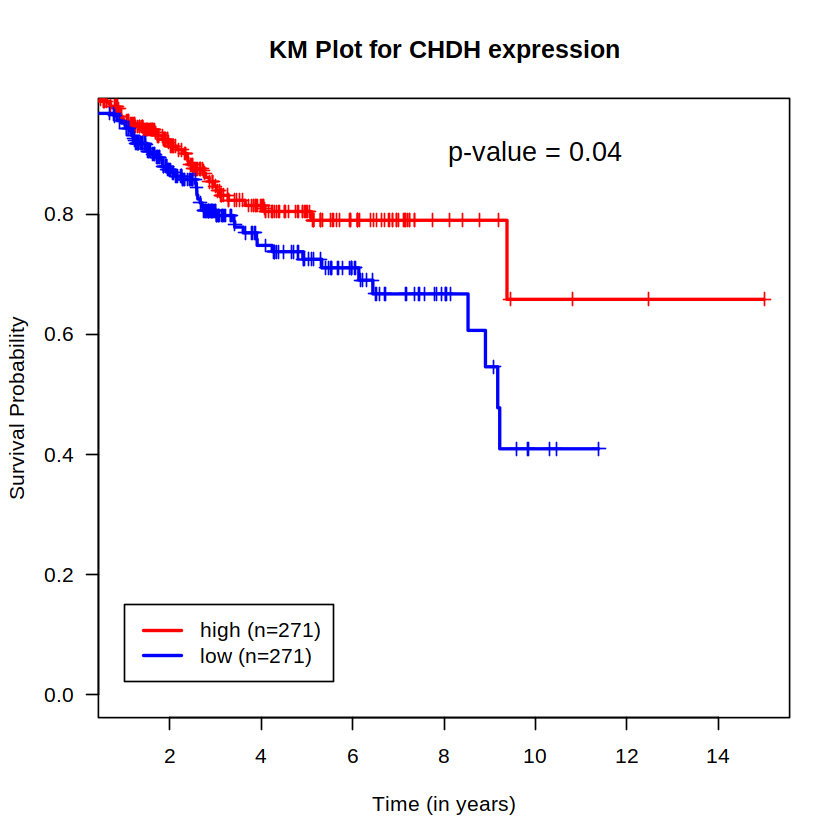

In [352]:
plot(ucec_surv_fun_chdh, main = "KM Plot for CHDH expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=271)', 'low (n=271)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 0.04', cex=1.3) 

In [226]:
chat = as.data.frame(t(ucec_vst_data["ENSG00000070748", ]))
summary(chat)

 ENSG00000070748
 Min.   :2.967  
 1st Qu.:2.967  
 Median :2.967  
 Mean   :3.354  
 3rd Qu.:3.534  
 Max.   :9.707  

In [230]:
chat$binary<- ifelse(chat$ENSG00000070748 > 3.354,"high","low")
#head(chdh,3)

# Fitting the survival model
surv_fun_chat = survfit(Surv(ucec_prim_clinical_data$OS.time/365,
                             ucec_prim_clinical_data$OS)~ chat$binary)
surv_fun_chat

Call: survfit(formula = Surv(ucec_prim_clinical_data$OS.time/365, ucec_prim_clinical_data$OS) ~ 
    chat$binary)

                   n events median 0.95LCL 0.95UCL
chat$binary=high 190     42   9.18    8.53      NA
chat$binary=low  352     49     NA    9.38      NA

In [231]:
survdiff(Surv(ucec_prim_clinical_data$OS.time/365,ucec_prim_clinical_data$OS)~ chat$binary)

Call:
survdiff(formula = Surv(ucec_prim_clinical_data$OS.time/365, 
    ucec_prim_clinical_data$OS) ~ chat$binary)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
chat$binary=high 190       42     30.3      4.50      6.77
chat$binary=low  352       49     60.7      2.25      6.77

 Chisq= 6.8  on 1 degrees of freedom, p= 0.009 

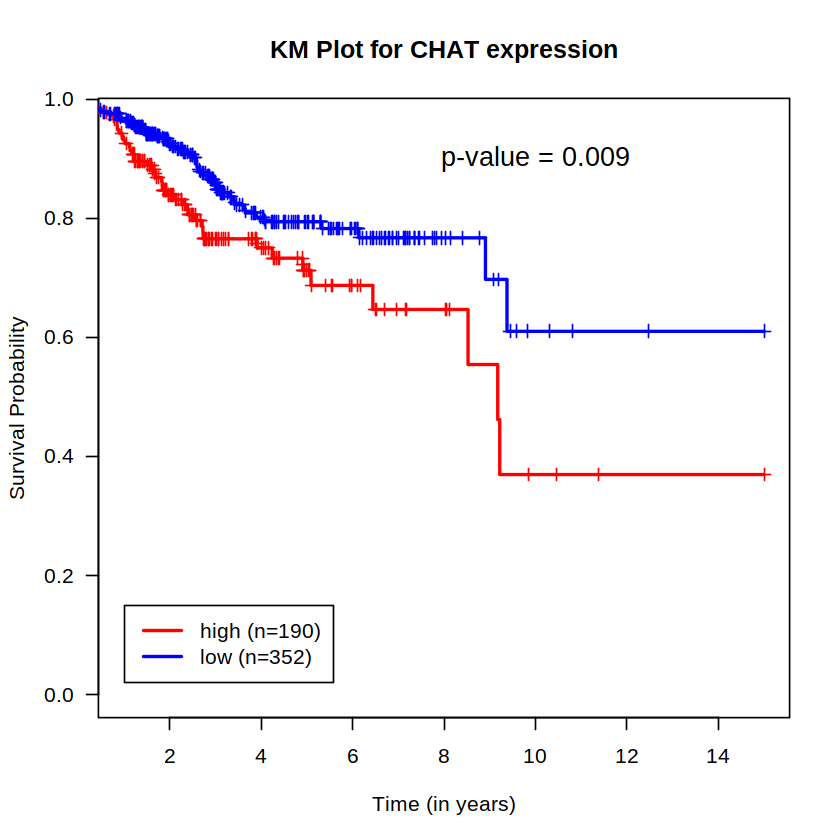

In [233]:
plot(surv_fun_chat, main = "KM Plot for CHAT expression", xlim = c(1,15), xlab = 'Time (in years)', ylab = 'Survival Probability', 
     col = c('red', 'blue'), las= 1, lwd = 2,  mark.time = TRUE, cex=1)
legend(1, 0.15, legend = c('high (n=190)', 'low (n=352)'),lwd = 2, col = c('red', 'blue'), bty = '', cex = 1)
text(10, 0.9,  'p-value = 0.009', cex=1.3) 

## Multivariate Cox regression analysis

In [80]:
covariates <- c("age", "sex",  "ph.karno", "ph.ecog", "wt.loss")
univ_formulas <- sapply(colnames(vst_exp_surv1[, sig_univariate_res$Ensembl_id[1:10]]),
                        function(x) paste('+ vst_exp_surv1$', x , sep = ""))
temp = ""
for (i in univ_formulas){
    temp = paste(temp, i)
}
print(temp)

[1] " + vst_exp_surv1$ENSG00000002587 + vst_exp_surv1$ENSG00000002726 + vst_exp_surv1$ENSG00000004809 + vst_exp_surv1$ENSG00000008300 + vst_exp_surv1$ENSG00000010379 + vst_exp_surv1$ENSG00000021826 + vst_exp_surv1$ENSG00000027644 + vst_exp_surv1$ENSG00000036473 + vst_exp_surv1$ENSG00000058866 + vst_exp_surv1$ENSG00000064270"


In [79]:
multi_res.cox <- coxph(Surv(ucec_prim_clinical_data$OS.time, 
                      ucec_prim_clinical_data$OS) ~ vst_exp_surv1$ENSG00000002587 + vst_exp_surv1$ENSG00000002726 + vst_exp_surv1$ENSG00000004809 + vst_exp_surv1$ENSG00000008300 + vst_exp_surv1$ENSG00000010379 + vst_exp_surv1$ENSG00000021826 + vst_exp_surv1$ENSG00000027644 + vst_exp_surv1$ENSG00000036473 + vst_exp_surv1$ENSG00000058866 + vst_exp_surv1$ENSG00000064270 + vst_exp_surv1$ENSG00000064655 + vst_exp_surv1$ENSG00000066230 + vst_exp_surv1$ENSG00000067840 + vst_exp_surv1$ENSG00000068078 + vst_exp_surv1$ENSG00000069020 + vst_exp_surv1$ENSG00000069764 + vst_exp_surv1$ENSG00000070748 + vst_exp_surv1$ENSG00000070915 + vst_exp_surv1$ENSG00000071073 + vst_exp_surv1$ENSG00000072041 + vst_exp_surv1$ENSG00000072133 + vst_exp_surv1$ENSG00000072195 + vst_exp_surv1$ENSG00000072657 + vst_exp_surv1$ENSG00000074211 + vst_exp_surv1$ENSG00000077264 + vst_exp_surv1$ENSG00000079215 + vst_exp_surv1$ENSG00000080224 + vst_exp_surv1$ENSG00000081479 + vst_exp_surv1$ENSG00000086062 + vst_exp_surv1$ENSG00000087253 + vst_exp_surv1$ENSG00000087586 + vst_exp_surv1$ENSG00000091664 + vst_exp_surv1$ENSG00000091704 + vst_exp_surv1$ENSG00000095303 + vst_exp_surv1$ENSG00000095777 + vst_exp_surv1$ENSG00000100170 + vst_exp_surv1$ENSG00000100417 + vst_exp_surv1$ENSG00000100626 + vst_exp_surv1$ENSG00000101210 + vst_exp_surv1$ENSG00000101224 + vst_exp_surv1$ENSG00000101255 + vst_exp_surv1$ENSG00000101638 + vst_exp_surv1$ENSG00000103056 + vst_exp_surv1$ENSG00000103546 + vst_exp_surv1$ENSG00000105205 + vst_exp_surv1$ENSG00000105409 + vst_exp_surv1$ENSG00000105613 + vst_exp_surv1$ENSG00000106123 + vst_exp_surv1$ENSG00000106633 + vst_exp_surv1$ENSG00000106688 + vst_exp_surv1$ENSG00000107611 + vst_exp_surv1$ENSG00000107954 + vst_exp_surv1$ENSG00000108602 + vst_exp_surv1$ENSG00000108813 + vst_exp_surv1$ENSG00000109193 + vst_exp_surv1$ENSG00000111181 + vst_exp_surv1$ENSG00000111371 + vst_exp_surv1$ENSG00000111962 + vst_exp_surv1$ENSG00000112309 + vst_exp_surv1$ENSG00000112319 + vst_exp_surv1$ENSG00000112742 + vst_exp_surv1$ENSG00000112981 + vst_exp_surv1$ENSG00000113924 + vst_exp_surv1$ENSG00000114113 + vst_exp_surv1$ENSG00000114200 + vst_exp_surv1$ENSG00000115419 + vst_exp_surv1$ENSG00000116039 + vst_exp_surv1$ENSG00000116254 + vst_exp_surv1$ENSG00000116675 + vst_exp_surv1$ENSG00000117215 + vst_exp_surv1$ENSG00000117507 + vst_exp_surv1$ENSG00000118094 + vst_exp_surv1$ENSG00000118402 + vst_exp_surv1$ENSG00000119915 + vst_exp_surv1$ENSG00000124140 + vst_exp_surv1$ENSG00000124564 + vst_exp_surv1$ENSG00000124568 + vst_exp_surv1$ENSG00000125772 + vst_exp_surv1$ENSG00000128039 + vst_exp_surv1$ENSG00000128683 + vst_exp_surv1$ENSG00000129951 + vst_exp_surv1$ENSG00000130035 + vst_exp_surv1$ENSG00000130055 + vst_exp_surv1$ENSG00000130066 + vst_exp_surv1$ENSG00000130508 + vst_exp_surv1$ENSG00000130589 + vst_exp_surv1$ENSG00000130707 + vst_exp_surv1$ENSG00000130829 + vst_exp_surv1$ENSG00000130876 + vst_exp_surv1$ENSG00000131055 + vst_exp_surv1$ENSG00000132164 + vst_exp_surv1$ENSG00000132437 + vst_exp_surv1$ENSG00000132518 + vst_exp_surv1$ENSG00000132677 + vst_exp_surv1$ENSG00000132874 + vst_exp_surv1$ENSG00000132932 + vst_exp_surv1$ENSG00000133216 + vst_exp_surv1$ENSG00000133742 + vst_exp_surv1$ENSG00000133878 + vst_exp_surv1$ENSG00000134014 + vst_exp_surv1$ENSG00000135069 + vst_exp_surv1$ENSG00000135220 + vst_exp_surv1$ENSG00000135318 + vst_exp_surv1$ENSG00000135454 + vst_exp_surv1$ENSG00000135917 + vst_exp_surv1$ENSG00000136943 + vst_exp_surv1$ENSG00000138030 + vst_exp_surv1$ENSG00000138696 + vst_exp_surv1$ENSG00000138744 + vst_exp_surv1$ENSG00000138769 + vst_exp_surv1$ENSG00000139044 + vst_exp_surv1$ENSG00000139540 + vst_exp_surv1$ENSG00000140057 + vst_exp_surv1$ENSG00000140297 + vst_exp_surv1$ENSG00000140505 + vst_exp_surv1$ENSG00000141639 + vst_exp_surv1$ENSG00000141736 + vst_exp_surv1$ENSG00000141744 + vst_exp_surv1$ENSG00000141934 + vst_exp_surv1$ENSG00000142319 + vst_exp_surv1$ENSG00000142494 + vst_exp_surv1$ENSG00000142619 + vst_exp_surv1$ENSG00000143753 + vst_exp_surv1$ENSG00000143797 + vst_exp_surv1$ENSG00000143882 + vst_exp_surv1$ENSG00000144278 + vst_exp_surv1$ENSG00000145626 + vst_exp_surv1$ENSG00000145675 + vst_exp_surv1$ENSG00000145692 + vst_exp_surv1$ENSG00000146039 + vst_exp_surv1$ENSG00000149150 + vst_exp_surv1$ENSG00000149452 + vst_exp_surv1$ENSG00000149527 + vst_exp_surv1$ENSG00000149599 + vst_exp_surv1$ENSG00000152270 + vst_exp_surv1$ENSG00000154027 + vst_exp_surv1$ENSG00000154269 + vst_exp_surv1$ENSG00000154928 + vst_exp_surv1$ENSG00000155897 + vst_exp_surv1$ENSG00000156219 + vst_exp_surv1$ENSG00000156475 + vst_exp_surv1$ENSG00000156689 + vst_exp_surv1$ENSG00000157087 + vst_exp_surv1$ENSG00000158089 + vst_exp_surv1$ENSG00000158104 + vst_exp_surv1$ENSG00000159714 + vst_exp_surv1$ENSG00000160200 + vst_exp_surv1$ENSG00000161798 + vst_exp_surv1$ENSG00000161896 + vst_exp_surv1$ENSG00000162174 + vst_exp_surv1$ENSG00000162571 + vst_exp_surv1$ENSG00000162669 + vst_exp_surv1$ENSG00000163558 + vst_exp_surv1$ENSG00000163629 + vst_exp_surv1$ENSG00000164100 + vst_exp_surv1$ENSG00000164181 + vst_exp_surv1$ENSG00000164574 + vst_exp_surv1$ENSG00000165695 + vst_exp_surv1$ENSG00000166840 + vst_exp_surv1$ENSG00000167103 + vst_exp_surv1$ENSG00000167311 + vst_exp_surv1$ENSG00000168032 + vst_exp_surv1$ENSG00000169418 + vst_exp_surv1$ENSG00000170324 + vst_exp_surv1$ENSG00000170439 + vst_exp_surv1$ENSG00000170482 + vst_exp_surv1$ENSG00000171094 + vst_exp_surv1$ENSG00000172264 + vst_exp_surv1$ENSG00000172828 + vst_exp_surv1$ENSG00000172955 + vst_exp_surv1$ENSG00000173083 + vst_exp_surv1$ENSG00000173627 + vst_exp_surv1$ENSG00000174156 + vst_exp_surv1$ENSG00000175063 + vst_exp_surv1$ENSG00000175229 + vst_exp_surv1$ENSG00000176463 + vst_exp_surv1$ENSG00000177108 + vst_exp_surv1$ENSG00000178445 + vst_exp_surv1$ENSG00000178538 + vst_exp_surv1$ENSG00000179455 + vst_exp_surv1$ENSG00000180176 + vst_exp_surv1$ENSG00000180537 + vst_exp_surv1$ENSG00000180767 + vst_exp_surv1$ENSG00000180815 + vst_exp_surv1$ENSG00000181409 + vst_exp_surv1$ENSG00000181856 + vst_exp_surv1$ENSG00000182050 + vst_exp_surv1$ENSG00000182333 + vst_exp_surv1$ENSG00000182870 + vst_exp_surv1$ENSG00000183023 + vst_exp_surv1$ENSG00000183196 + vst_exp_surv1$ENSG00000183317 + vst_exp_surv1$ENSG00000183654 + vst_exp_surv1$ENSG00000183921 + vst_exp_surv1$ENSG00000184154 + vst_exp_surv1$ENSG00000185527 + vst_exp_surv1$ENSG00000185974 + vst_exp_surv1$ENSG00000186204 + vst_exp_surv1$ENSG00000186526 + vst_exp_surv1$ENSG00000187210 + vst_exp_surv1$ENSG00000187714 + vst_exp_surv1$ENSG00000187980 + vst_exp_surv1$ENSG00000188338 + vst_exp_surv1$ENSG00000196090 + vst_exp_surv1$ENSG00000196368 + vst_exp_surv1$ENSG00000196632 + vst_exp_surv1$ENSG00000196839 + vst_exp_surv1$ENSG00000197142 + vst_exp_surv1$ENSG00000197208 + vst_exp_surv1$ENSG00000197241 + vst_exp_surv1$ENSG00000197977 + vst_exp_surv1$ENSG00000198099 + vst_exp_surv1$ENSG00000198400 + vst_exp_surv1$ENSG00000198842 + vst_exp_surv1$ENSG00000198910 + vst_exp_surv1$ENSG00000203805 + vst_exp_surv1$ENSG00000204099 + vst_exp_surv1$ENSG00000211448 + vst_exp_surv1$ENSG00000214617 + vst_exp_surv1$ENSG00000241635 + vst_exp_surv1$ENSG00000244067 + vst_exp_surv1$ENSG00000250305 + vst_exp_surv1$ENSG00000257335 + vst_exp_surv1$ENSG00000257594 + vst_exp_surv1$ENSG00000259075)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“one or more coefficients may be infinite”


### glmnet

In [353]:
## 183th patient has 0 "OS.time", which is suitabe as input in glmnet package
fit = glmnet(as.matrix(vst_exp_surv[-c(183), sig_univariate_res$Ensembl_id]), # X matrix
                   Surv(ucec_prim_clinical_data[-c(183),]$OS.time, ucec_prim_clinical_data[-c(183), ]$OS), 
                   alpha = 1, # lasso: alpha = 1; ridge: alpha=0
                   family = "cox" ) # specify Cox PH model)
#plot(fit)
# print(fit)
# fit$lambda

In [359]:
# print(fit)

In [357]:
dim(summary(coef(fit, s = 0.018960)))

[1] 57  3

In [360]:
cv.fit = cv.glmnet(as.matrix(vst_exp_surv[-c(183), sig_univariate_res$Ensembl_id]), # X matrix
                   Surv(ucec_prim_clinical_data[-c(183),]$OS.time, ucec_prim_clinical_data[-c(183), ]$OS), 
                   alpha = 1, # lasso: alpha = 1; ridge: alpha=0
                   family = "cox" , type.measure = "C") # specify Cox PH model)

Warning message:
“from glmnet C++ code (error code -30094); Numerical error at 94th lambda value; solutions for larger values of lambda returned”
Warning message:
“from glmnet C++ code (error code -30074); Numerical error at 74th lambda value; solutions for larger values of lambda returned”


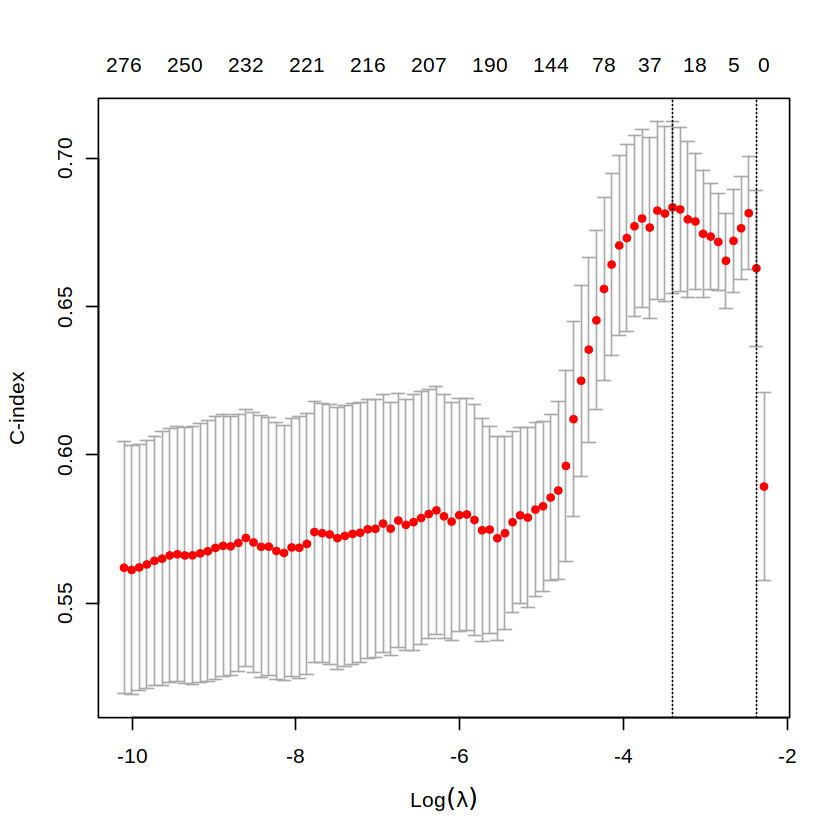

In [361]:
plot(cv.fit)

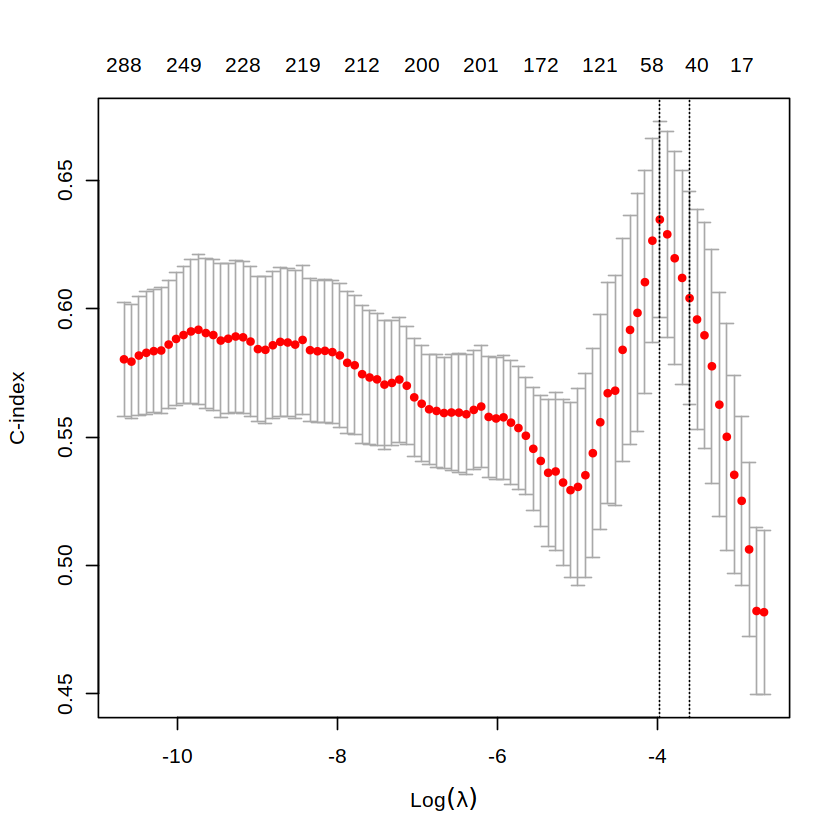

In [255]:
plot(cv.fit)

In [362]:
print(log(cv.fit$lambda.min)) # in log-scale
print(cv.fit$lambda.min)
print(cv.fit$lambda.1se)

[1] -3.399445
[1] 0.0333918
[1] 0.09291467


In [298]:
print(log(cv.fit$lambda.min)) # in log-scale
print(cv.fit$lambda.min)
print(cv.fit$lambda.1se)

[1] -3.965457
[1] 0.01895937
[1] 0.0275068


In [363]:
est.coef = coef(cv.fit, s = cv.fit$lambda.min) # returns the p length coefficient vector
                                               # of the solution corresponding to lambda 
active.k = which(est.coef != 0)
print(length(active.k))
active.k.vals = est.coef[active.k]

[1] 30


In [365]:
multi_res <- as.data.frame(summary(coef(fit, s = 0.01895937)))
print(dim(multi_res))

imp_coef <- c()
for (val in multi_res$i){
    imp_coef <- c(imp_coef, dimnames(est.coef)[[1]][val])
}
print(length(imp_coef))

multi_res$Genes <- gene_mapping[imp_coef, "external_gene_name"]
head(multi_res)

[1] 57  3
[1] 57


i  j x            Genes  
1  5 1  0.050164497 CPS1   
2 14 1  0.276668575 MGAT4A 
3 15 1 -0.037541367 SLC6A15
4 20 1  0.001109411 SLC1A3 
5 24 1  0.135058646 SLC17A6
6 46 1  0.005616959 RBP2

In [366]:
table(multi_res$x >0)


FALSE  TRUE 
   19    38 

In [367]:
filter(multi_res, x<0)$Genes

[1] "SLC6A15"  "SLC7A10"  "SLC14A2"  "DUSP15"   "MKRN3"    "UAP1L1"  
 [7] "CHST3"    "DUSP6"    "LCK"      "GALNT12"  "CTSW"     "B4GALNT3"
[13] "NME5"     "CYP2D6"   "B4GALT1"  "MAOB"     "CA12"     "PLA2G4A" 
[19] "PPP2R2C"

In [368]:
filter(multi_res, x>0)$Genes

[1] "CPS1"    "MGAT4A"  "SLC1A3"  "SLC17A6" "RBP2"    "GDPD2"   "PXDN"   
 [8] "MBOAT2"  "SLC22A8" "AK5"     "MAP3K15" "EPHA10"  "MARCH11" "ADA"    
[15] "SLC2A7"  "UGT1A1"  "PTPRN"   "GAL3ST2" "ITPKA"   "AQP4"    "PRKAA2" 
[22] "GGH"     "CA3"     "ATP5F1D" "EPHX2"   "CDK14"   "PHGDH"   "AK4"    
[29] "NTRK3"   "SAT1"    "RBP4"    "SLC9A4"  "SLC16A1" "CKMT1B"  "CHST9"  
[36] "BBOX1"   "FABP6"   "CFTR"

In [370]:
# print_genes(filter(multi_res, x>0)$Genes)